In [20]:
#https://umrs.org.ua/activities/conferences/hmt-2025/abstract-guidelines/
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import numpy as np

In [21]:
# Material and mold constants
MOLD_DIAMETER_MM = 20
MAX_THEORETICAL_DENSITY = 5.43  # g/cm³ for TiN
mold_area_mm2 = 3.14 * MOLD_DIAMETER_MM * MOLD_DIAMETER_MM / 4

def calculate_relative_density(
        travel,
        weight,  # in grams
        measuredDensity,  # in g/cm^3
        totalTravel,
        maxTemperature):
    
    # Calculate final sample dimensions from measured density
    final_volume_cm3 = weight / measuredDensity
    final_volume_mm3 = final_volume_cm3 * 1000
    final_height_mm = final_volume_mm3 / mold_area_mm2
    
    # Calculate initial height (before sintering started)
    initial_height_mm = (totalTravel / 1000) + final_height_mm
    
    # Calculate current height based on piston travel
    current_height_mm = initial_height_mm - (travel / 1000)
    
    # Calculate current volume and density
    current_volume_mm3 = mold_area_mm2 * current_height_mm
    current_volume_cm3 = current_volume_mm3 / 1000
    current_density_g_cm3 = weight / current_volume_cm3
    
    # Convert to relative density (percentage of theoretical maximum)
    relative_density_percent = (current_density_g_cm3 / MAX_THEORETICAL_DENSITY) * 100
    
    return relative_density_percent


def calculate_density_for_series(travel, series):
    total_travel = series['TravelRelativeTempCorrected'].max() - series['TravelRelativeTempCorrected'].min()
    max_temp = series['Pyrometer'].max()
    
    return calculate_relative_density(
        travel,
        series.attrs['weight'],
        series.attrs['measuredDensity'],
        total_travel,
        max_temp
    )


def calculate_densityForVirtualExperiment(
        travel,
        weight,  # in grams
        relative_start_density,  # in %
    ):
    # Convert relative density to absolute density
    absolute_start_density_g_cm3 = (relative_start_density / 100) * MAX_THEORETICAL_DENSITY
    
    # Calculate initial sample dimensions from starting density
    initial_volume_cm3 = weight / absolute_start_density_g_cm3
    initial_volume_mm3 = initial_volume_cm3 * 1000
    initial_height_mm = initial_volume_mm3 / mold_area_mm2
    
    # Calculate current height after piston travel
    current_height_mm = initial_height_mm - (travel / 1000)
    
    # Calculate current volume and density
    current_volume_mm3 = mold_area_mm2 * current_height_mm
    current_volume_cm3 = current_volume_mm3 / 1000
    current_density_g_cm3 = weight / current_volume_cm3
    
    # Convert to relative density (percentage of theoretical maximum)
    relative_density_percent = (current_density_g_cm3 / MAX_THEORETICAL_DENSITY) * 100
    
    return relative_density_percent


In [22]:
def filter_data(df):
    # Convert time to timedelta format
    df['P.Zeit'] = pd.to_timedelta(df['P.Zeit'])
    
    # Filter out low temperature and low current readings
    df = df[df['Pyrometer'] > 500].copy()
    df = df[df['I RMS'] > 0.2].copy()
    
    # Calculate relative piston travel in micrometers
    min_piston_travel = df['Abs Piston Tra.'].min()
    df['TravelRelative'] = ((df['Abs Piston Tra.'] - min_piston_travel) * 1000).astype(int)
    
    # Smooth the travel data using cumulative maximum
    df['TravelRelativeCorrected'] = np.maximum.accumulate(df['TravelRelative'])
    df['TravelRelativeCorrected'] = df['TravelRelativeCorrected'].rolling(window=10).mean()
    df.loc[pd.isnull(df['TravelRelativeCorrected']), 'TravelRelativeCorrected'] = 0
    
    # Apply thermal expansion correction (1.241 μm/°C)
    min_temperature = df['Pyrometer'].min()
    thermal_expansion_coefficient = 1.241  # μm/°C
    temperature_delta = df['Pyrometer'] - min_temperature
    df['TravelRelativeTempCorrected'] = df['TravelRelativeCorrected'] + (temperature_delta * thermal_expansion_coefficient)
    
    # Convert time to seconds from start
    df['seconds'] = df['P.Zeit'].dt.total_seconds().astype(int)
    min_seconds = df['seconds'].min()
    df['seconds'] = df['seconds'] - min_seconds + 1
    df = df.drop(columns=['P.Zeit'])
    
    # Downsample: keep every 10th row to reduce data size
    df = df.iloc[::10]
    
    # Calculate original travel delta for comparison
    df['TravelDeltaOriginal'] = df['Abs Piston Tra.'] - df['Abs Piston Tra.'].shift(1)
    
    # Calculate shifted values for next time step prediction
    df['TravelRelativeCorrectedShifted'] = df['TravelRelativeCorrected'].shift(-1)
    df['TravelRelativeCorrectedShifted'] = df['TravelRelativeCorrectedShifted'].fillna(0)
    df['TravelRelativeTempCorrectedShifted'] = df['TravelRelativeTempCorrected'].shift(-1)
    df['PyrometerShifted'] = df['Pyrometer'].shift(-1)
    
    # Calculate travel deltas (densification rates)
    df['TravelDelta'] = df['TravelRelativeTempCorrectedShifted'] - df['TravelRelativeTempCorrected']
    df['TravelDelta2'] = df['TravelRelativeCorrectedShifted'] - df['TravelRelativeCorrected']
    df.loc[pd.isnull(df['TravelDelta']), 'TravelDelta'] = 0
    
    # Calculate relative density
    df['Density'] = calculate_density_for_series(df['TravelRelativeTempCorrected'], df)
    
    # Remove last row (has no valid shifted values)
    df = df.drop(df.index[-1])
    
    return df


In [23]:
# Load experimental data into a dictionary
experiments = {
    '100_1500_32_ann': {
        'file': 'TiN-Starck-0/1483.csv',
        'measuredDensity': 4.92,
        'weight': 6.5
    },
    '100_1500_32': {
        'file': 'TiN-Starck-0/1500.csv',
        'measuredDensity': 4.94,
        'weight': 6.5
    },
    '100_1500_50': {
        'file': 'TiN-Starck-0/1471.csv',
        'measuredDensity': 5.12,
        'weight': 6.47
    },
    '100_1500_70': {
        'file': 'TiN-Starck-0/1499.csv',
        'measuredDensity': 5.12,
        'weight': 6.5
    },
    '200_1500_32': {
        'file': 'TiN-Starck-0/1460.csv',
        'measuredDensity': 4.94,
        'weight': 6.5
    },
    '200_1600_50': {
        'file': 'TiN-Starck-0/1459.csv',
        'measuredDensity': 5.11,
        'weight': 6.5
    },
    '200_1500_70': {
        'file': 'TiN-Starck-0/1468.csv',
        'measuredDensity': 5.12,
        'weight': 6.2
    },
    '200_1500_70_noBn': {
        'file': 'TiN-Starck-0/1469.csv',
        'measuredDensity': 4.93,
        'weight': 6.2
    }
}

# Load and process all data
data = {}
original_data = {}
for key, exp in experiments.items():
    df = pd.read_csv(exp['file'], sep=';', decimal=',')
    df.attrs['measuredDensity'] = exp['measuredDensity']
    df.attrs['weight'] = exp['weight']
    data[key] = filter_data(df)
    original_data[key] = df.copy()
    #print(data[key]['TravelRelativeCorrected'].max()- data[key]['TravelRelativeCorrected'].min())
    #print(data[key]['TravelRelativeTempCorrected'].max()- data[key]['TravelRelativeTempCorrected'].min())


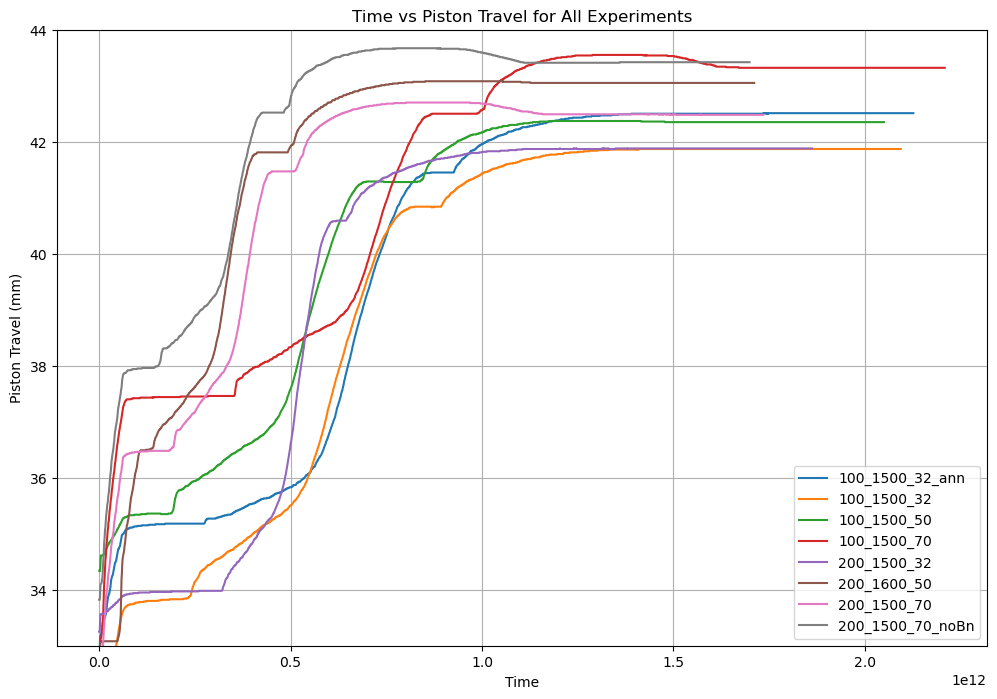

In [24]:
# write a code to plot time vs piston travel for all experiments in original_data
plt.figure(figsize=(12, 8))
for key, df in original_data.items():
    plt.plot(df['P.Zeit'], df['Abs Piston Tra.'], label=key)
plt.xlabel('Time')
plt.ylabel('Piston Travel (mm)')
plt.title('Time vs Piston Travel for All Experiments')
plt.ylim(33, 44)
plt.grid(True)
plt.legend()
plt.show()

<Figure size 4000x600 with 0 Axes>

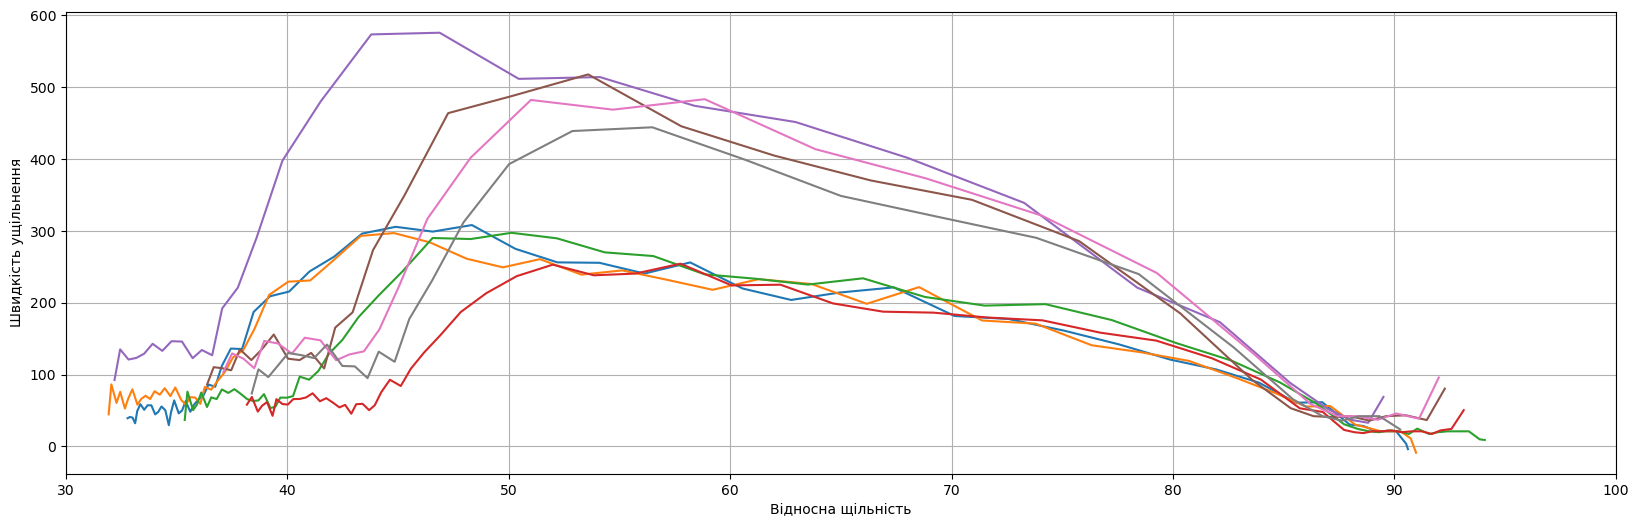

In [25]:
plt.figure(figsize=(40, 6))
fig, ax1 = plt.subplots( figsize=(20, 6))
for key in data.keys():
    ax1.plot(data[key]['Density'], data[key]['TravelDelta'])
# Add color bar to show the color scale
ax1.set_ylabel('Швидкість ущільнення')
#ax1.set_ylim(400, 1000)
ax1.set_xlim(30, 100)
#ax1.set_title('title')
ax1.set_xlabel('Відносна щільність')
ax1.grid(True)
plt.show()


In [26]:
def plot_data_Seconds(data, title):
    setToPlot = data.copy()
    plt.figure(figsize=(40, 6))
    fig, ax1 = plt.subplots( figsize=(40, 6))
    fig, ax2 = plt.subplots( figsize=(40, 6))
    fig, ax3 = plt.subplots( figsize=(40, 6))
    fig, ax4 = plt.subplots( figsize=(40, 6))
    fig, ax5 = plt.subplots( figsize=(40, 6))
    fig, ax6 = plt.subplots( figsize=(40, 6))
    sc2 = ax1.plot(setToPlot['seconds'], setToPlot['Force'], color='black')
    sc2 = ax2.plot(setToPlot['seconds'], setToPlot['TravelRelativeTempCorrected'], color='green')
    sc2 = ax2.plot(setToPlot['seconds'], setToPlot['TravelRelative'], color='blue')
    sc2 = ax3.plot(setToPlot['seconds'], setToPlot['Pyrometer'], color='orange')
    sc2 = ax4.plot(setToPlot['seconds'], setToPlot['Power'], color='red')
    sc2 = ax4.plot(setToPlot['seconds'], setToPlot['U RMS'], color='orange')
    sc2 = ax4.plot(setToPlot['seconds'], setToPlot['I RMS'], color='purple')
    sc2 = ax4.plot(setToPlot['seconds'], setToPlot['U RMS']/setToPlot['I RMS'], color='black')
    sc2 = ax5.plot(setToPlot['seconds'], setToPlot['Density'], color='black')
    sc2 = ax6.plot(setToPlot['seconds'], setToPlot['TravelDelta'], color='black')

    ax4.set_ylim(0,10)
    ax1.set_ylabel('Force')
    ax2.set_ylabel('TravelRelativeTempCorrected')
    ax3.set_ylabel('Pyrometer')
    ax4.set_ylabel('Power')
    ax5.set_ylabel('Density')
    ax6.set_ylabel('TravelDelta')
    ax1.grid(True)
    ax2.grid(True)
    ax3.grid(True)
    ax4.grid(True)
    ax5.grid(True)
    ax6.grid(True)
    ax1.set_title(title)
    ax2.set_title(title)
    ax3.set_title(title)
    ax4.set_title(title)
    ax5.set_title(title)
    ax6.set_title(title)
    plt.show()

<Figure size 4000x600 with 0 Axes>

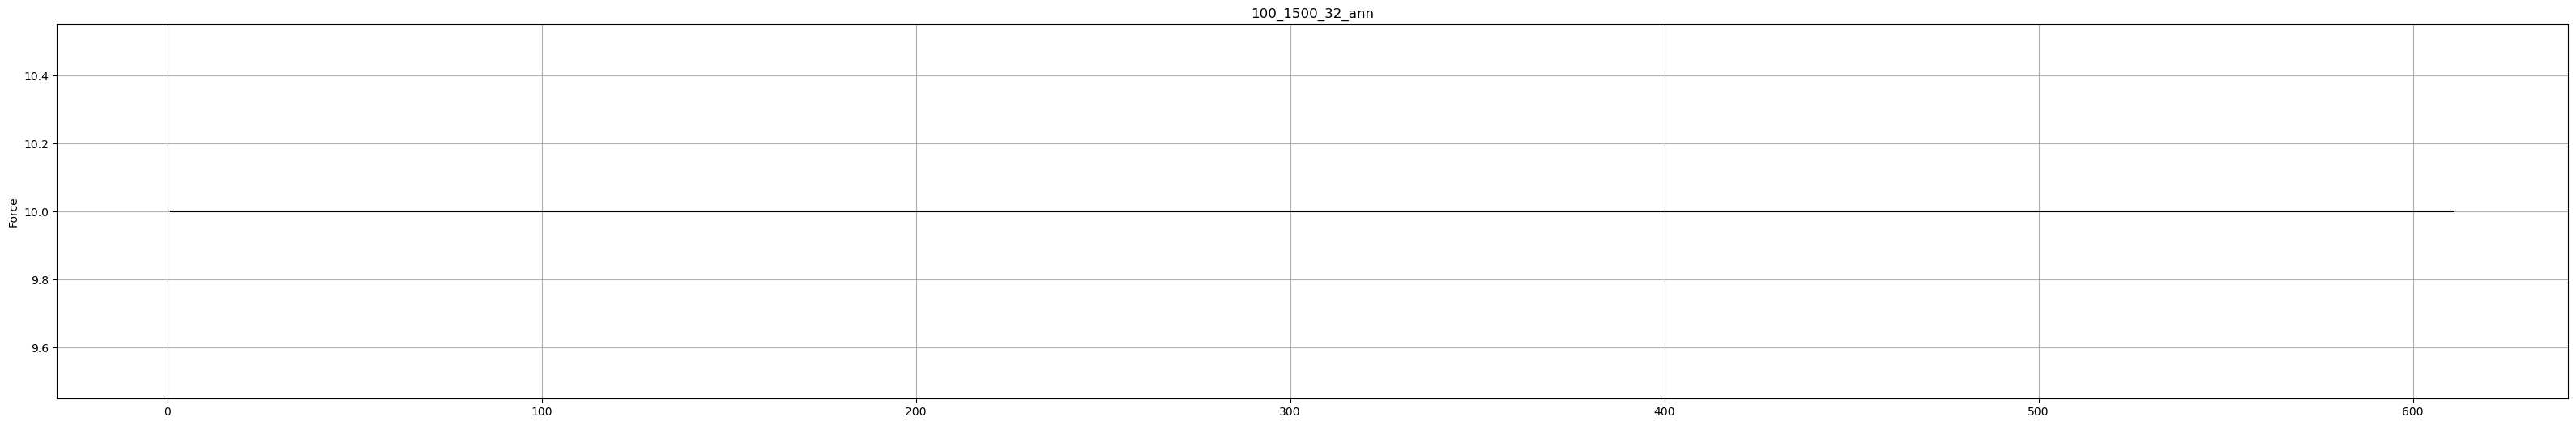

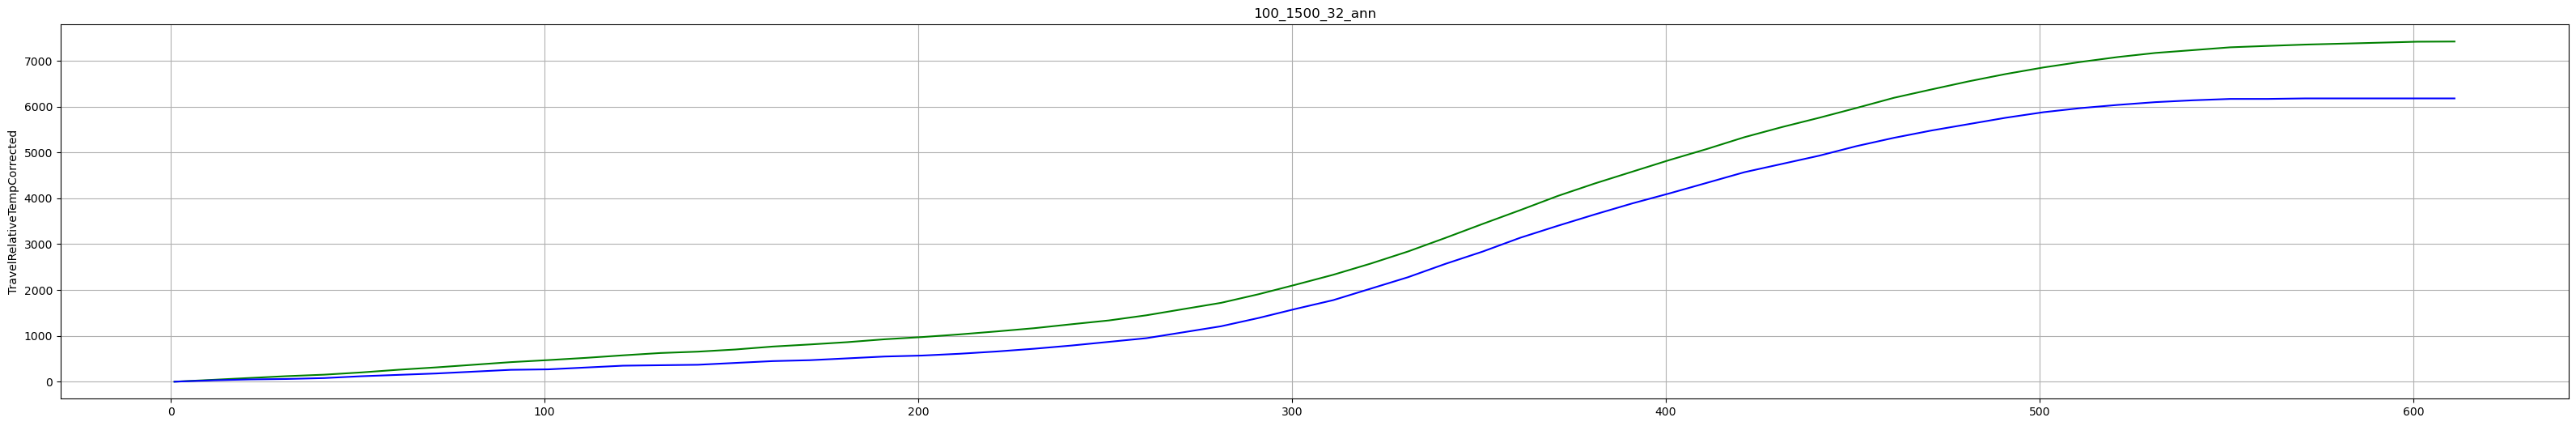

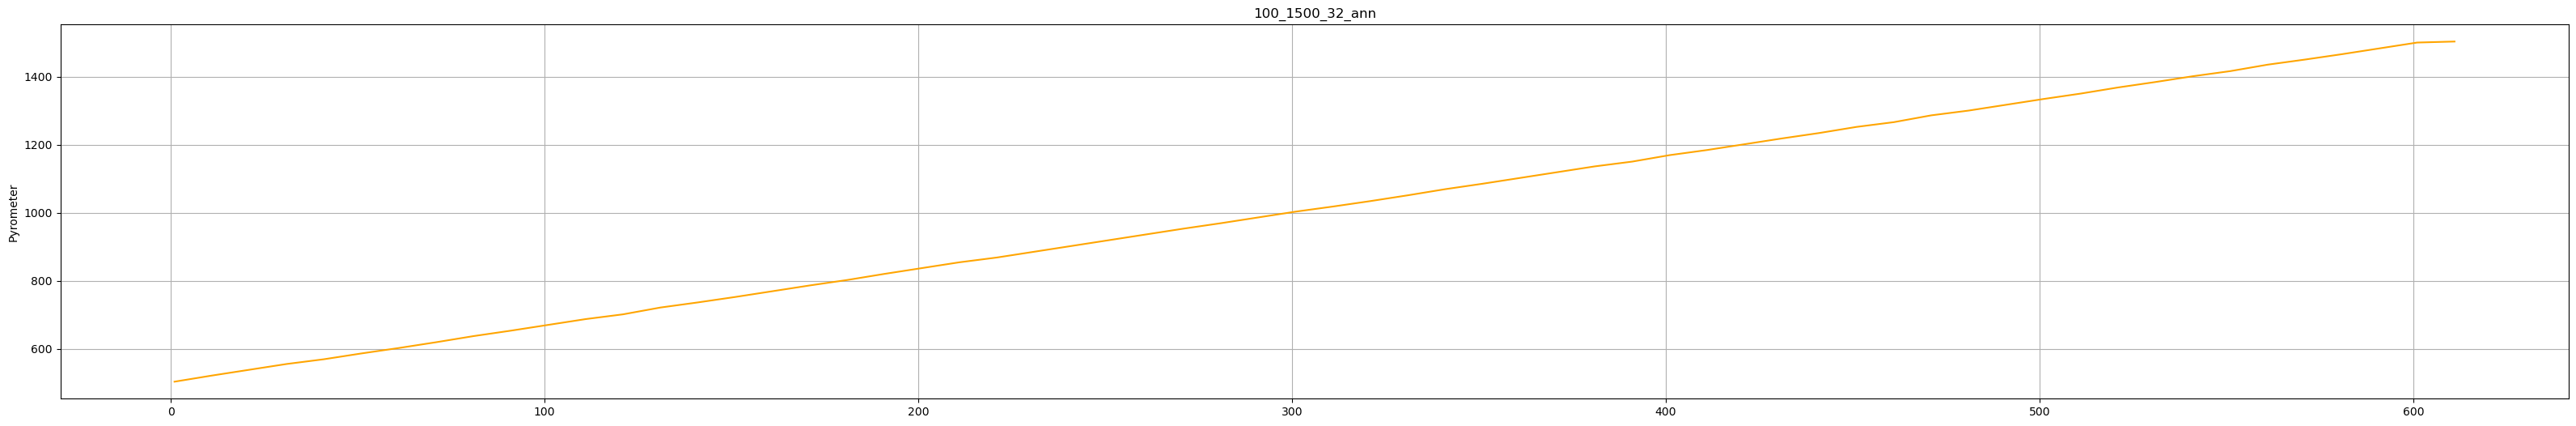

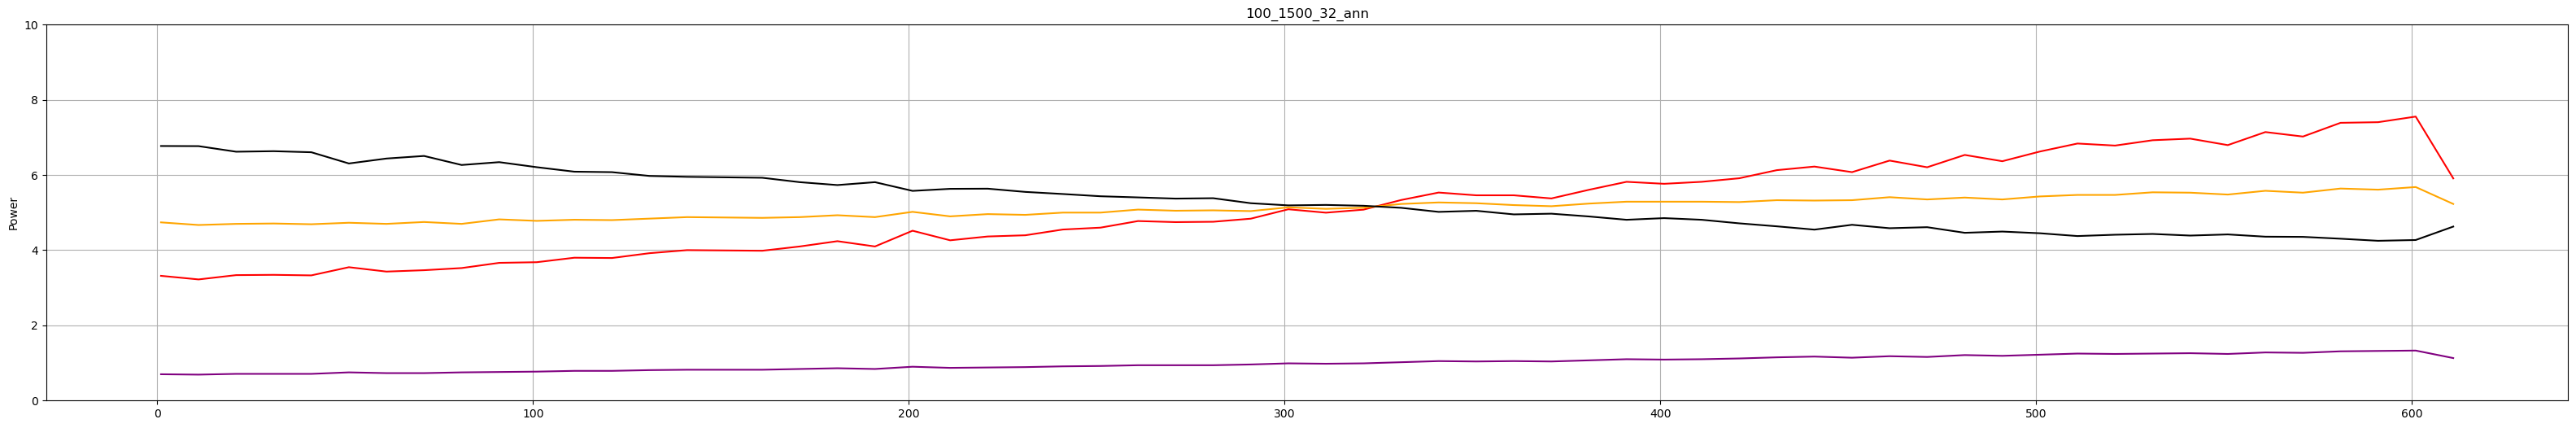

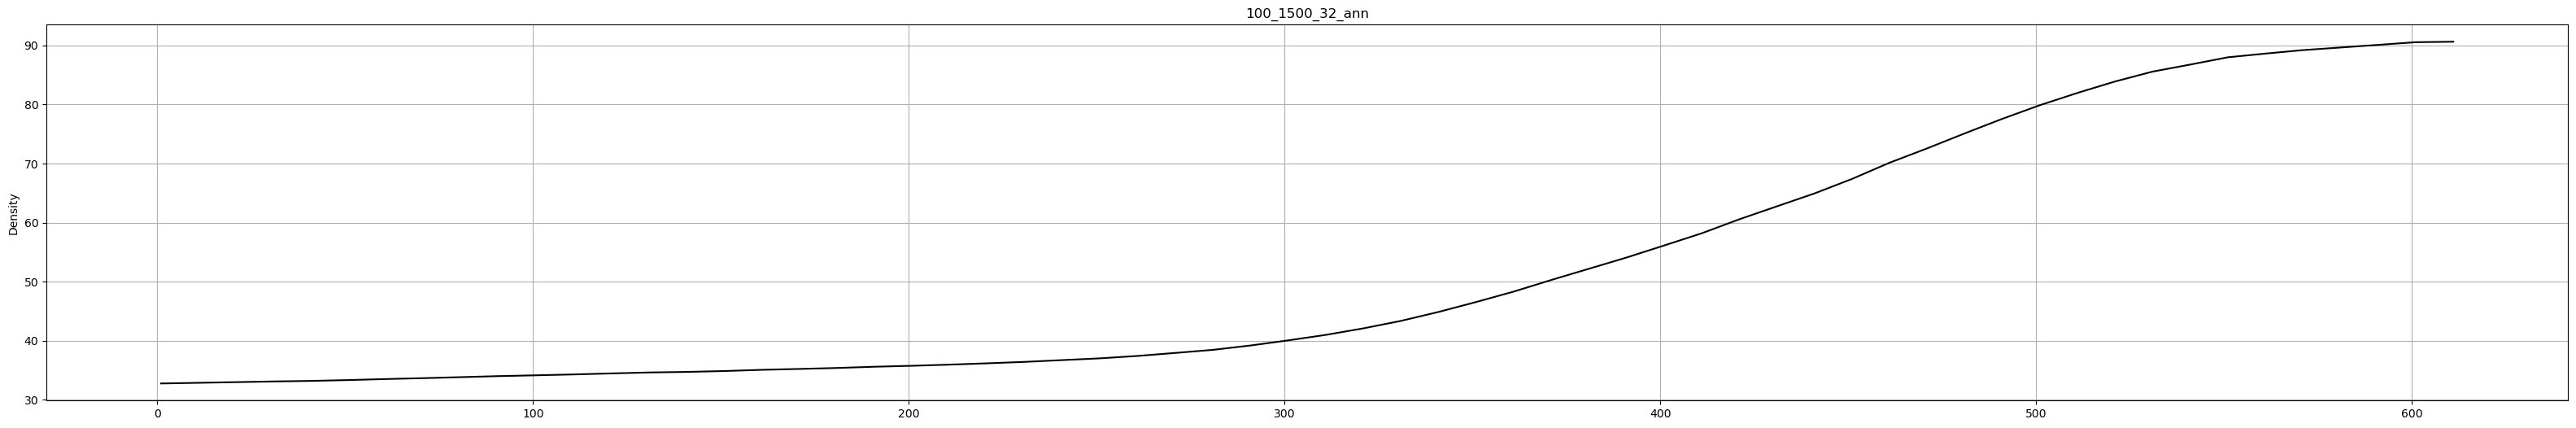

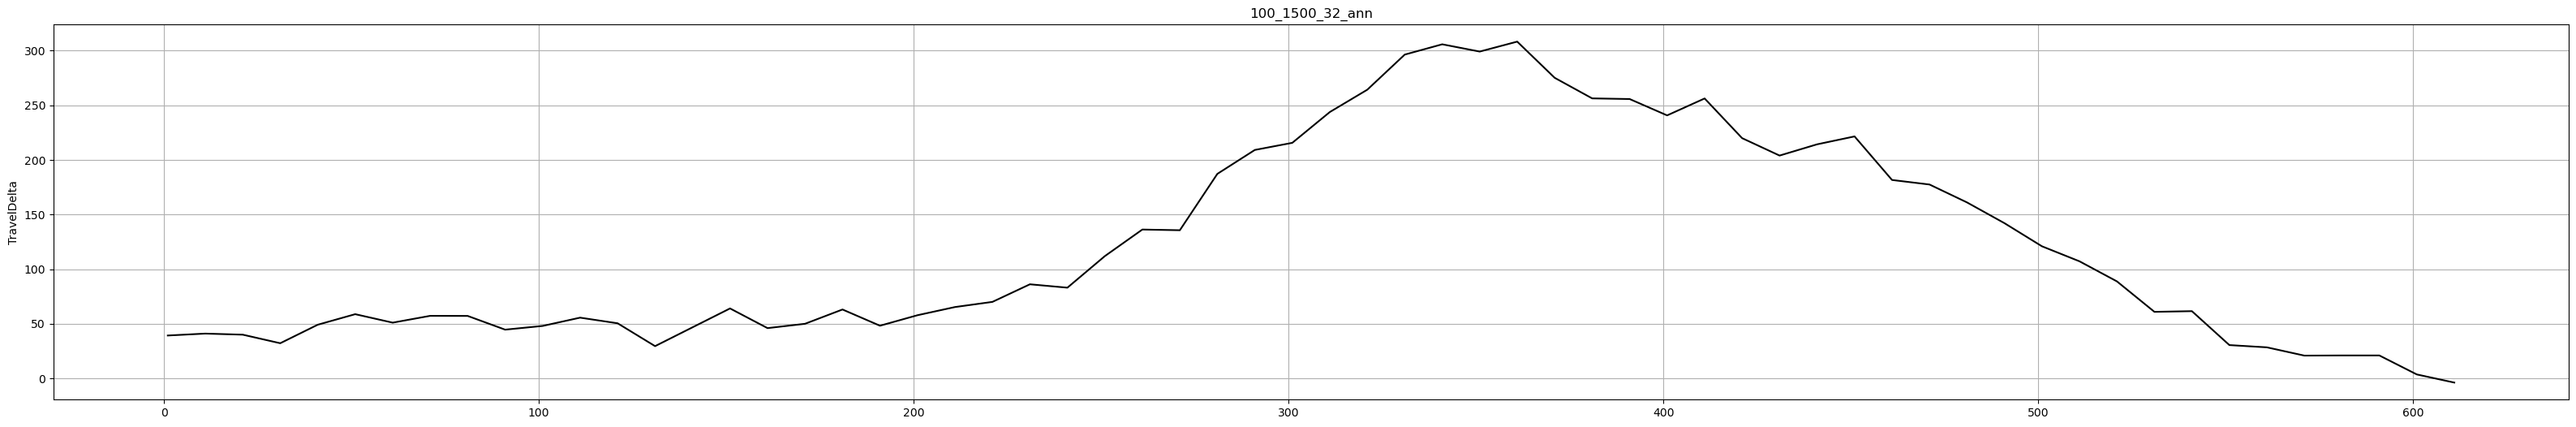

<Figure size 4000x600 with 0 Axes>

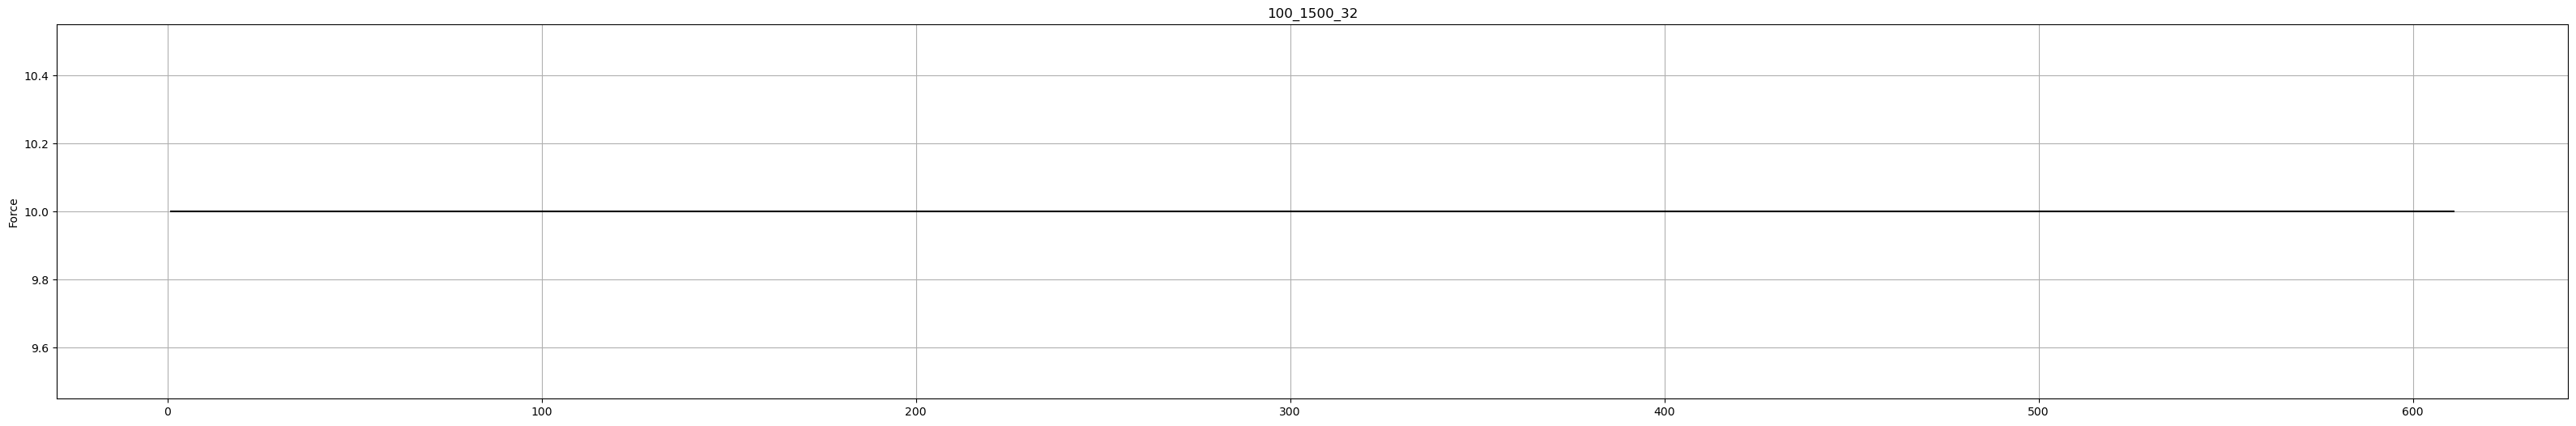

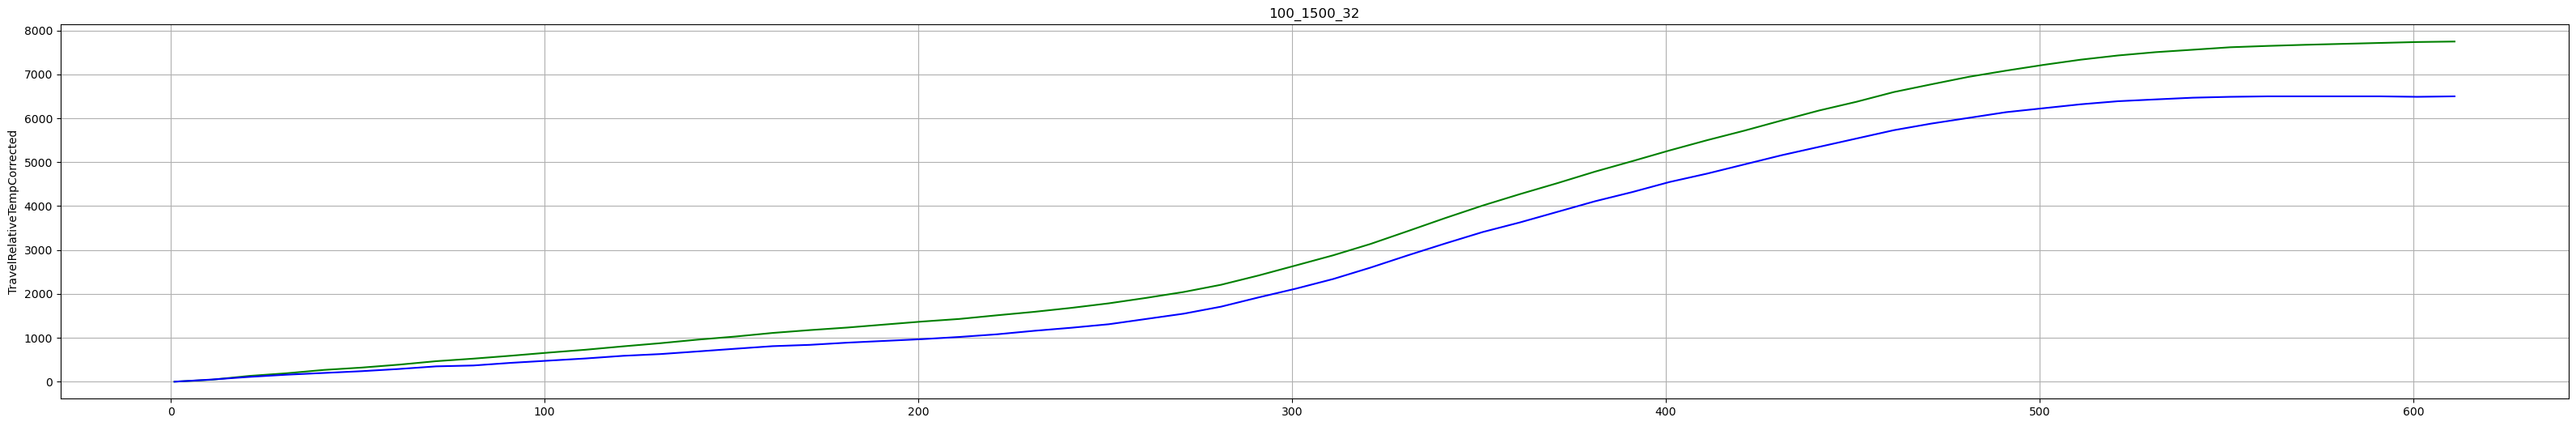

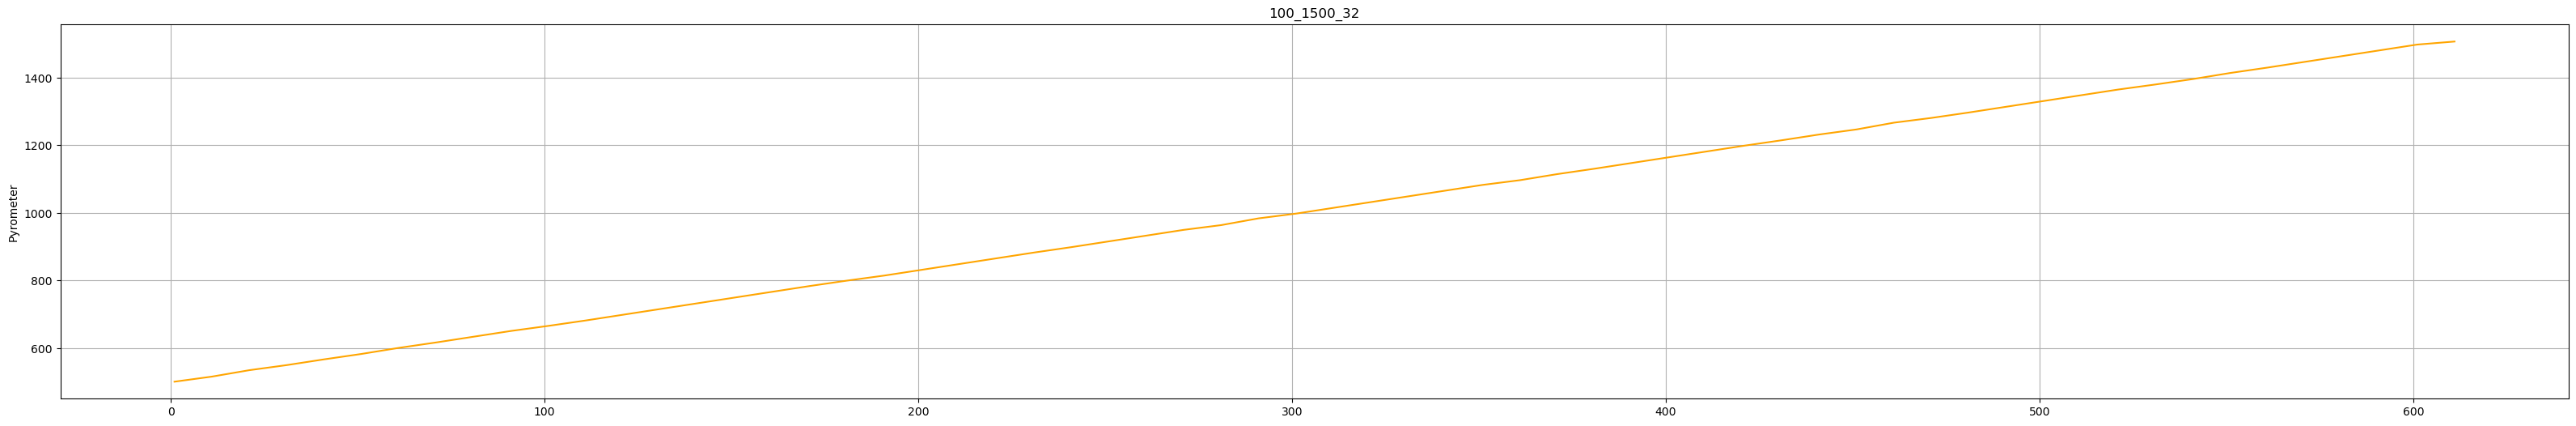

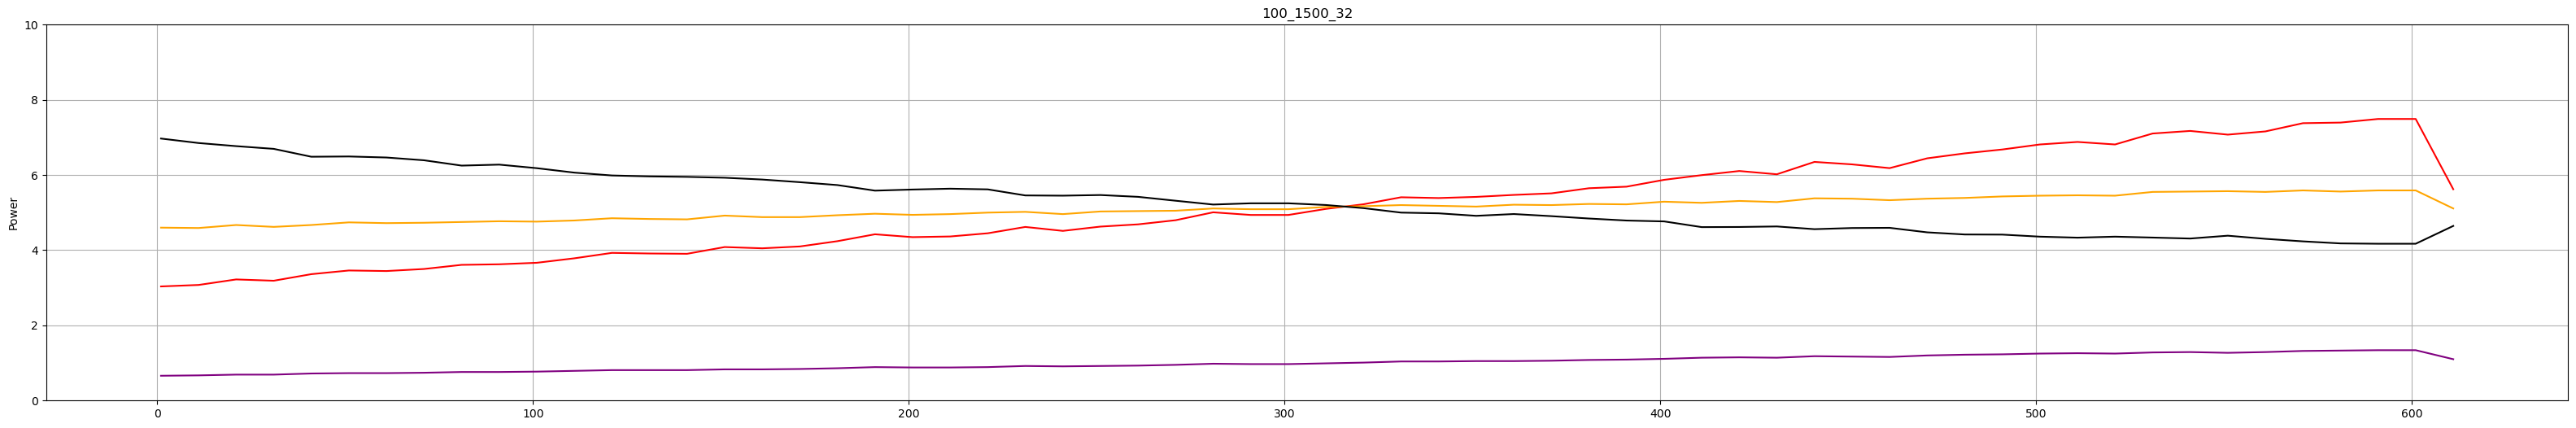

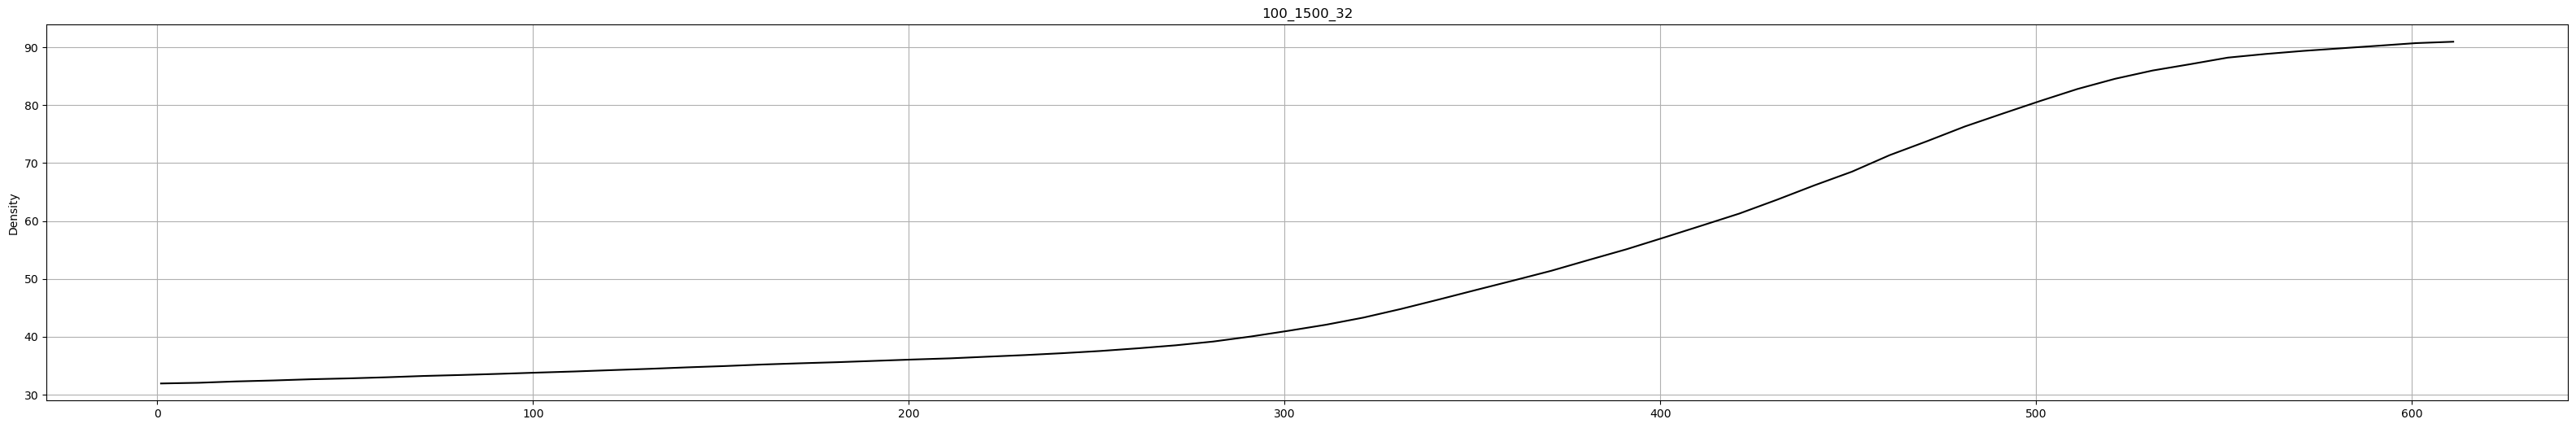

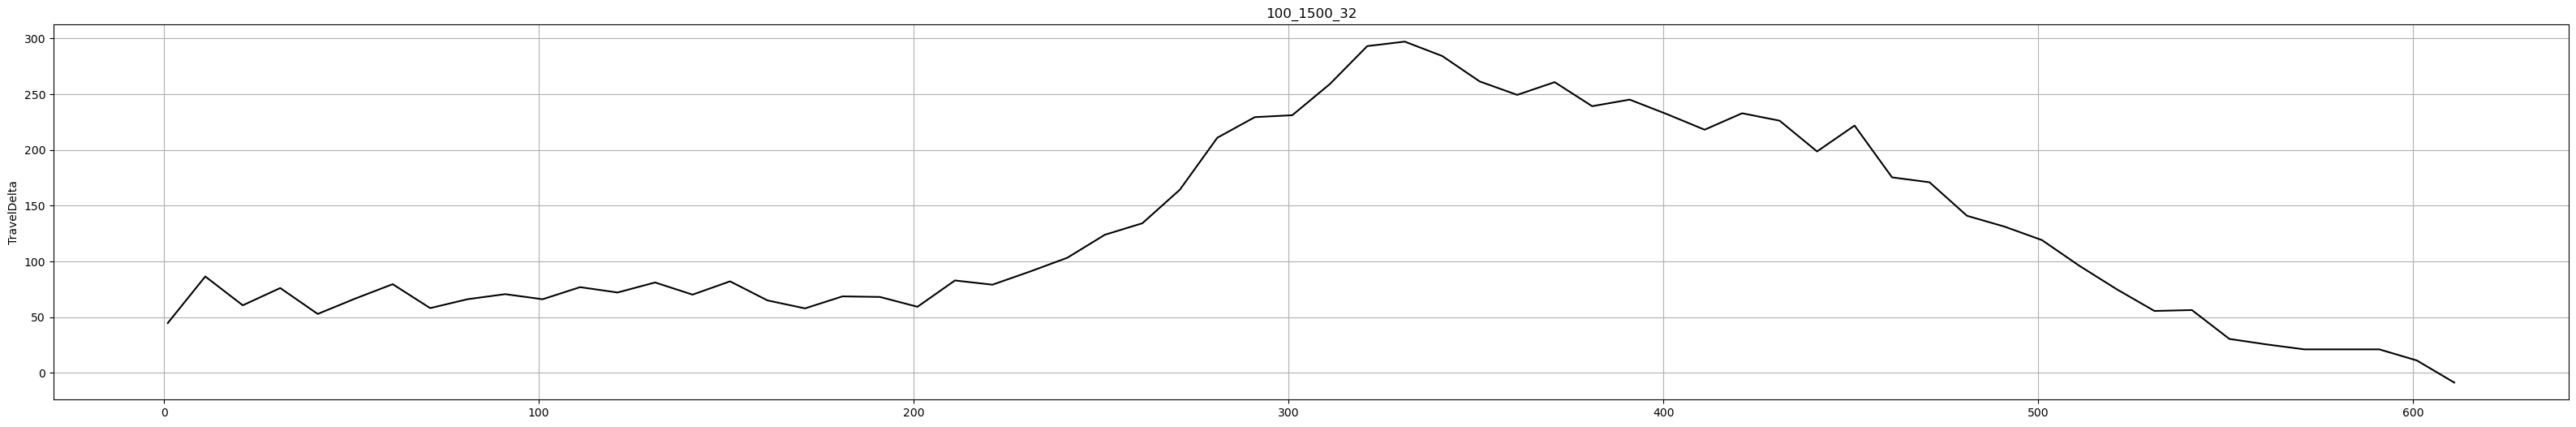

<Figure size 4000x600 with 0 Axes>

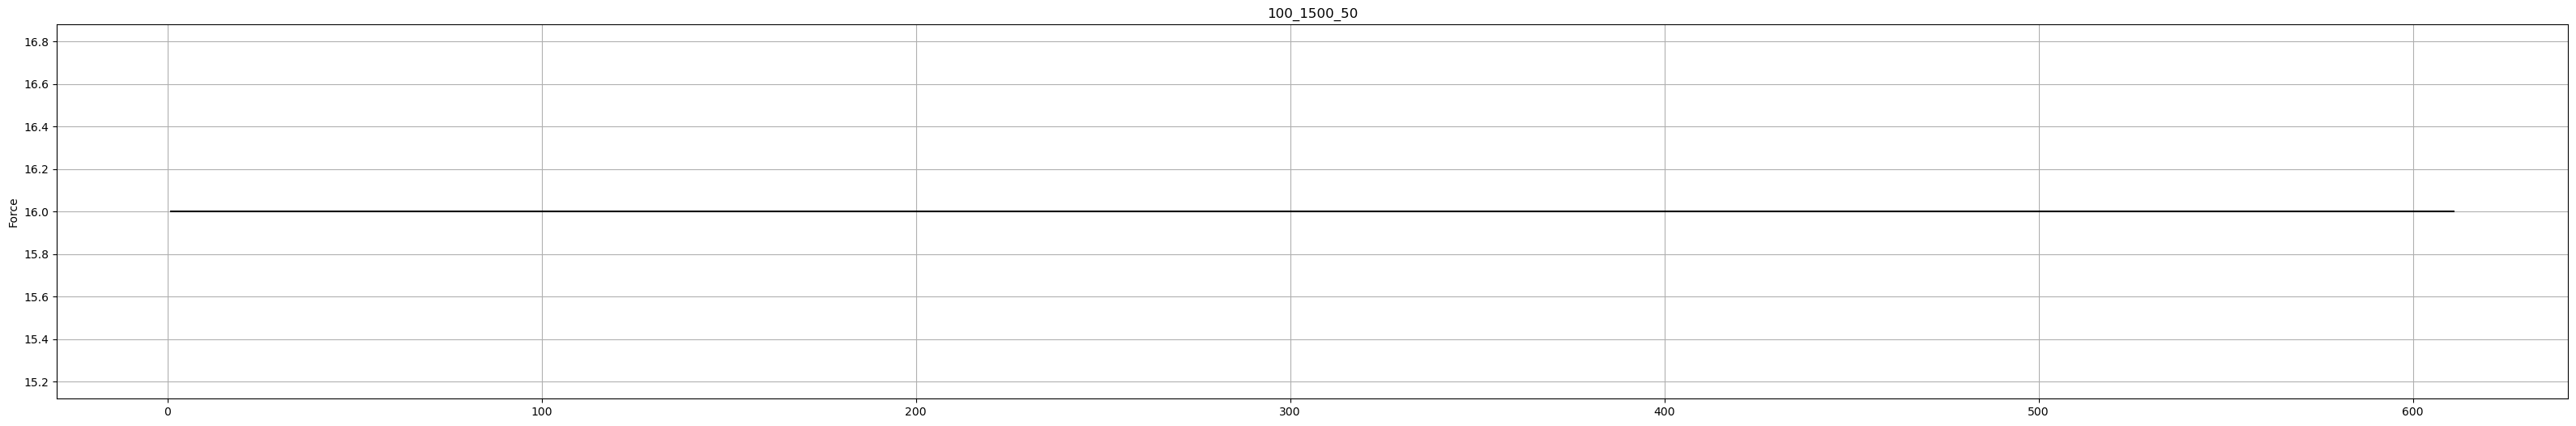

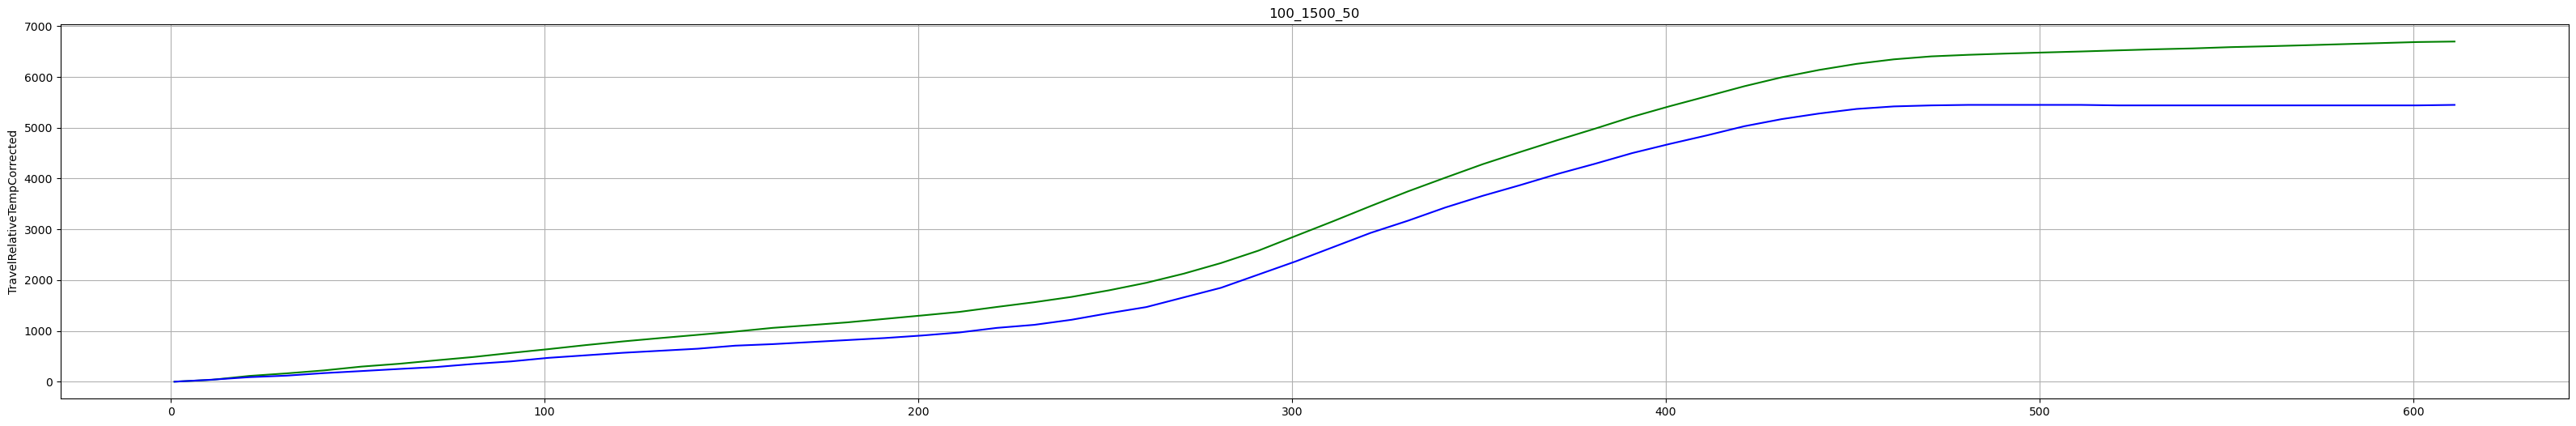

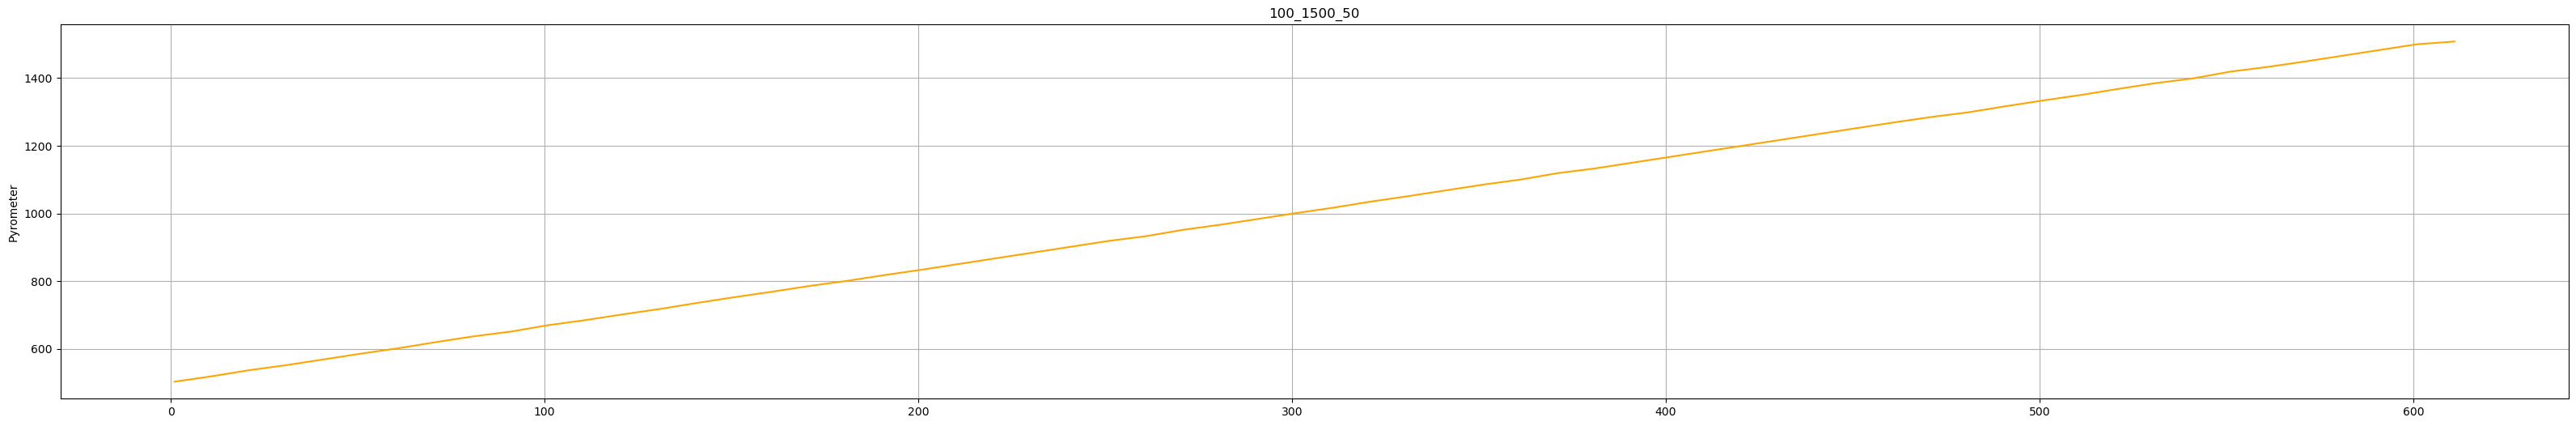

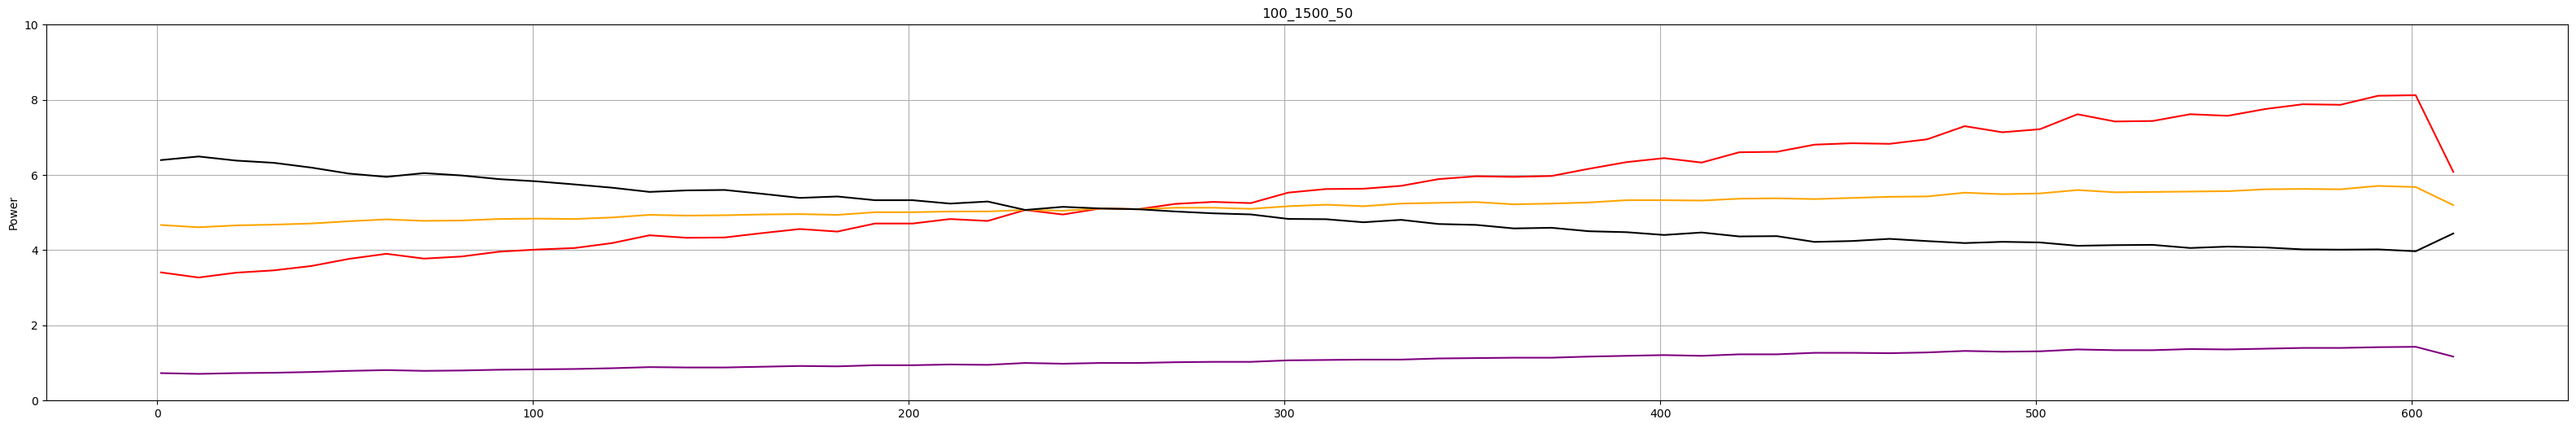

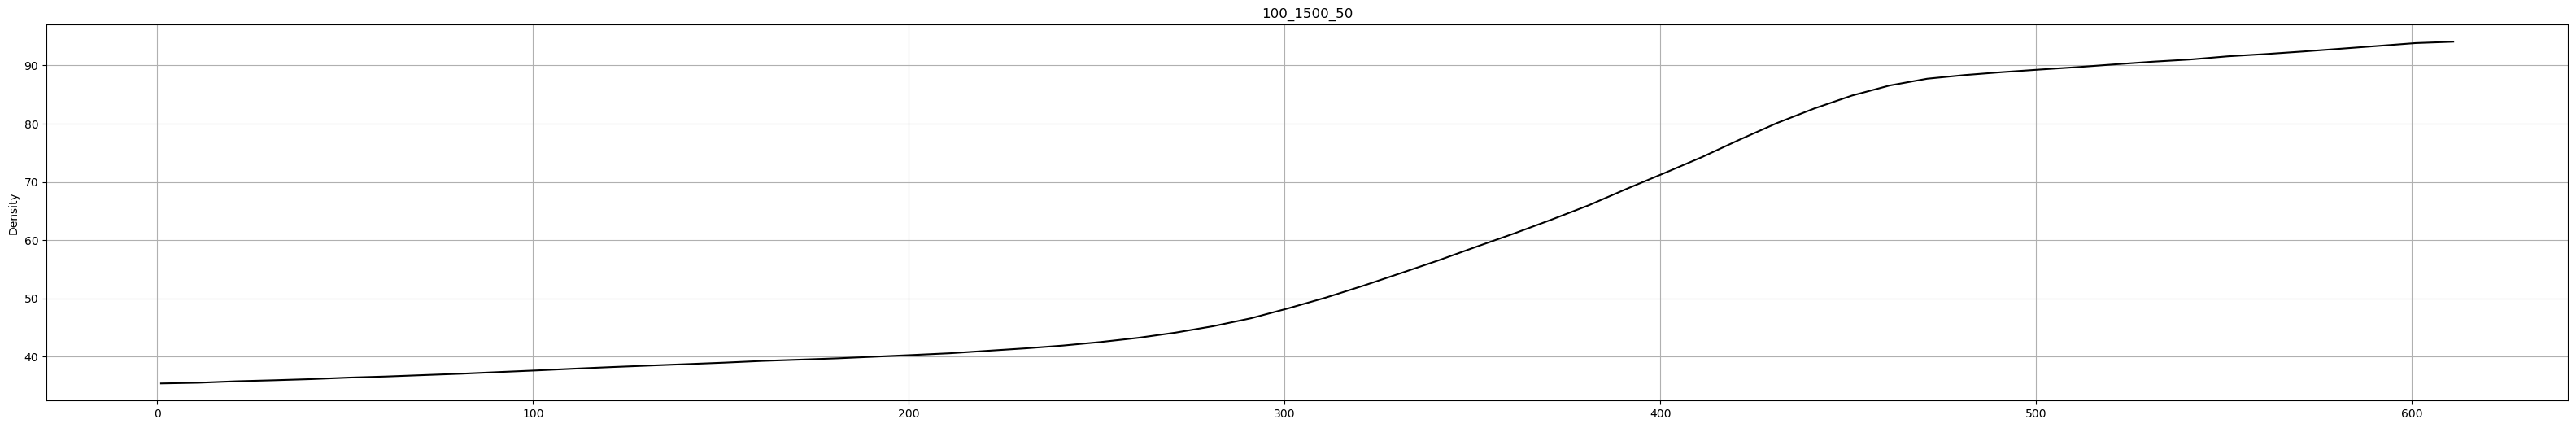

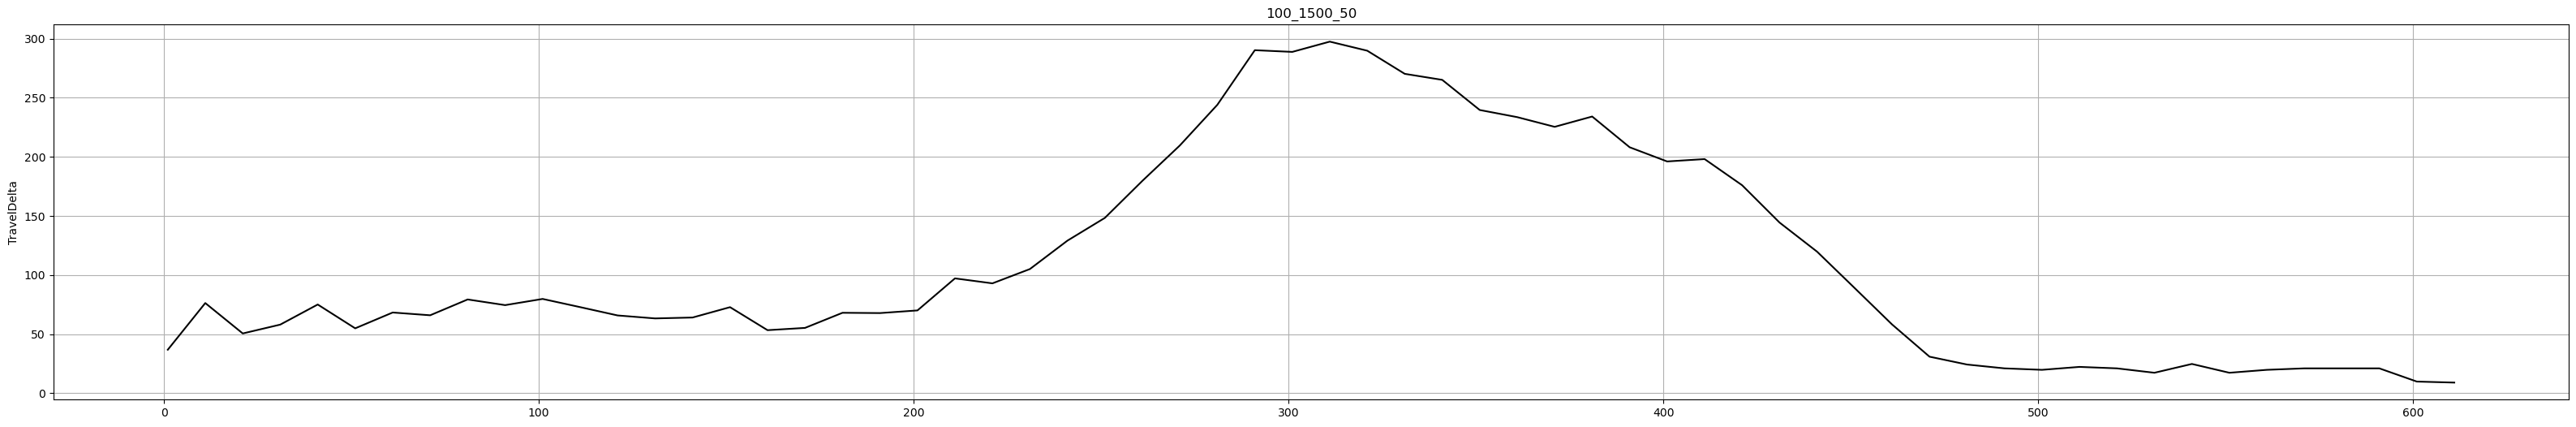

<Figure size 4000x600 with 0 Axes>

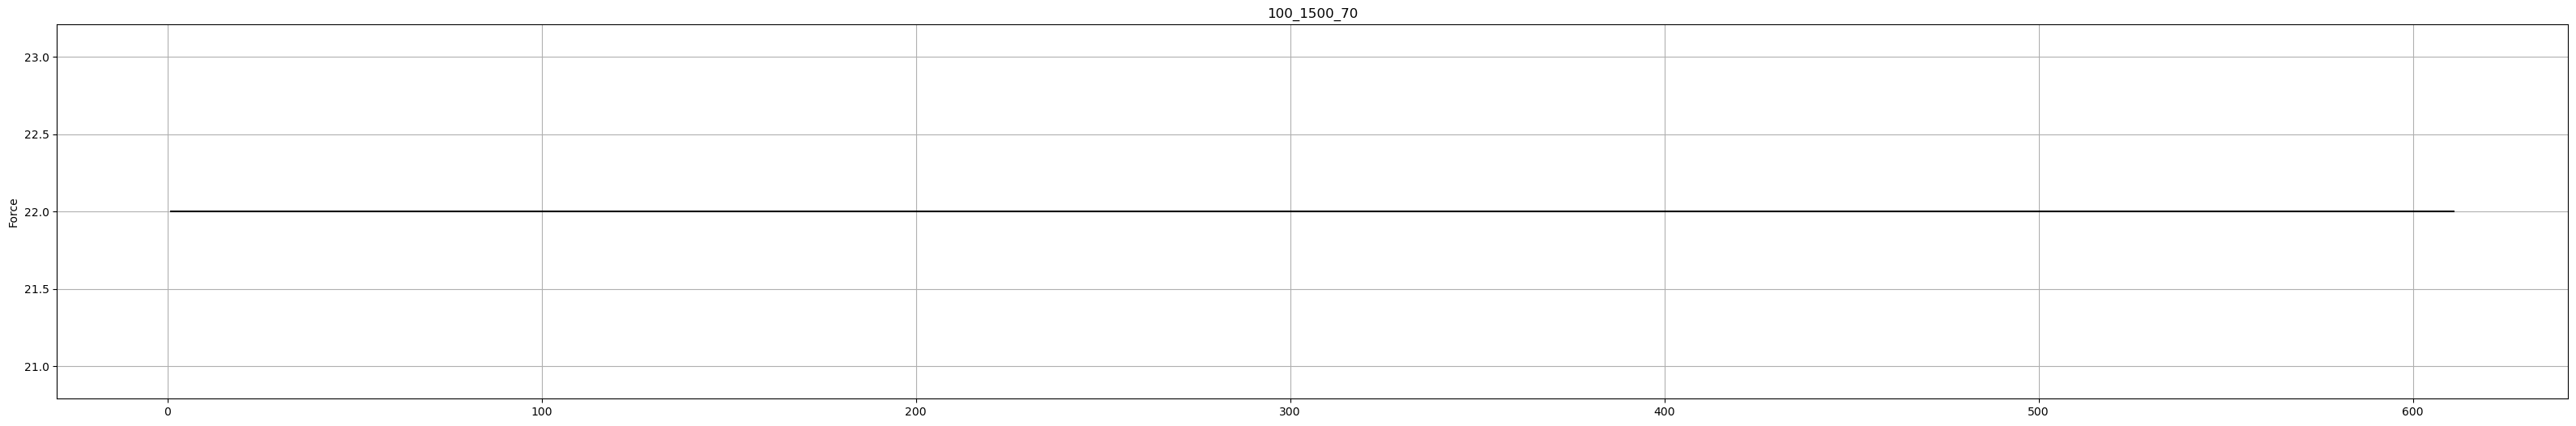

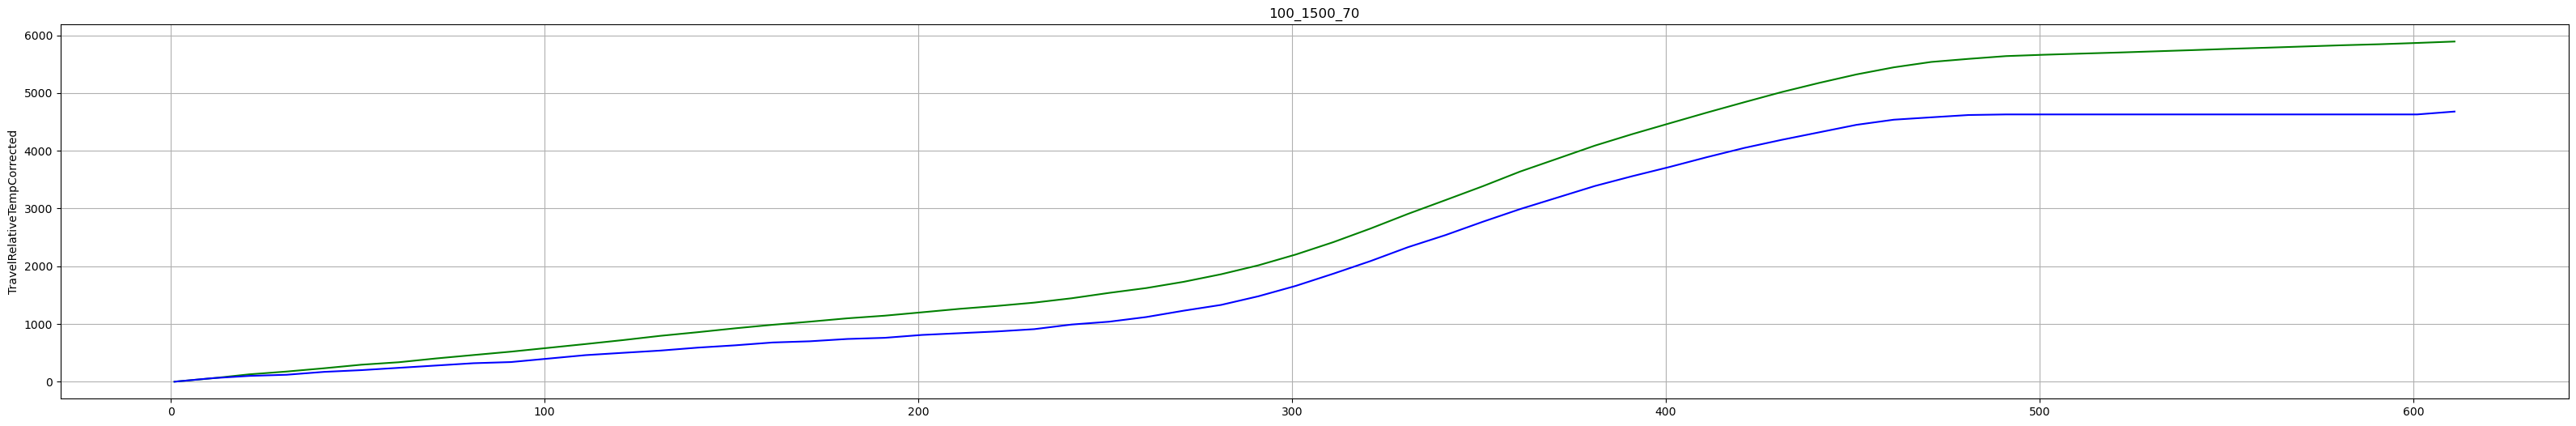

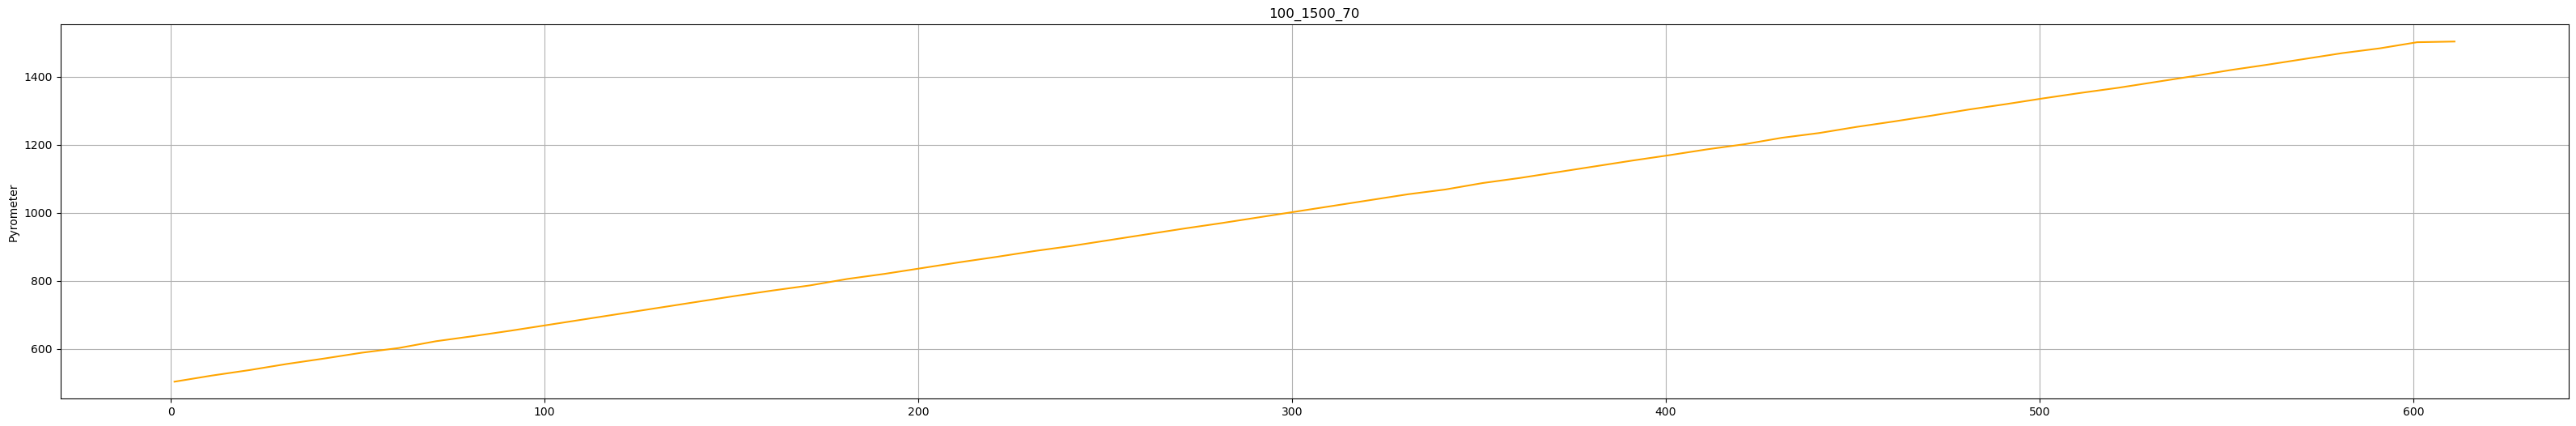

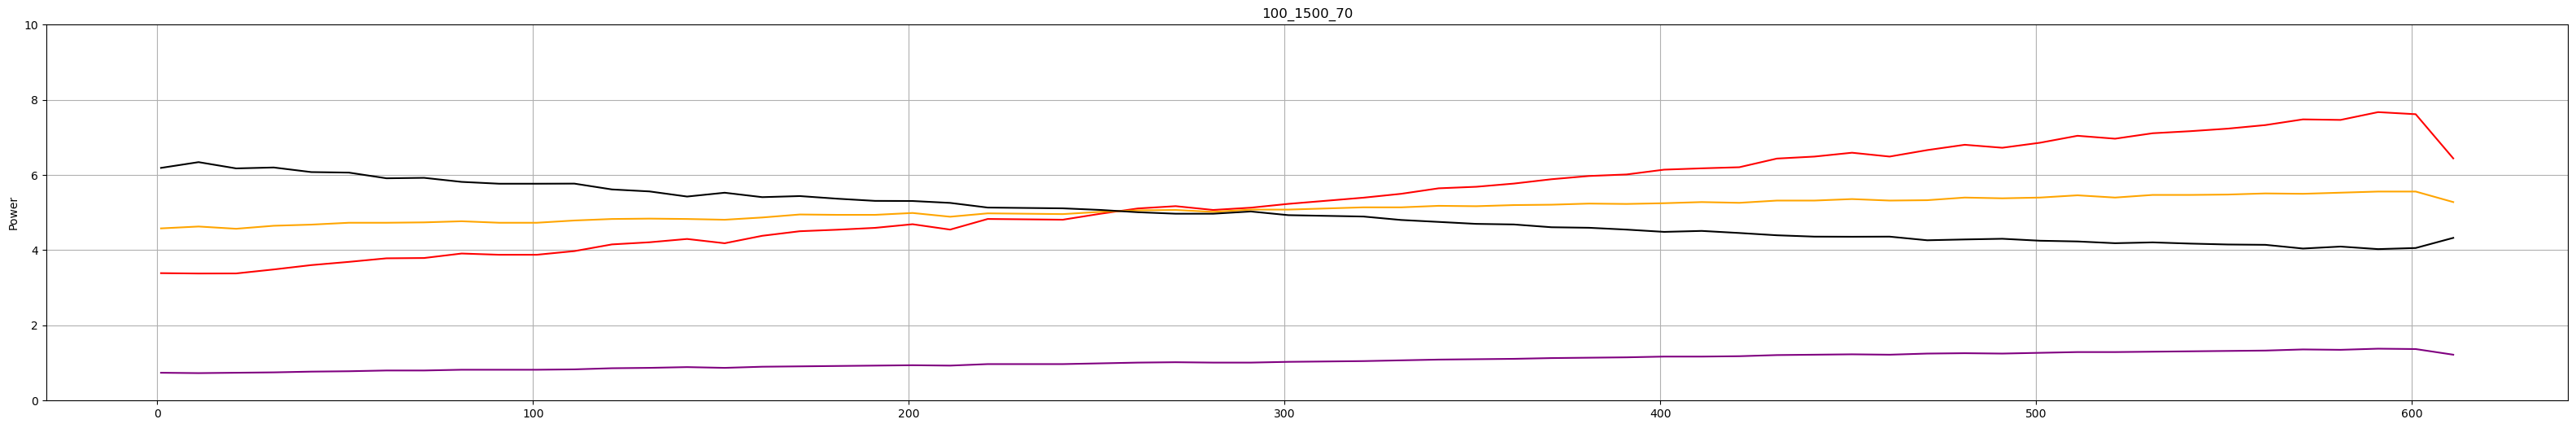

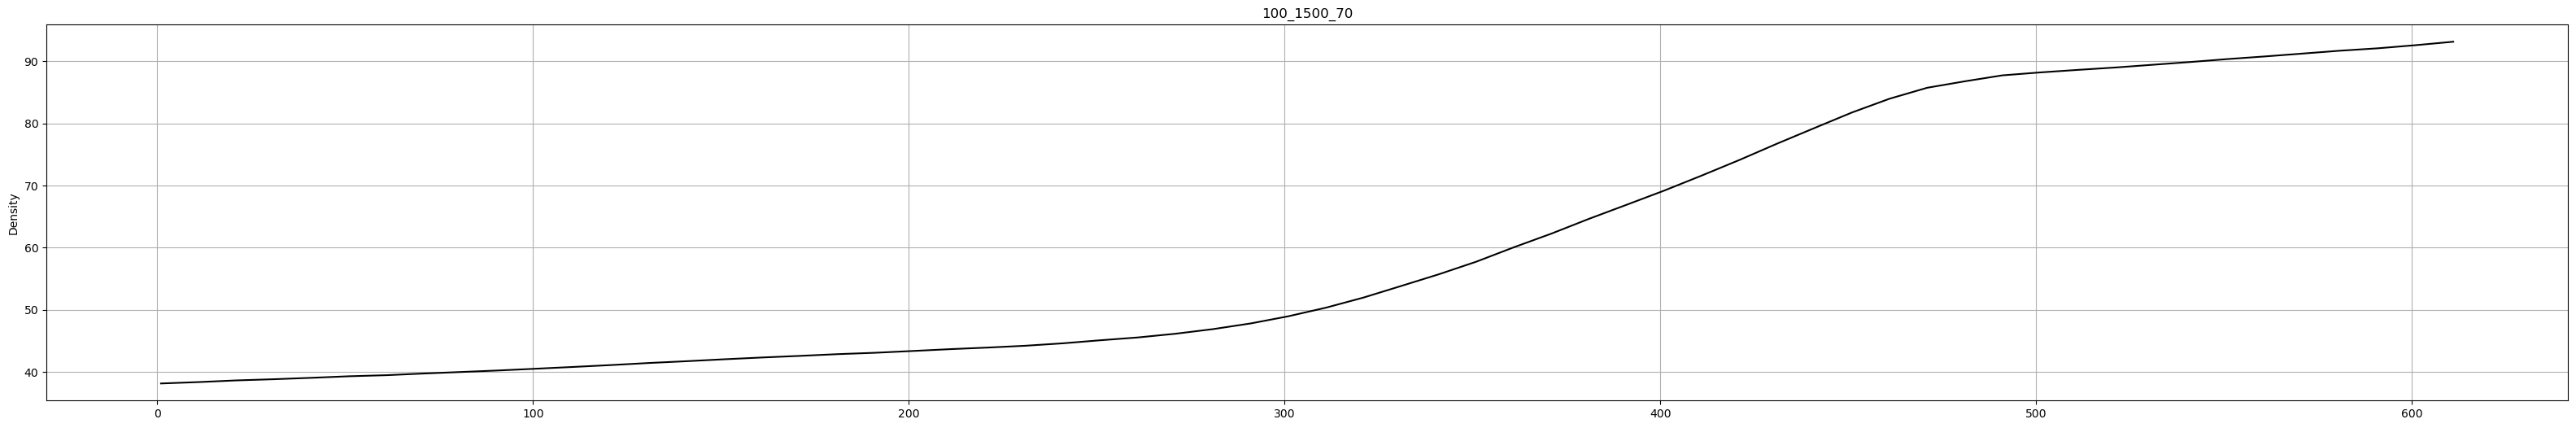

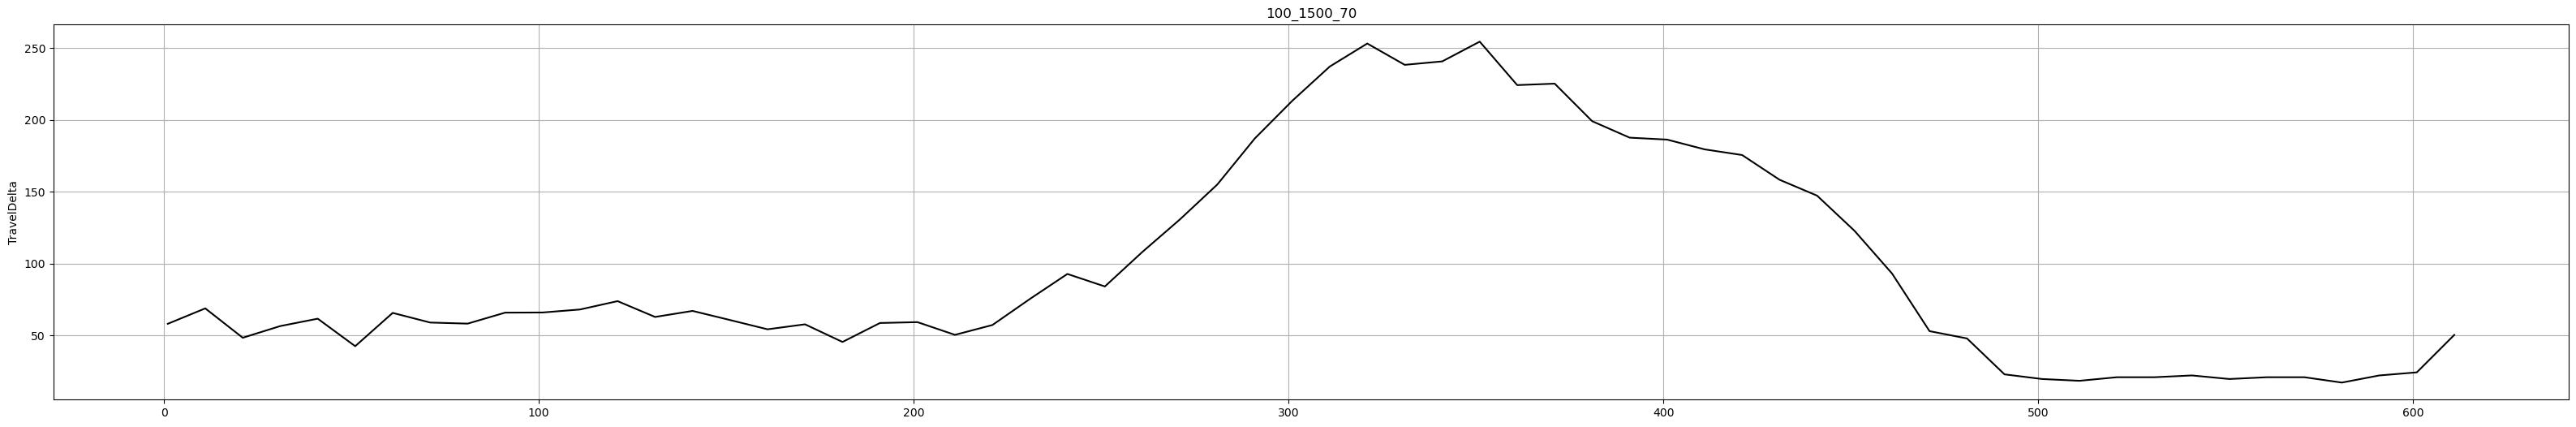

<Figure size 4000x600 with 0 Axes>

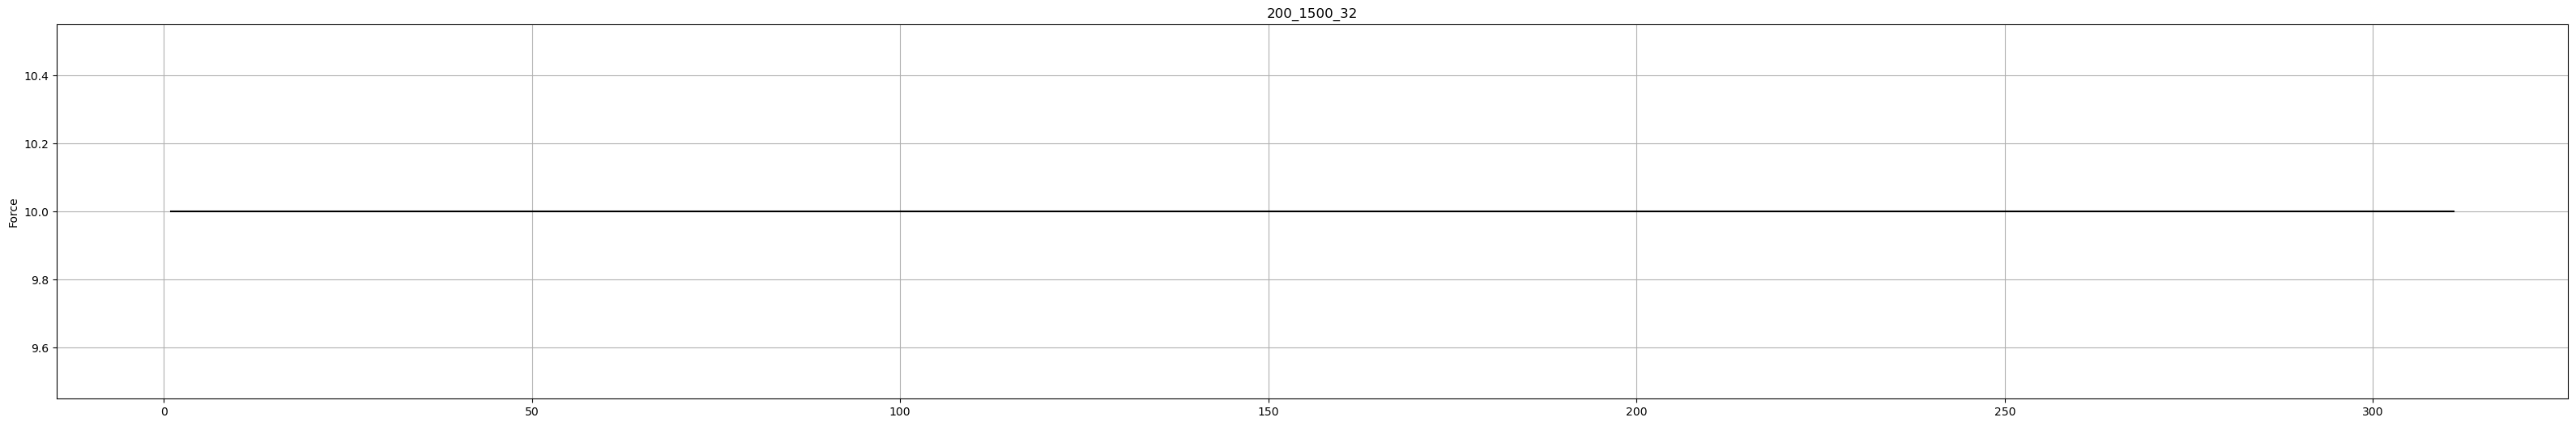

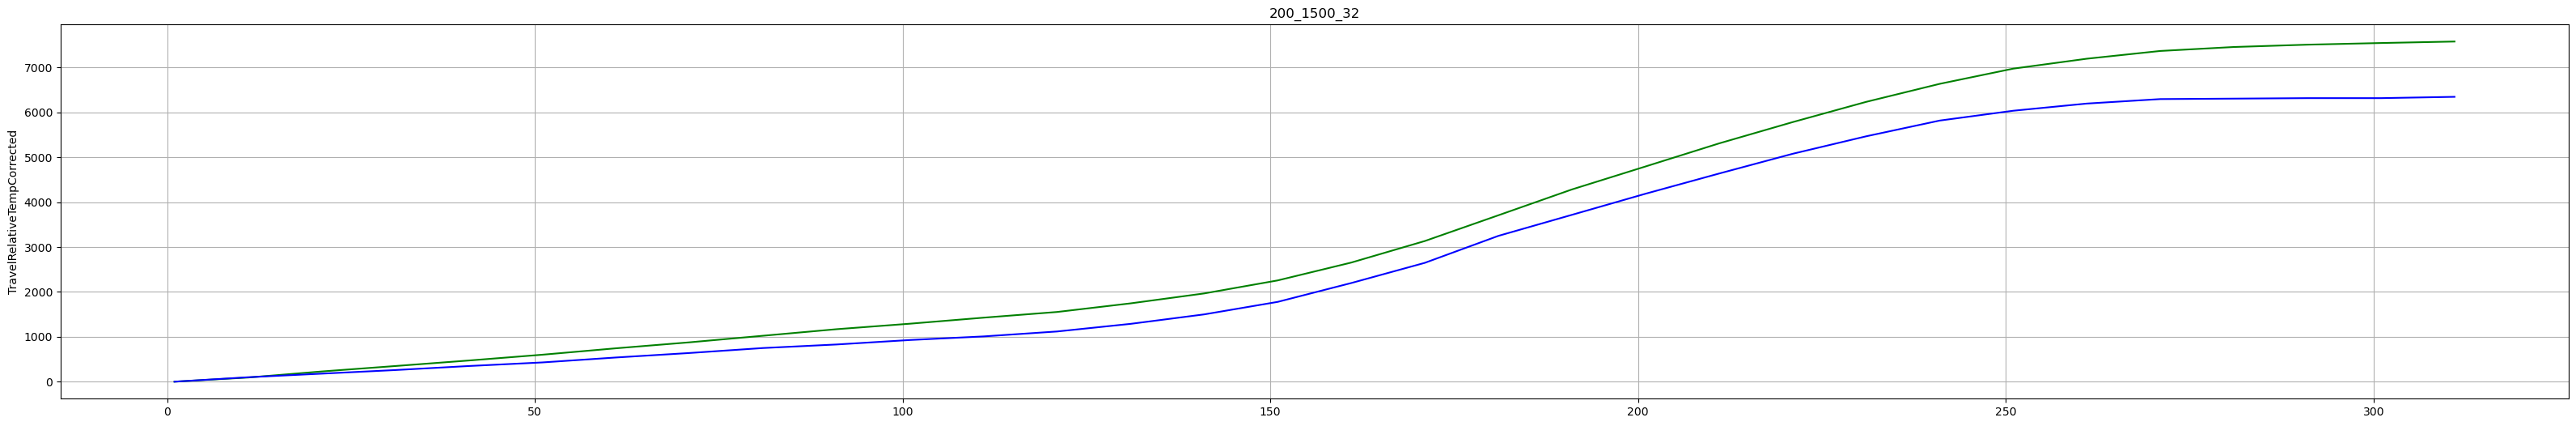

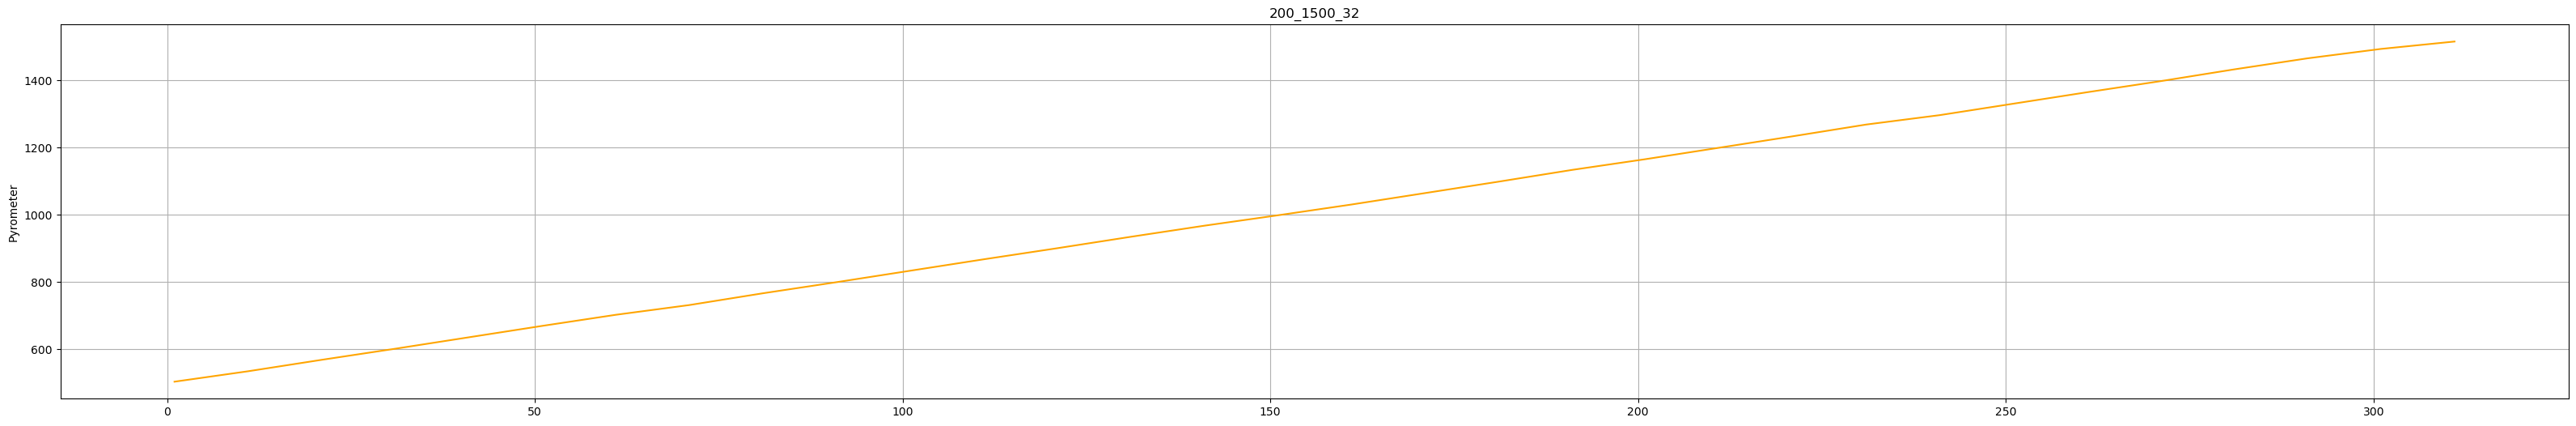

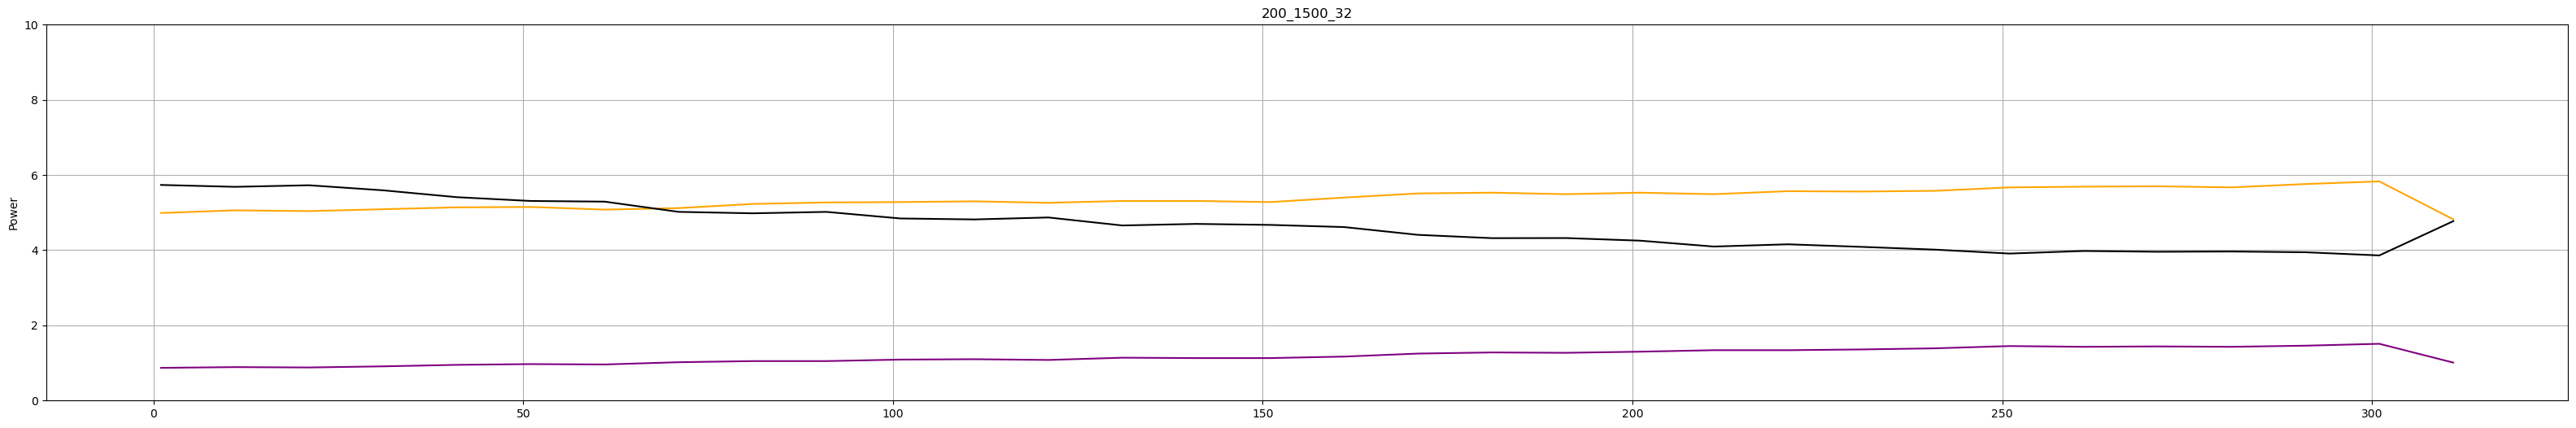

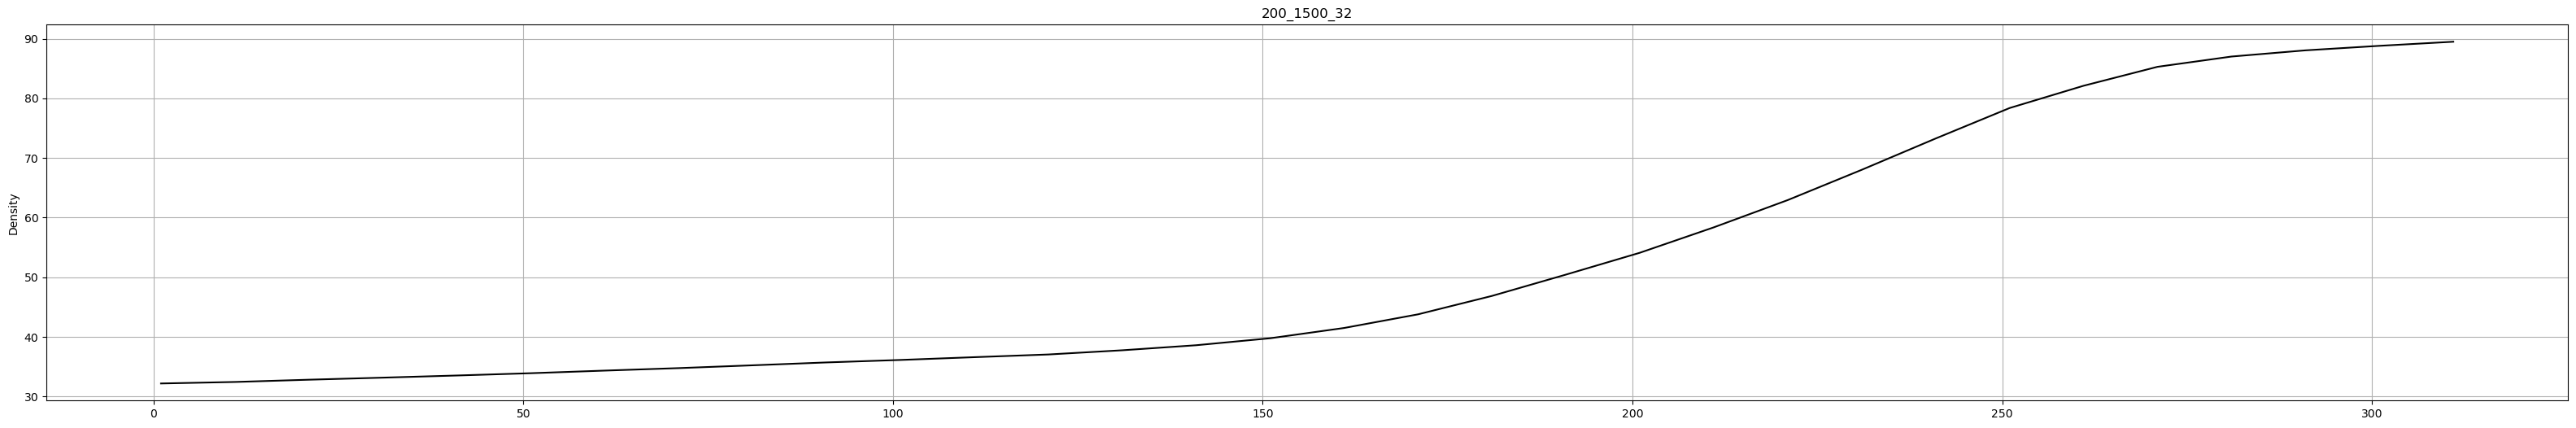

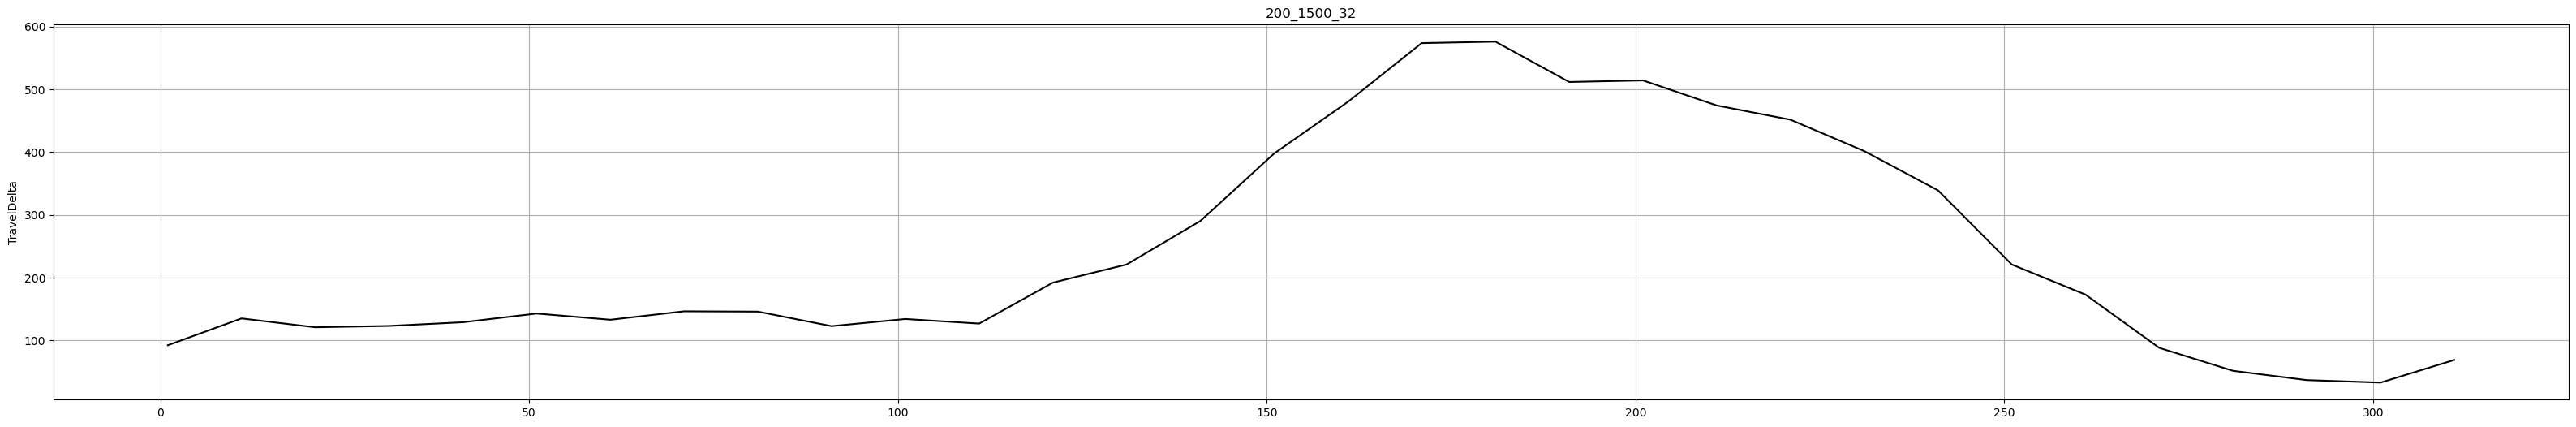

<Figure size 4000x600 with 0 Axes>

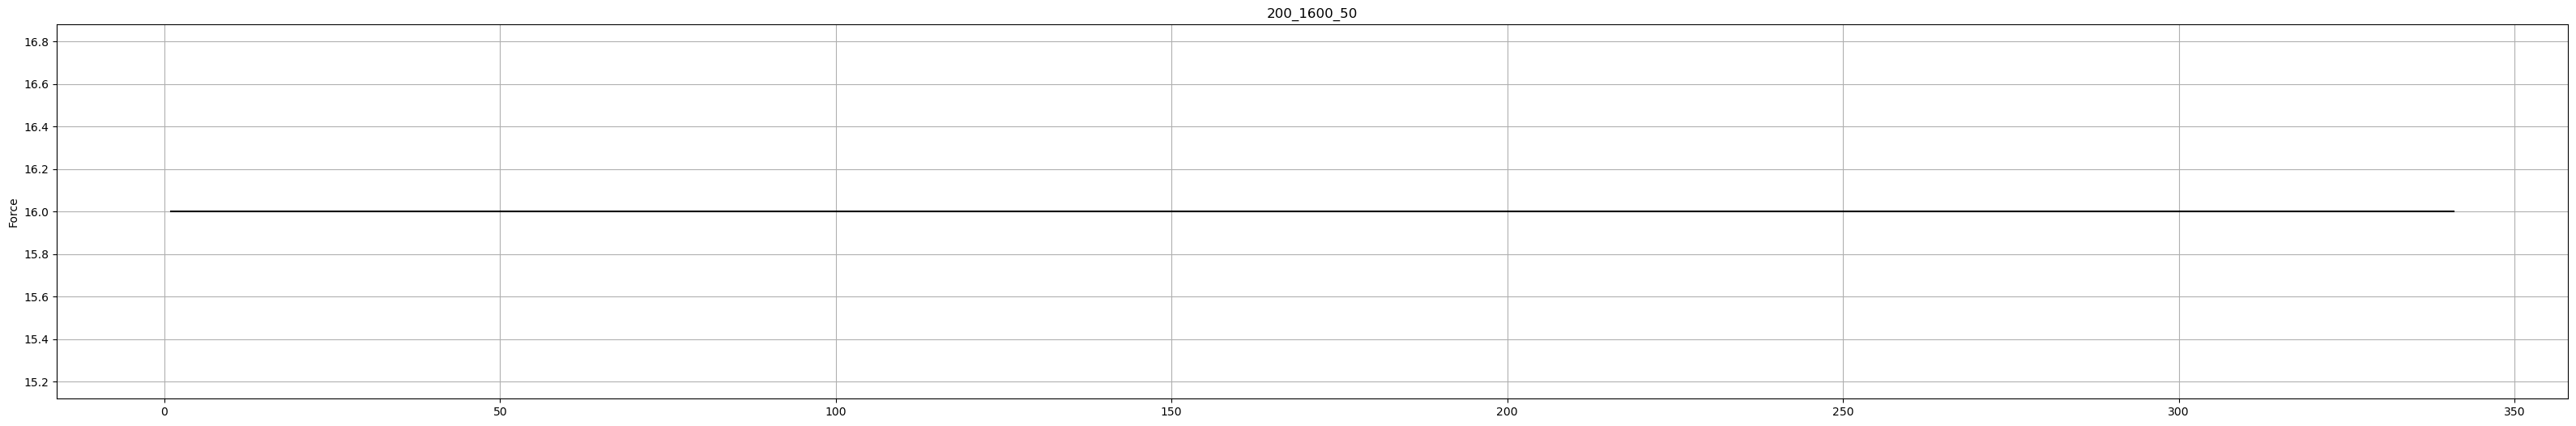

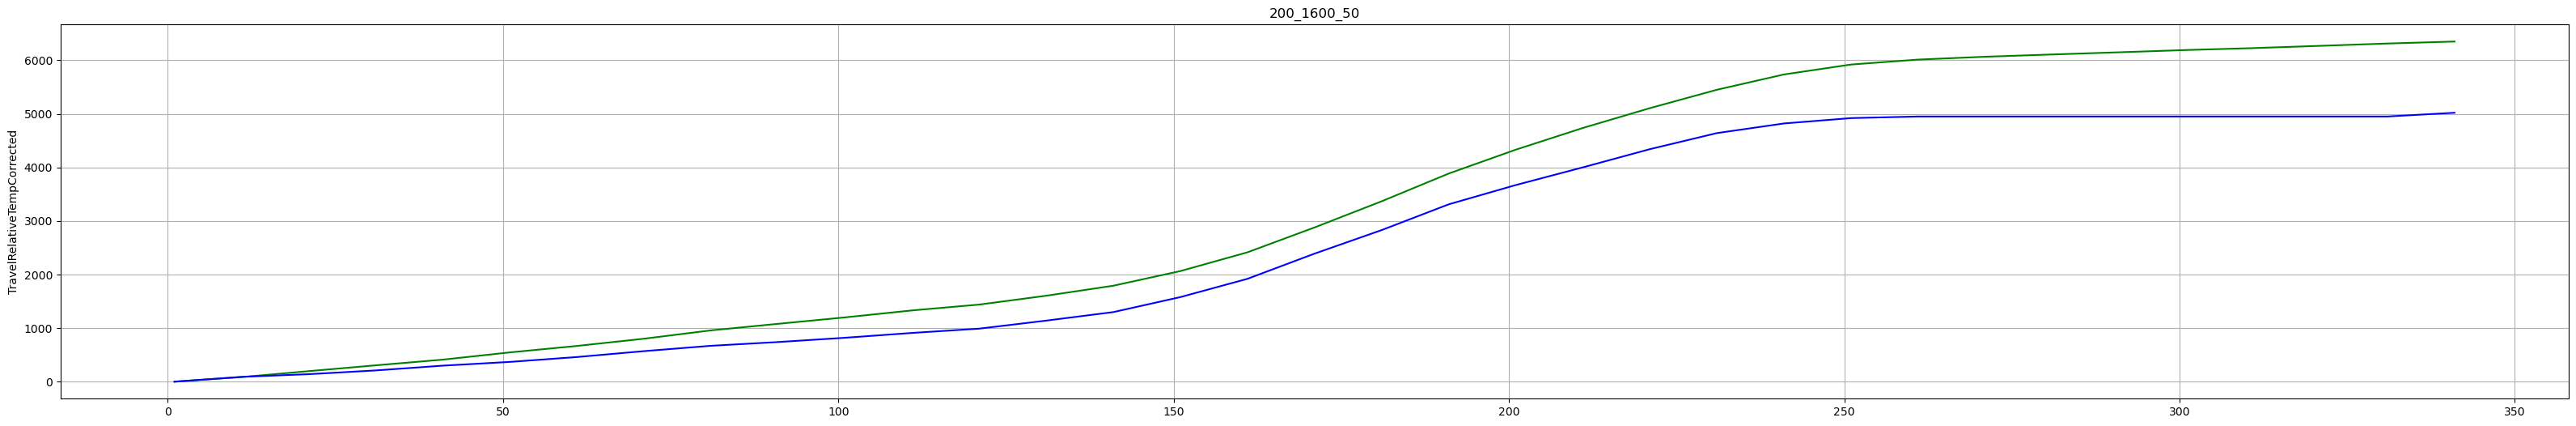

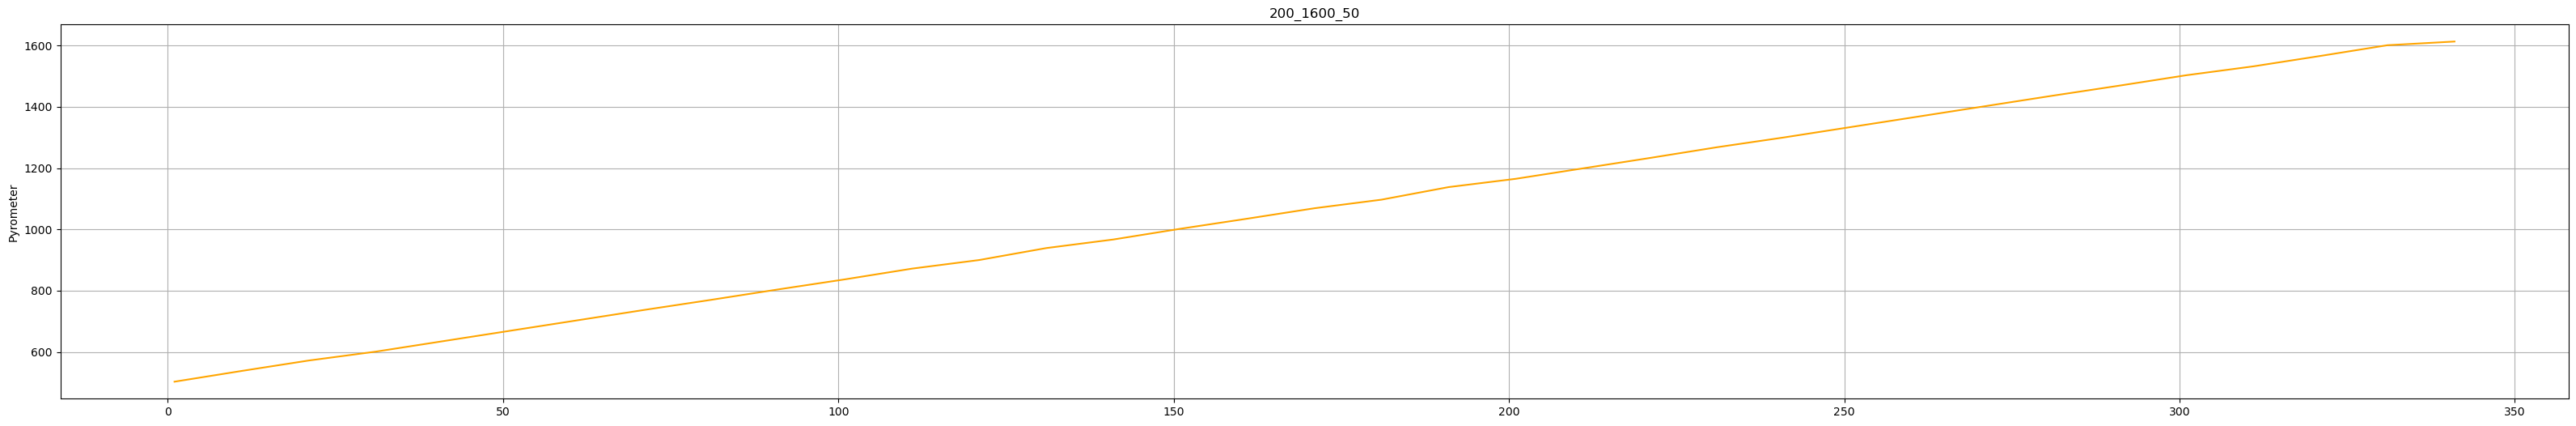

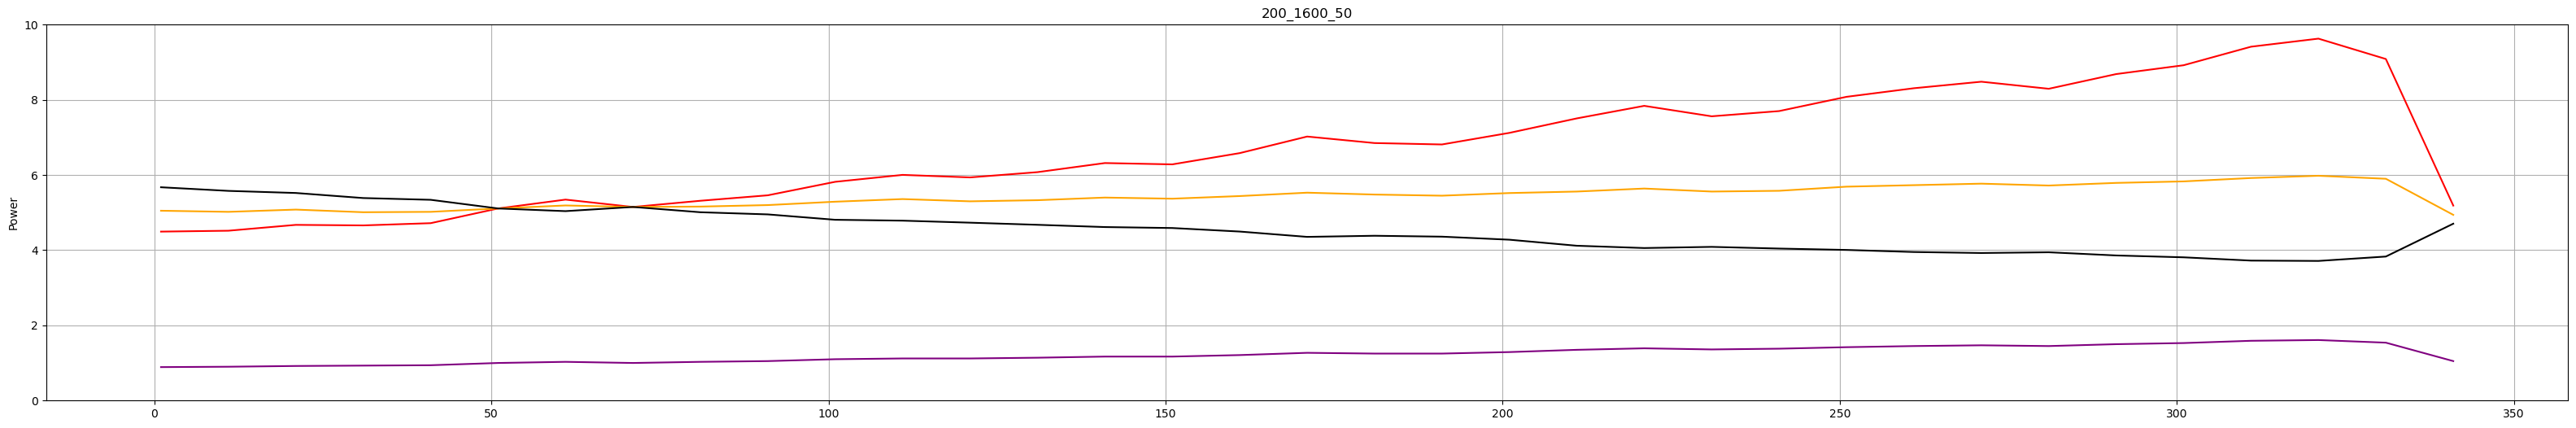

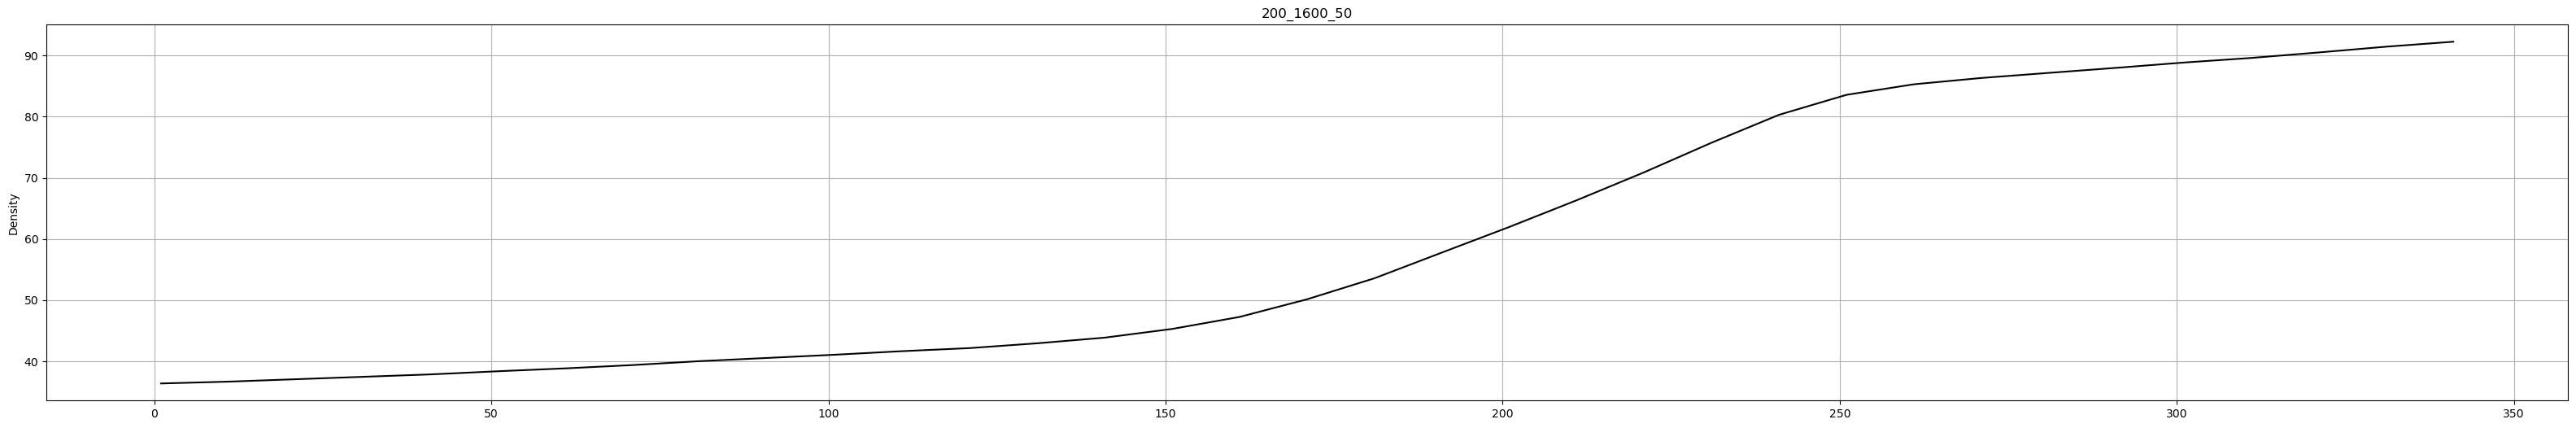

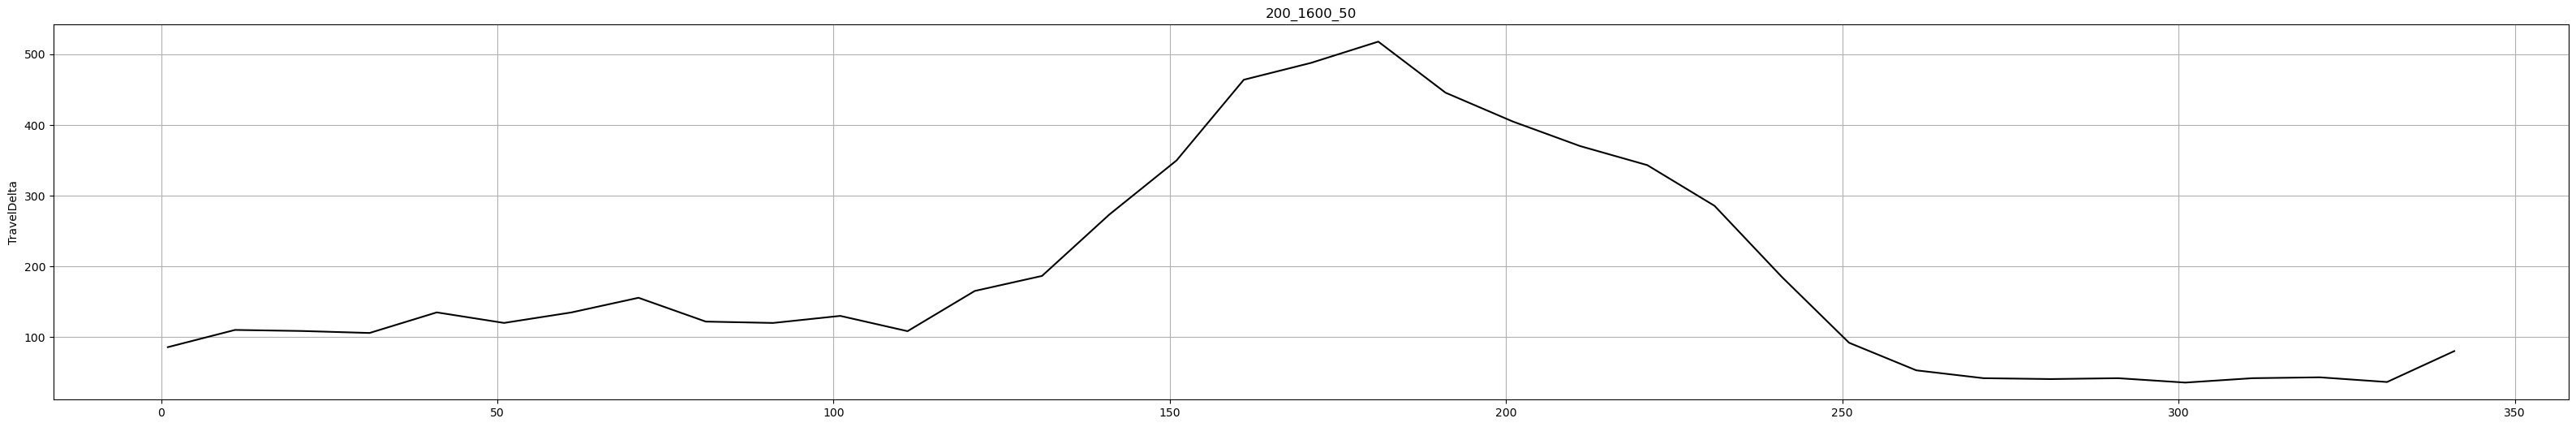

<Figure size 4000x600 with 0 Axes>

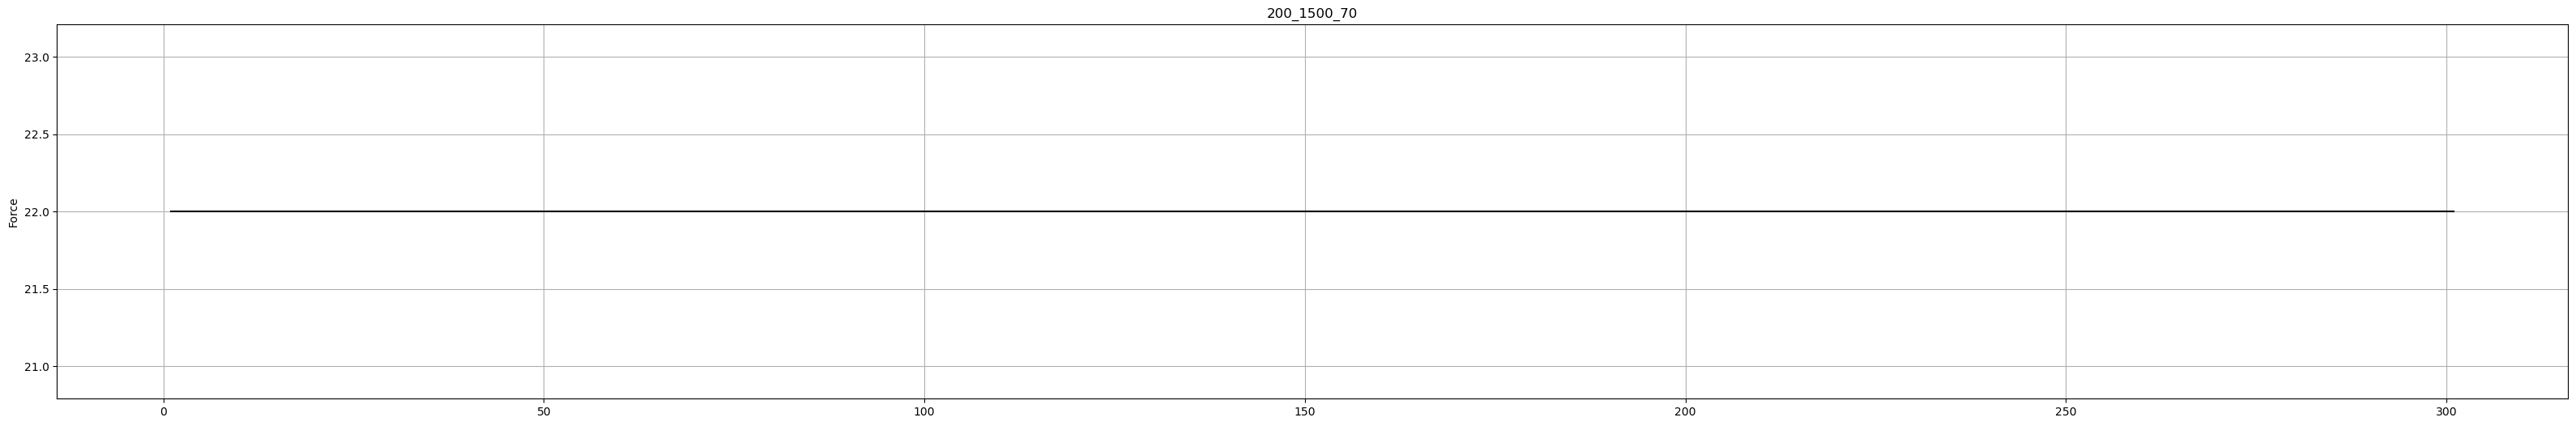

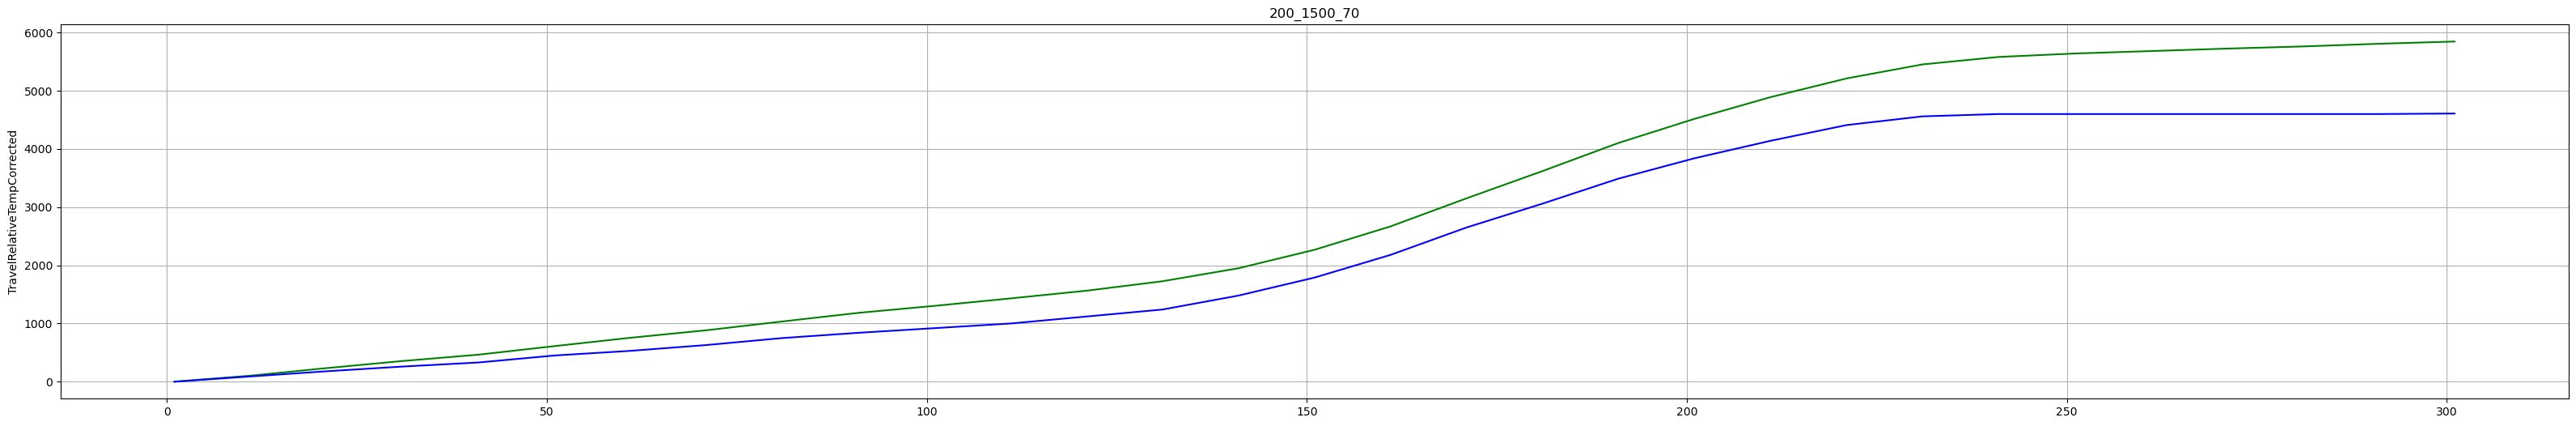

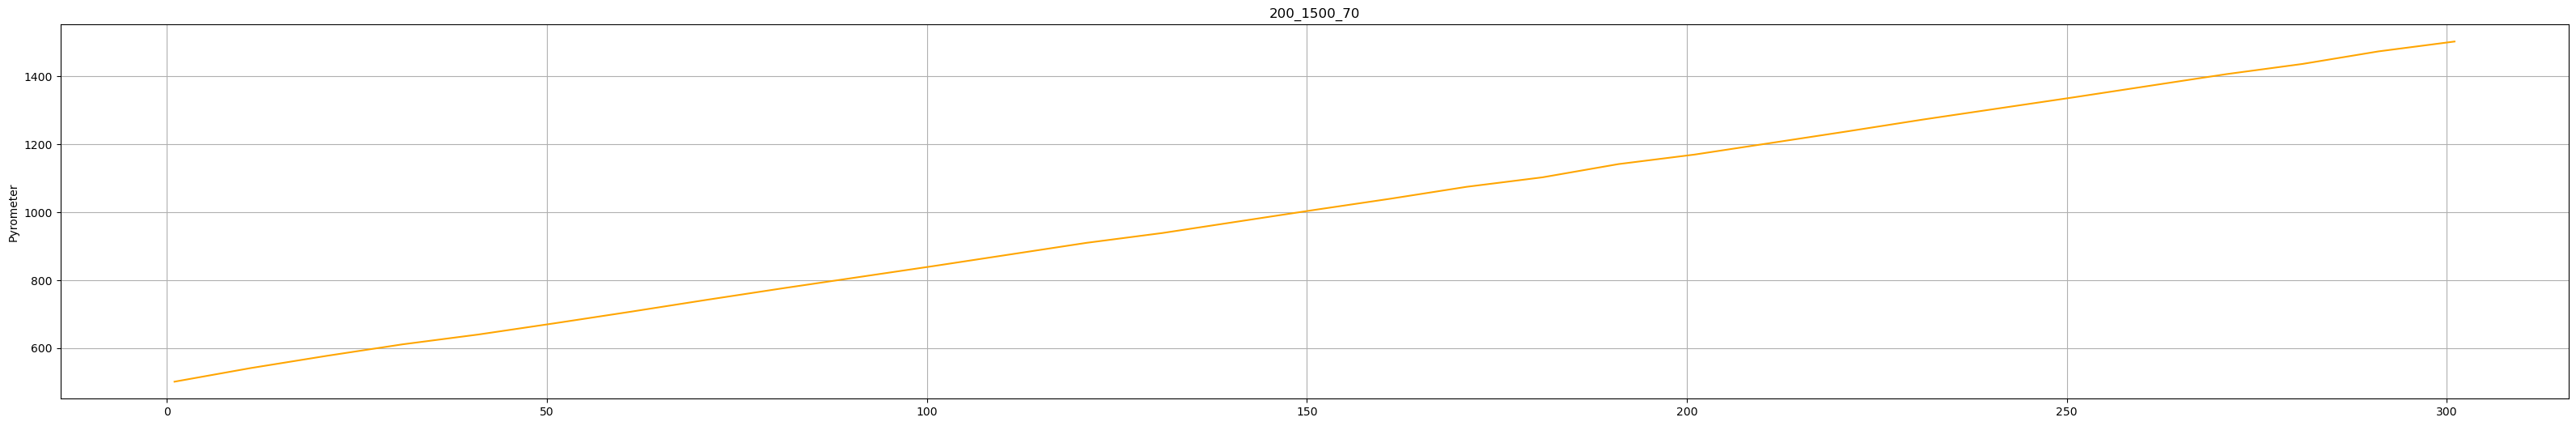

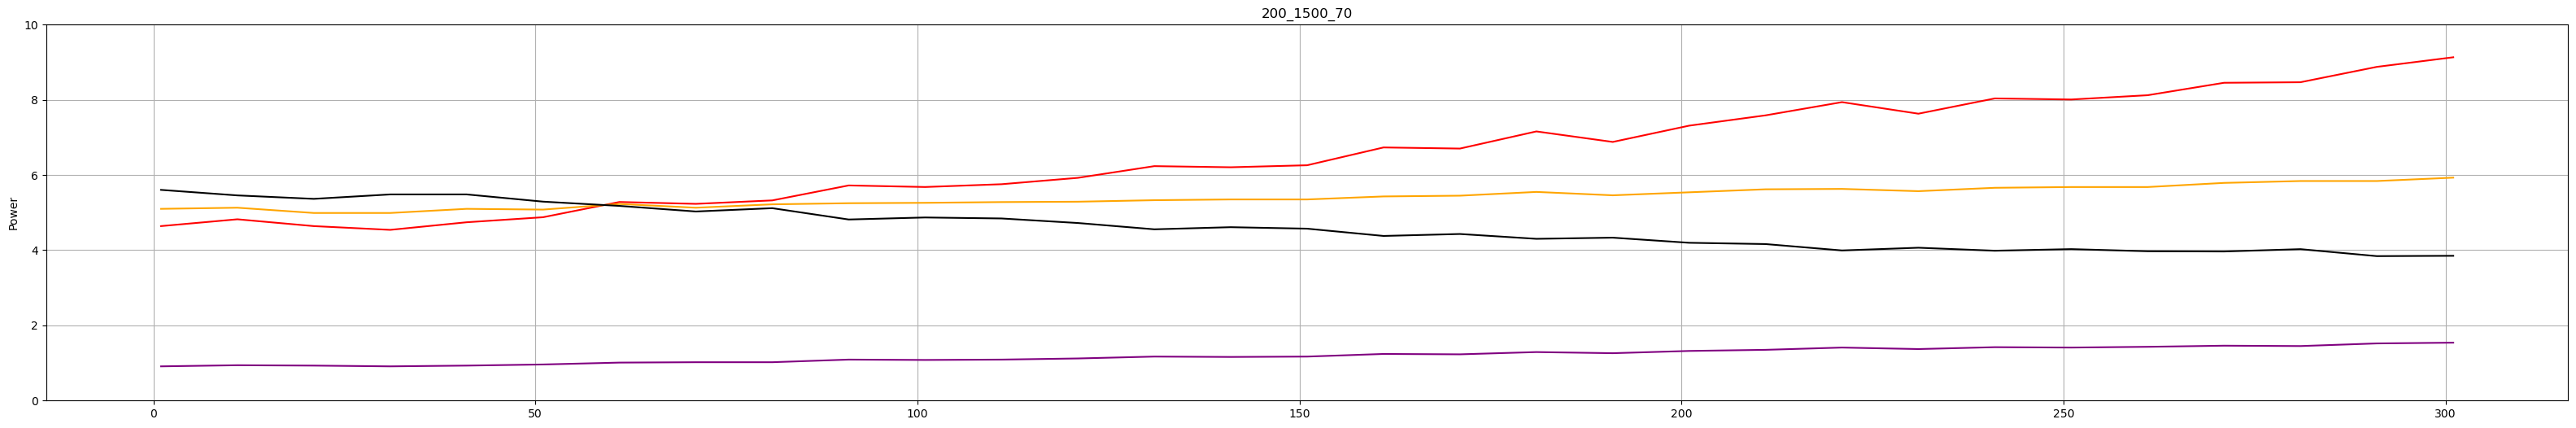

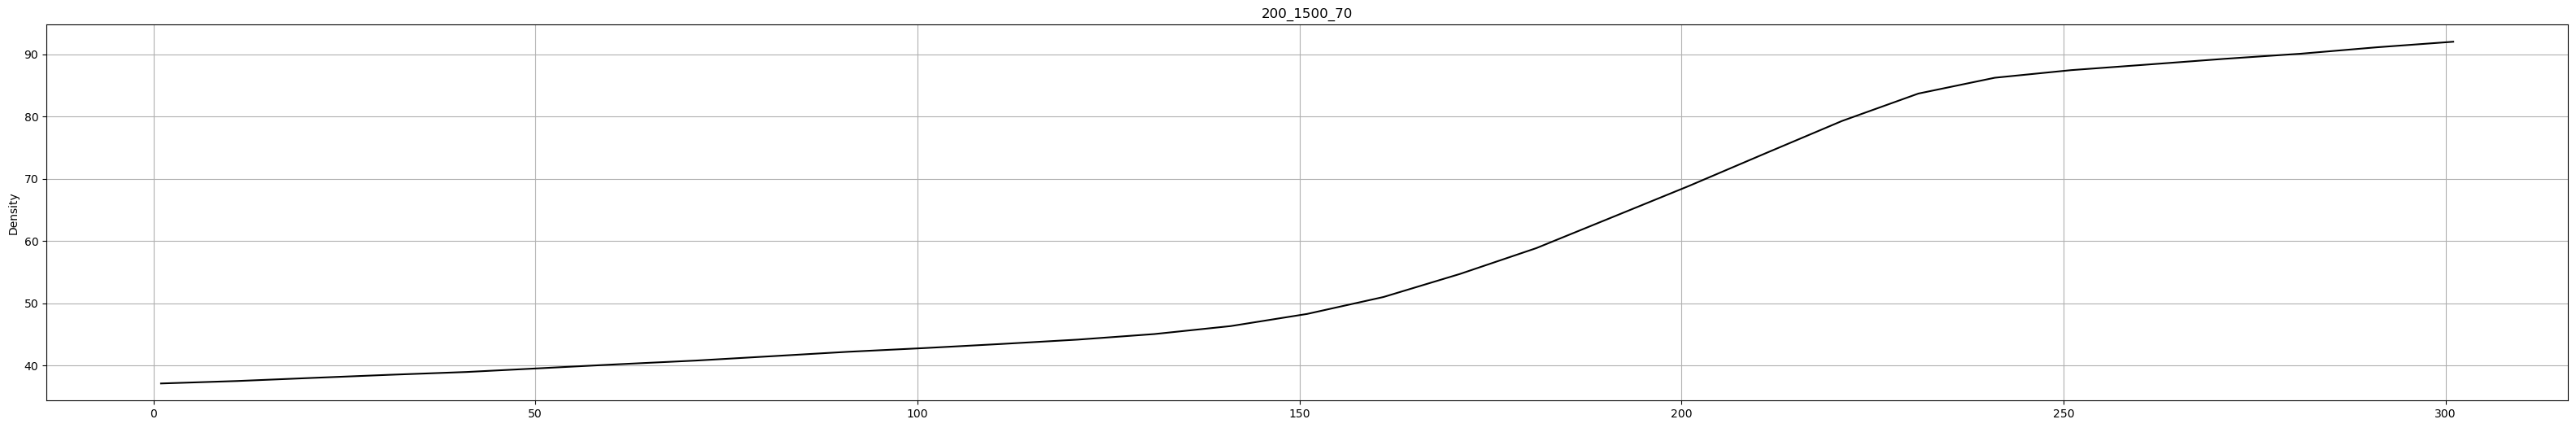

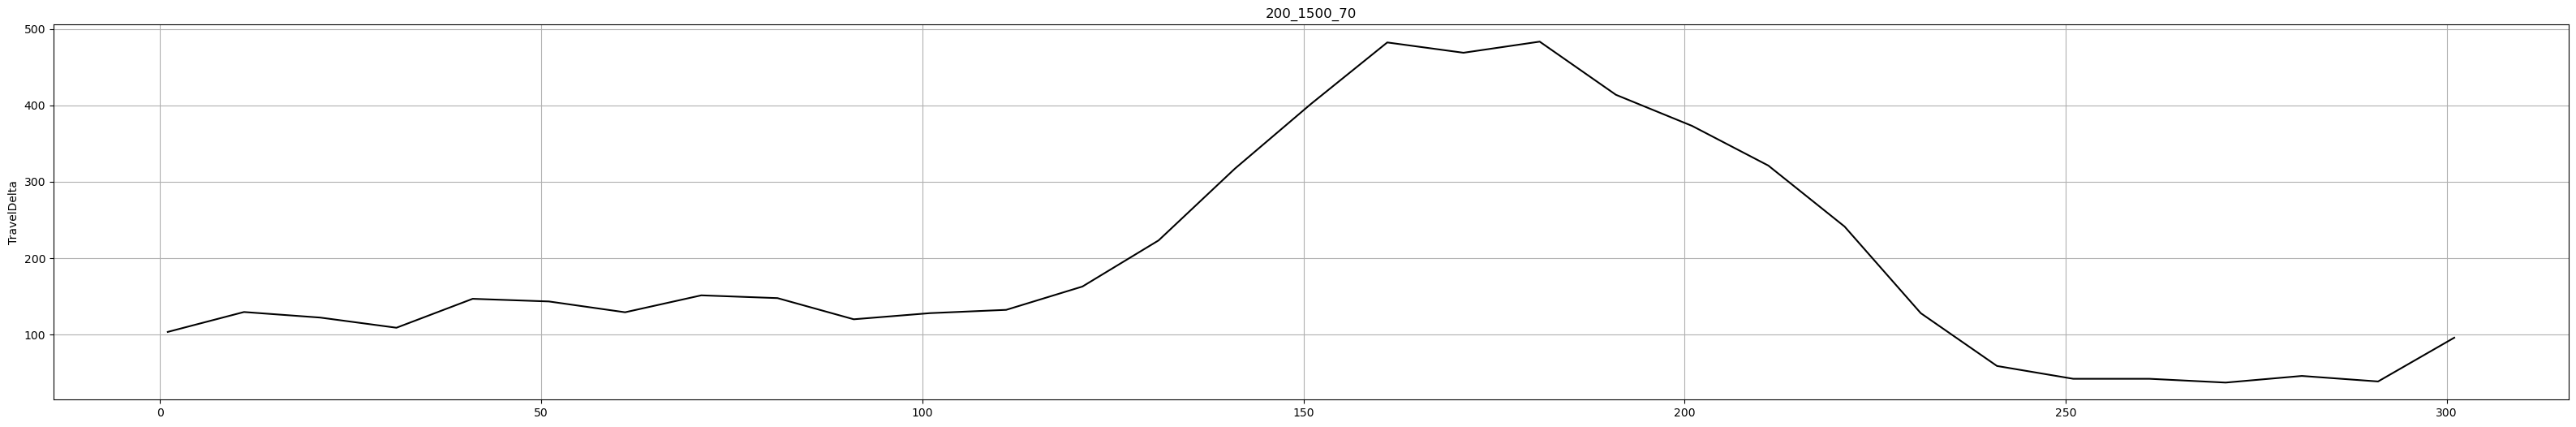

<Figure size 4000x600 with 0 Axes>

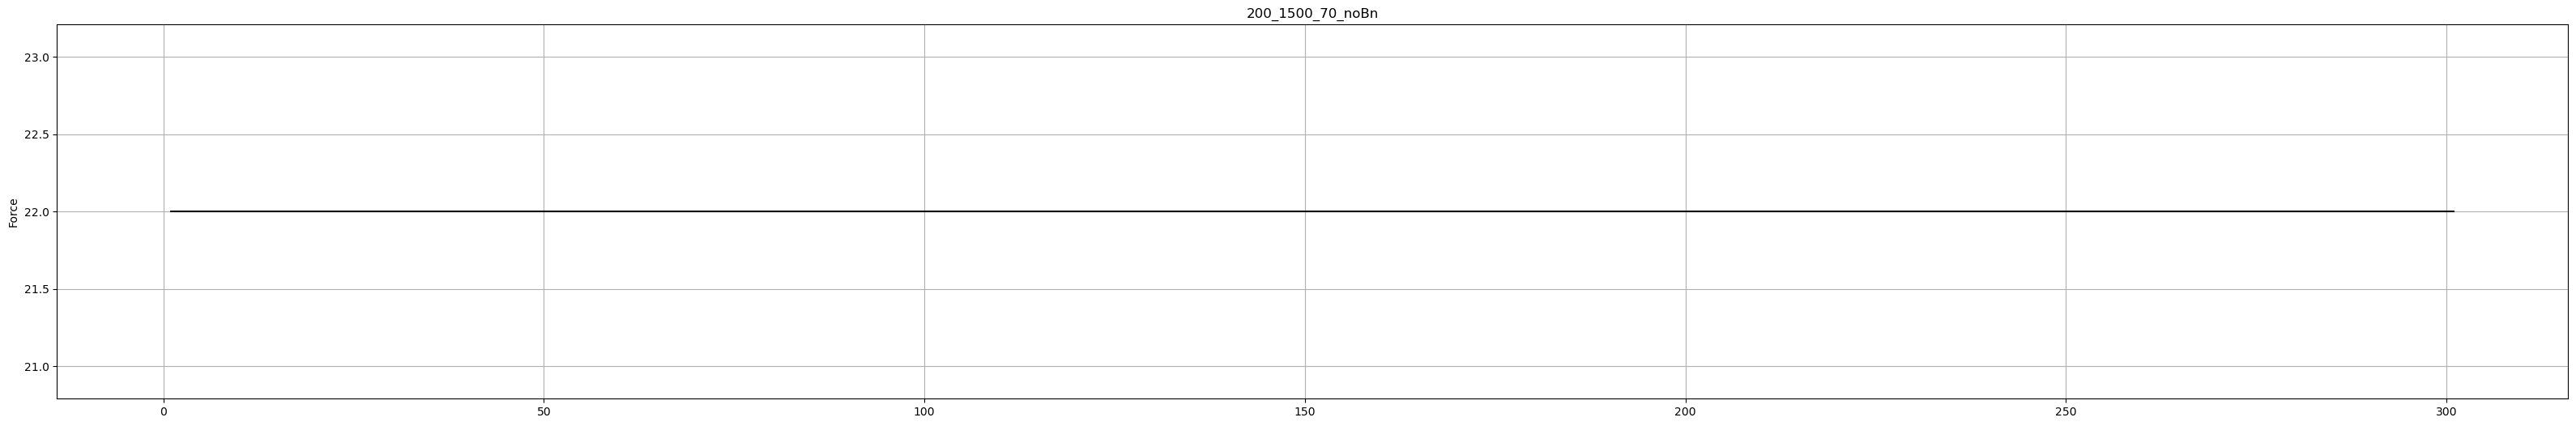

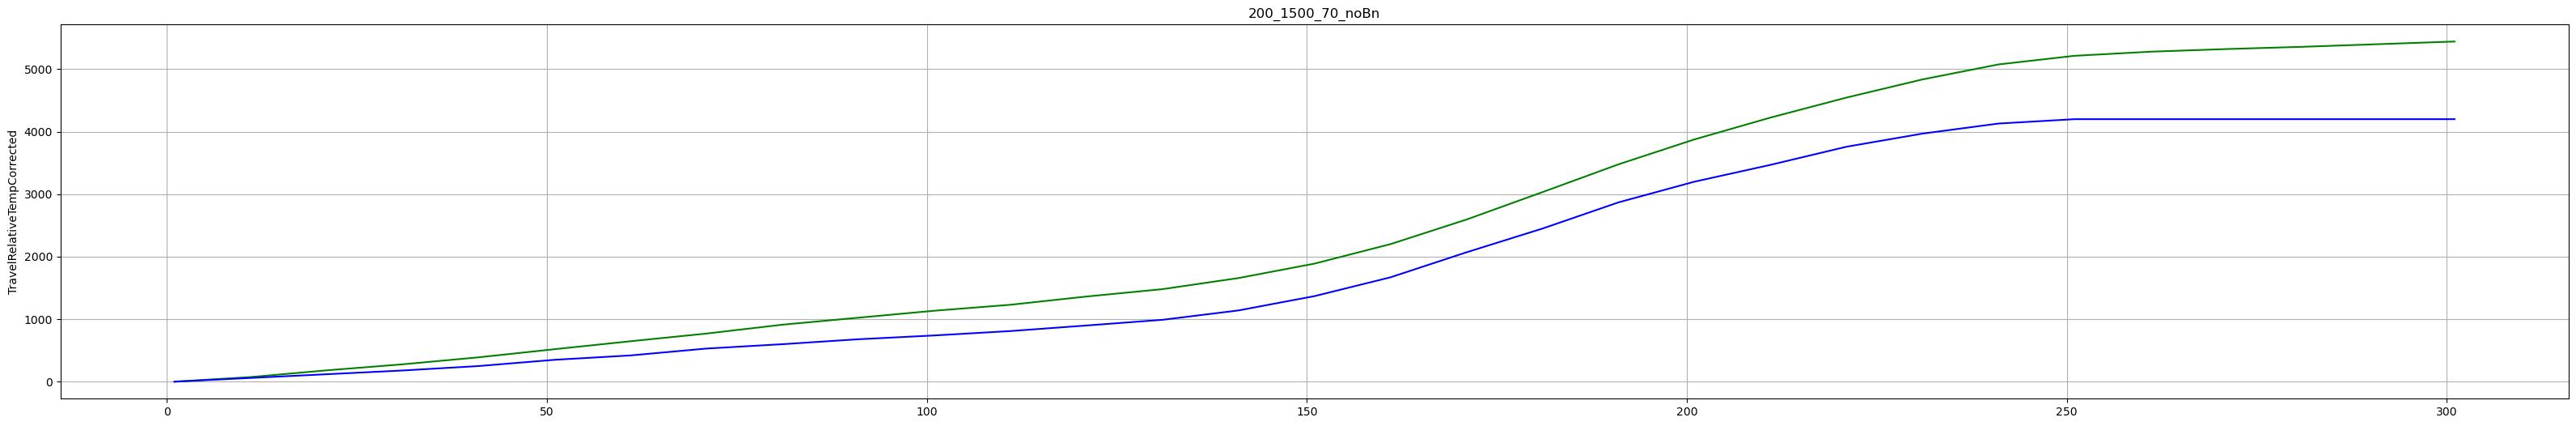

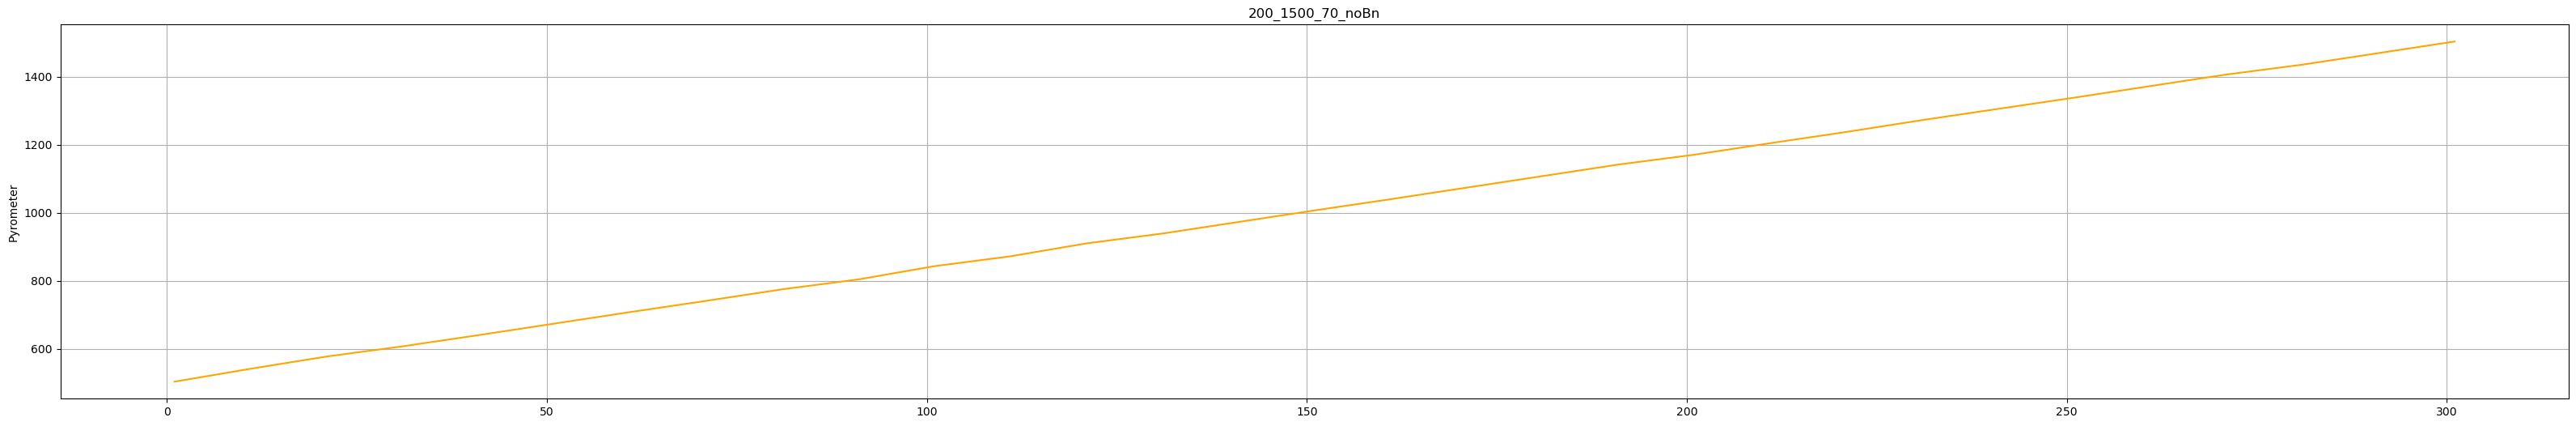

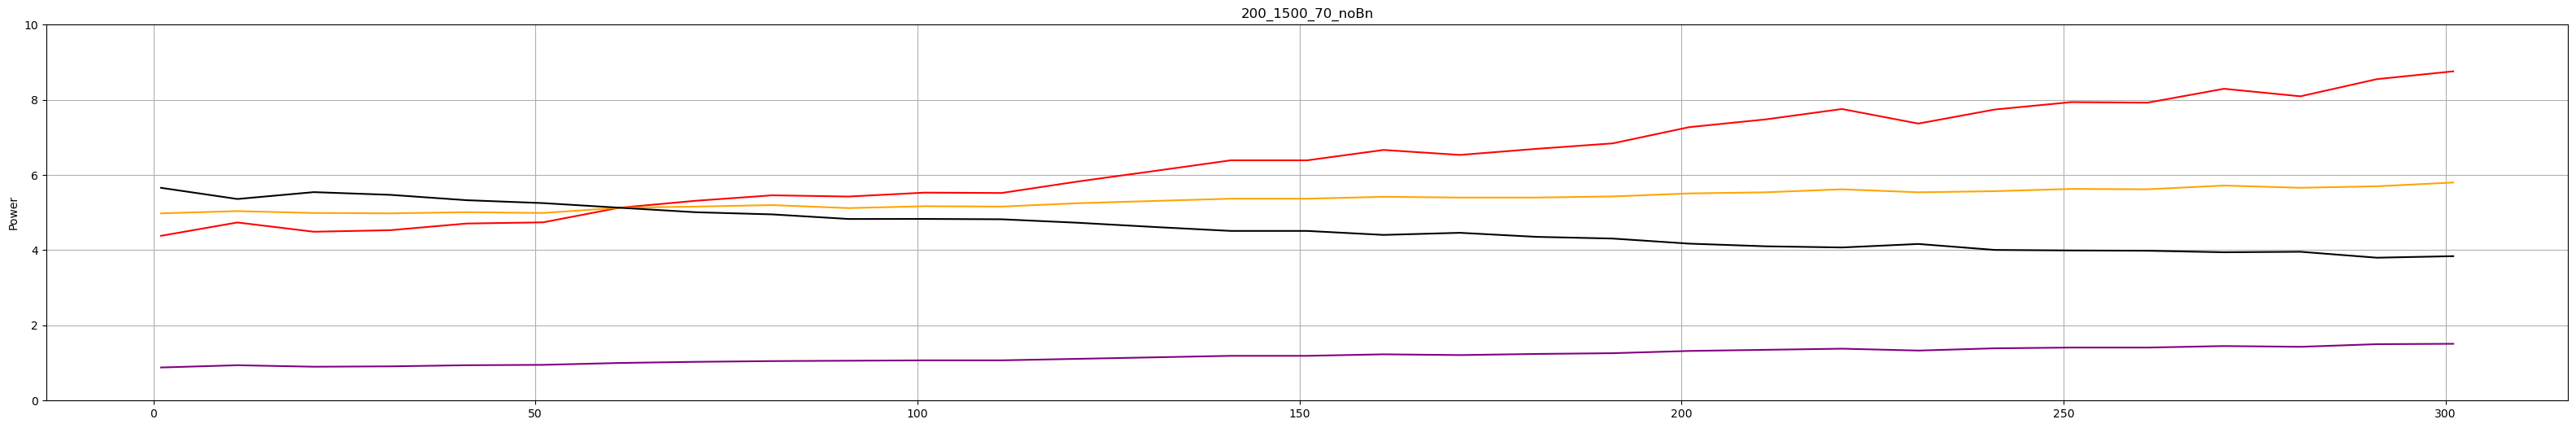

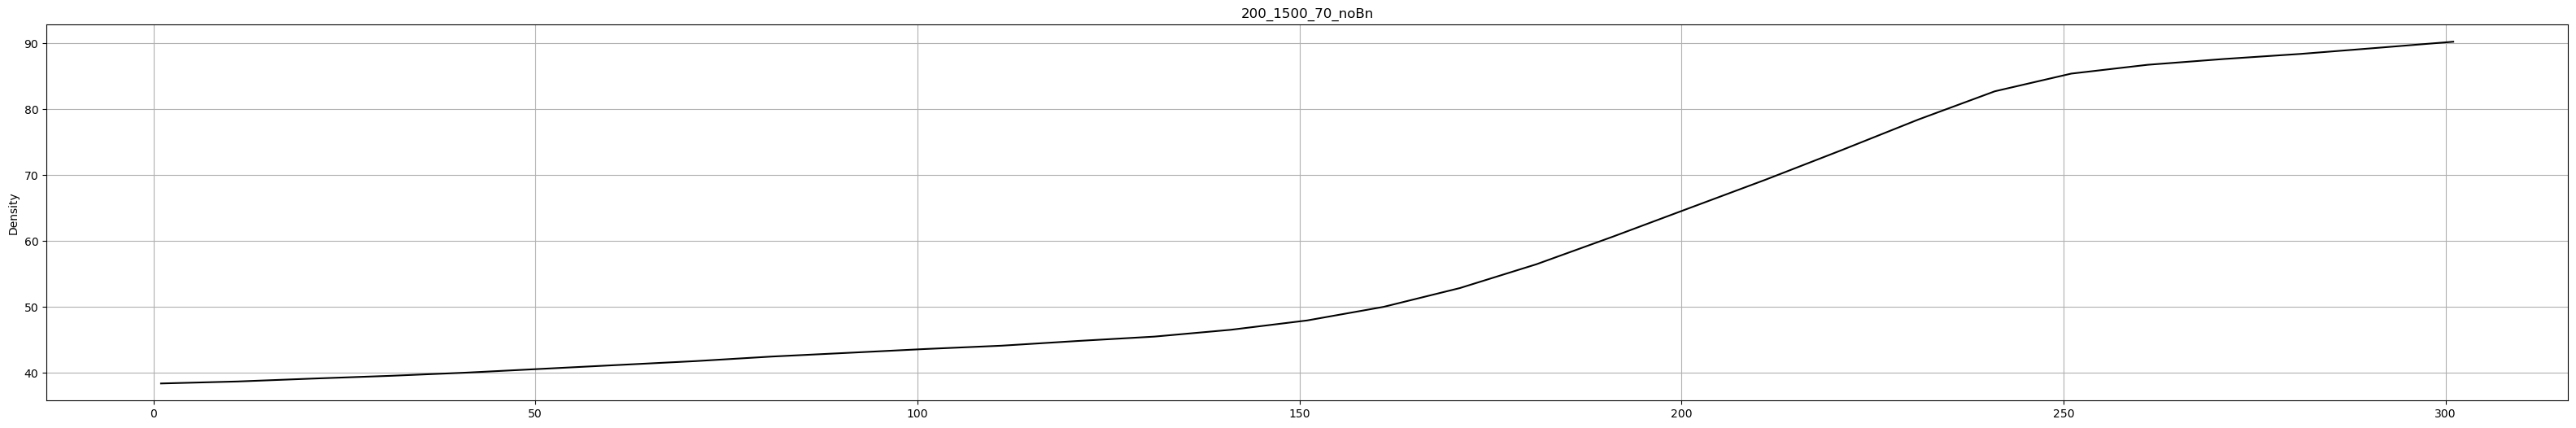

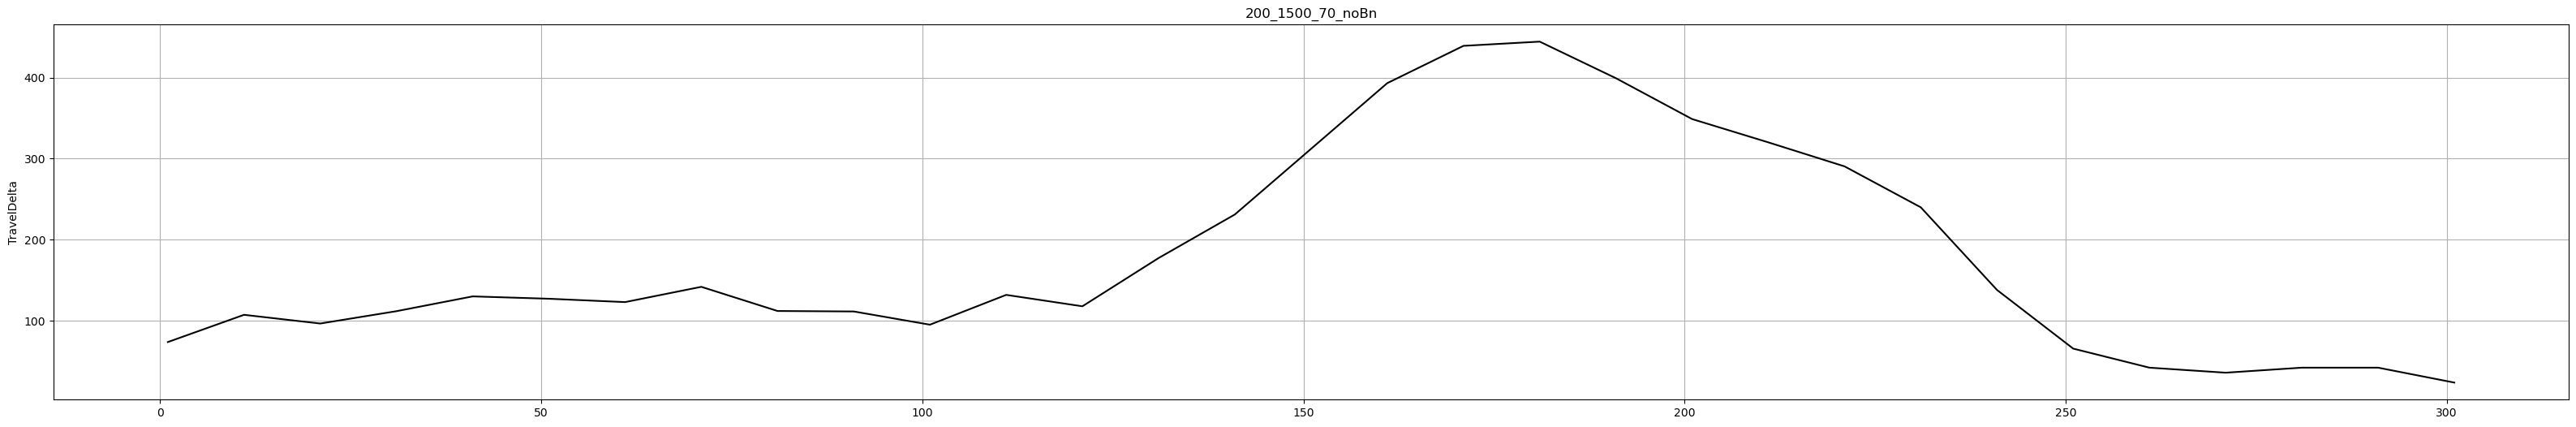

In [27]:
for key in data.keys():
    plot_data_Seconds(data[key], key)


<Figure size 2000x600 with 0 Axes>

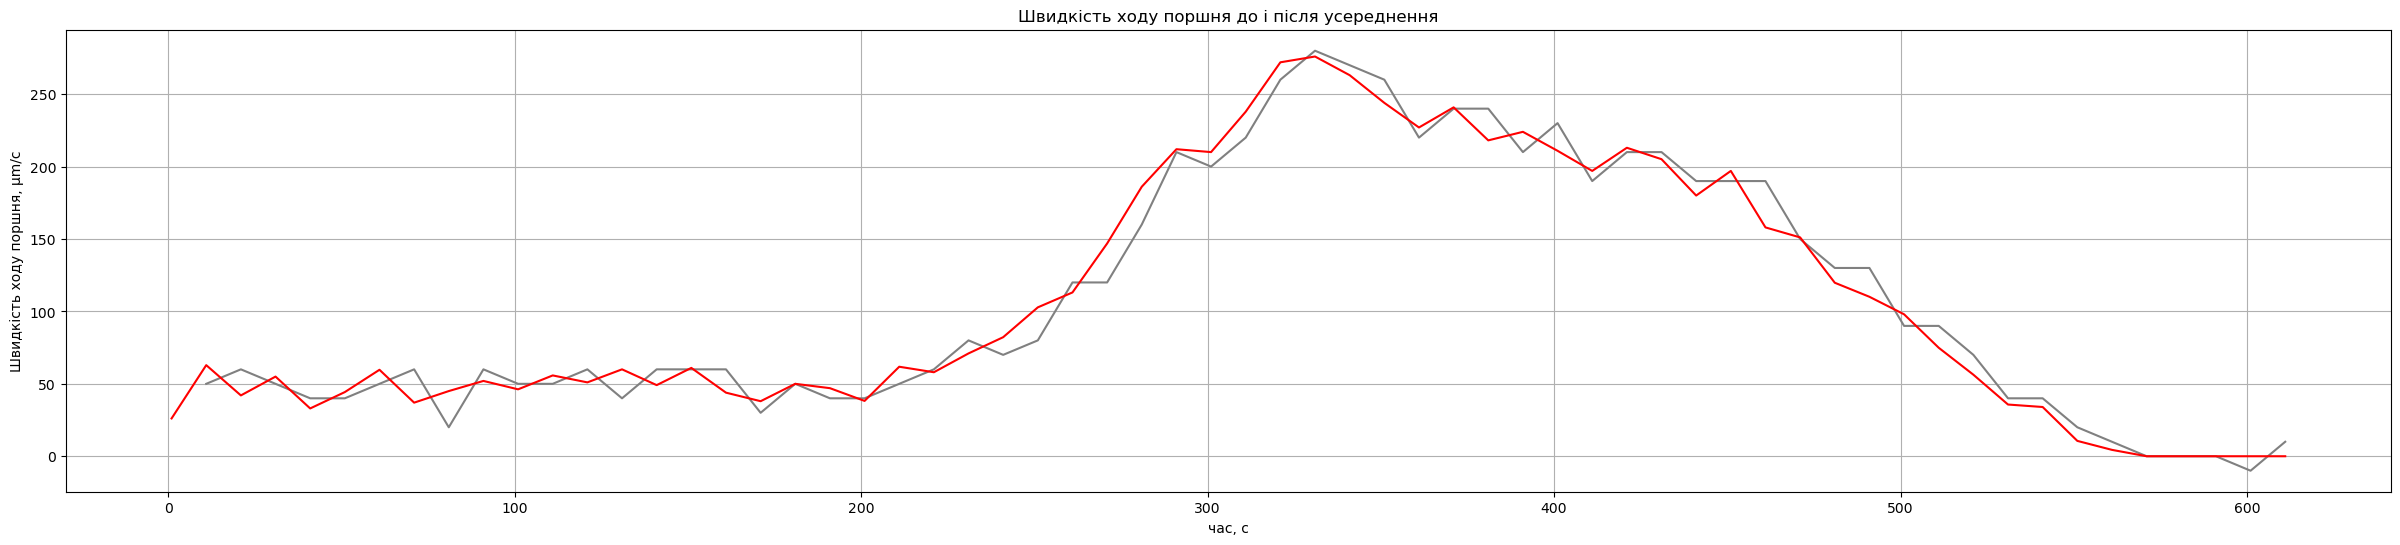

In [28]:
plt.figure(figsize=(20, 6))
fig, ax1 = plt.subplots( figsize=(30, 6))
#sc = ax1.plot(data900['seconds'], data900['TravelDelta'], color='red')  
#sc = ax1.plot(data1000['seconds'], data1000['TravelDelta'], color='green') 
sc = ax1.plot(data['100_1500_32']['seconds'], data['100_1500_32']['TravelDeltaOriginal']*1000, color='gray') 
sc = ax1.plot(data['100_1500_32']['seconds'], data['100_1500_32']['TravelDelta2'], color='red') 
ax1.set_ylabel('Швидкість ходу поршня, μm/с')
#ax1.set_ylim(400, 1000)
#ax1.set_xlim(300, 1400)
ax1.set_title('Швидкість ходу поршня до і після усереднення')
ax1.set_xlabel('час, с')
ax1.grid(True)
plt.show()


In [29]:
def plot_data_TravelDelta(data, title):
    setToPlot = data.copy()

    plt.figure(figsize=(40, 6))
    fig, ax1 = plt.subplots( figsize=(40, 6))
    sc = ax1.plot(setToPlot['Pyrometer'], setToPlot['TravelDelta'], color='red')  
    ax1.set_ylabel('TravelDelta')
    ax1.set_title(title)
    ax1.set_xlabel('Pyrometer')
    ax1.grid(True)
    plt.show()

<Figure size 4000x600 with 0 Axes>

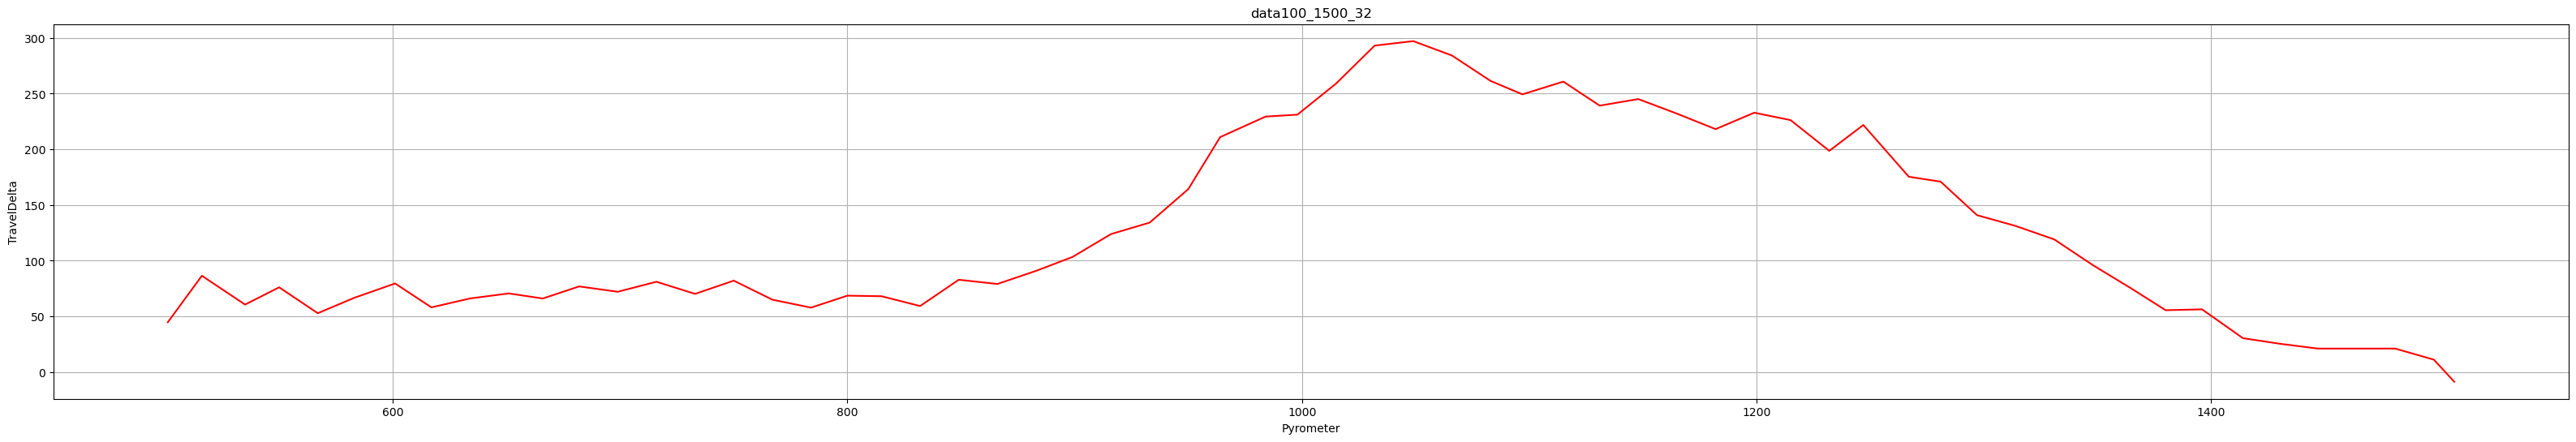

In [30]:
plot_data_TravelDelta(data['100_1500_32'], 'data100_1500_32')


In [31]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct, ConstantKernel as C
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Select the relevant columns - concatenate all training data
D = pd.concat([data[key] for key in data.keys()], axis=0)

#TravelRelativeCorrectedShifted

#X_train = X[['seconds','Heating', 'Pyrometer', 'AV Force']]
X_train = D[['seconds','TravelRelativeTempCorrected', 'Pyrometer','PyrometerShifted','Force','Density']]
#X_train = X[['seconds','Heating', 'Pyrometer']]
y_train = D['TravelRelativeTempCorrectedShifted']

 # Define the kernel for the GPR model
kernels = [
    C(1.0, (1e-4, 1e9)) * RBF(length_scale=1.0),
    C(1.0, (1e-4, 1e9)) * Matern(length_scale=1.0, nu=1.5),
    C(1.0, (1e-4, 1e9)) * RationalQuadratic(length_scale=1.0, alpha=0.1),
    C(1.0, (1e-4, 1e9)) * ExpSineSquared(length_scale=1.0, periodicity=3.0),
    C(1.0, (1e-4, 1e9)) * DotProduct(sigma_0=1.0)
]
kernel = kernels[2]

# Create and train the GPR model
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100, alpha=1e-3)
gpr.fit(X_train, y_train)

# Make predictions

#X_test = data1000[['seconds','Heating', 'Pyrometer', 'AV Force']]
X_test = data['100_1500_50'][['seconds','TravelRelativeTempCorrected', 'Pyrometer','PyrometerShifted','Force','Density']]
#X_test = data1000[['seconds','Heating', 'Pyrometer']]
y_test = data['100_1500_50']['TravelRelativeTempCorrectedShifted']

y_pred = gpr.predict(X_test)


# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Print the kernel parameters
print(f'Kernel parameters: {gpr.kernel_}')


c:\Users\arros\miniconda3\envs\SPS\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge after 31 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Mean Squared Error: 9.997685129076147e-07
Kernel parameters: 6.08e+03**2 * RationalQuadratic(alpha=0.00154, length_scale=2.24e+03)


<Figure size 1500x600 with 0 Axes>

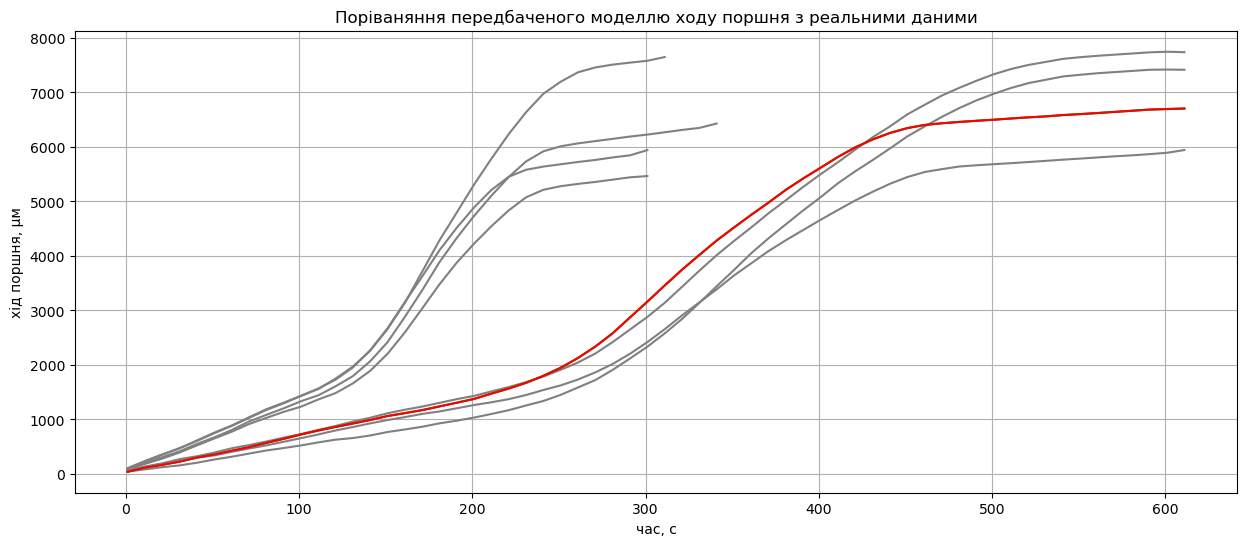

In [32]:
plt.figure(figsize=(15, 6))
fig, ax1 = plt.subplots( figsize=(15, 6))
for key in data.keys():
    if key == '100_1500_50':
        ax1.plot(data[key]['seconds'], data[key]['TravelRelativeTempCorrectedShifted'], color='green')
    else:
        ax1.plot(data[key]['seconds'], data[key]['TravelRelativeTempCorrectedShifted'], color='grey')
sc = ax1.plot(X_test['seconds'], y_pred, color='red') 
ax1.set_title('Поріваняння передбаченого моделлю ходу поршня з реальними даними')
ax1.set_xlabel('час, с')
ax1.set_ylabel('хід поршня, μм')
ax1.grid(True)
plt.show()


In [33]:
PredictionSet = data['200_1600_50'].head(1)
PredictionSet = PredictionSet[['seconds','TravelRelativeTempCorrected', 'Pyrometer','PyrometerShifted','Force','Density']]
PredictionSet = PredictionSet.reset_index(drop=True)
time = PredictionSet['seconds'].iloc[0]

newRegime = PredictionSet.copy()

heating = 1

print(PredictionSet)
while time < 4000 and ( heating == 1 or PredictionSet['PyrometerShifted'].iloc[0] > 1500) :
     TravelRelativeTempCorrectedPredicted = gpr.predict(PredictionSet, return_std=True); 
     #print(TravelRelativeTempCorrectedPredicted[0][0])
     if PredictionSet['PyrometerShifted'].iloc[0] > 1600:
           heating = 0
     time = time + 10
     PredictionSet.loc[0,'seconds'] = time
     PredictionSet.loc[0,'TravelRelativeTempCorrected'] = TravelRelativeTempCorrectedPredicted[0][0]
     PredictionSet.loc[0,'Pyrometer'] = PredictionSet['PyrometerShifted'].iloc[0]
     if heating:
          PredictionSet.loc[0,'PyrometerShifted'] = PredictionSet['PyrometerShifted'].iloc[0] + 33
     else:
          PredictionSet.loc[0,'PyrometerShifted'] = PredictionSet['PyrometerShifted'].iloc[0] -30
     #print(PredictionSet)
     newRegime = pd.concat([newRegime, PredictionSet], ignore_index=True)
     newRegime.at[newRegime.index[-1],'STD'] = TravelRelativeTempCorrectedPredicted[1][0]
#newRegime.head(100)


   seconds  TravelRelativeTempCorrected  Pyrometer  PyrometerShifted  Force  \
0        1                          0.0        503             538.0     16   

     Density  
0  36.373454  


In [34]:
def calculate_TargetDensificationRateValue(value):
    value = value / 100
    if value < 0.45:
        return 10
    elif 0.45 <= value < 0.70:
        # Лінійне зростання від 0 до 400
        return ((value - 0.45) / (0.70 - 0.45) * 400)+10

    elif 0.70 <= value < 0.85:
        return 200
    elif 0.85 <= value < 0.97:
        # Лінійне зменшення від 200 до 0
        return (0.97 - value) / (0.97 - 0.85) * 200
    else:
        return 0

def calculate_TargetDensificationRate(column):
    result = []
    for value in column:
        result.append(calculate_TargetDensificationRateValue(value))
    return pd.Series(result, index=column.index)

def find_closest_index(column, target_value):
    squared_diff = (column - target_value) ** 2
    return squared_diff.idxmin()

#calulate_TargetDensificationRate(0.45)


In [35]:
# Virtual Experiment: Optimize Sintering Process
# This code simulates a sintering process by iteratively predicting the optimal temperature
# to achieve target densification rates at each time step

# ============================================================================
# Initial Setup
# ============================================================================

# Start from first data point of the reference experiment
initial_state = data['100_1500_50'].head(1)
prediction_features = initial_state[['seconds', 'TravelRelativeTempCorrected', 'Pyrometer', 
                                      'PyrometerShifted', 'Force', 'Density']]
prediction_features = prediction_features.reset_index(drop=True)

# Initialize simulation parameters
current_time = prediction_features['seconds'].iloc[0]
num_temperature_options = 60  # Number of temperature scenarios to evaluate at each step
time_step = 10  # Seconds between predictions
max_simulation_time = 1000  # Maximum simulation duration
target_density = 96  # Target relative density percentage

# Store the predicted sintering regime
predicted_regime = prediction_features.copy()

# Create multiple prediction scenarios (will be populated in loop)
prediction_scenarios = pd.concat([predicted_regime] * num_temperature_options, ignore_index=True)

# ============================================================================
# Simulation Loop
# ============================================================================

is_heating = True
current_density = 32  # Starting density percentage

# Initialize prediction scenarios with different temperature options
current_time += time_step
for i in range(num_temperature_options):
    prediction_scenarios.loc[i, 'seconds'] = current_time
    # Temperature offset from -5 to +54 degrees relative to current temperature
    prediction_scenarios.loc[i, 'PyrometerShifted'] = prediction_scenarios['PyrometerShifted'].iloc[i] + i - 5

# Main simulation loop: continue until time limit or target density reached
while current_time < max_simulation_time and current_density < target_density:
    
    # ========================================================================
    # Step 1: Predict outcomes for all temperature scenarios
    # ========================================================================
    travel_predictions, prediction_std = gpr.predict(prediction_scenarios, return_std=True)
    
    # ========================================================================
    # Step 2: Calculate densification rates for each scenario
    # ========================================================================
    current_travel = prediction_scenarios['TravelRelativeTempCorrected'].iloc[0]
    densification_rates = (travel_predictions - current_travel) / time_step / 1000
    
    # Update current density based on predicted travel
    current_density = calculate_densityForVirtualExperiment(current_travel, 6.5, 48)
    
    # ========================================================================
    # Step 3: Select best temperature option
    # ========================================================================
    # Calculate target densification rate for current density
    target_rate = calculate_TargetDensificationRateValue(current_density)
    print(f'Target rate: {target_rate}')
    
    # Find which scenario gives densification rate closest to target
    predicted_rates_series = pd.Series(travel_predictions - current_travel)
    print(predicted_rates_series)
    best_scenario_index = find_closest_index(predicted_rates_series, target_rate)
    
    # ========================================================================
    # Step 4: Update prediction scenarios for next time step
    # ========================================================================
    current_time += time_step
    
    for i in range(num_temperature_options):
        prediction_scenarios.loc[i, 'seconds'] = current_time
        prediction_scenarios.loc[i, 'TravelRelativeTempCorrected'] = travel_predictions[best_scenario_index]
        prediction_scenarios.loc[i, 'Pyrometer'] = prediction_scenarios['PyrometerShifted'].iloc[best_scenario_index]
        
        # Generate temperature scenarios: heating up or cooling down
        if is_heating:
            # Temperature offset from -20 to +39 degrees
            prediction_scenarios.loc[i, 'PyrometerShifted'] = \
                prediction_scenarios['PyrometerShifted'].iloc[best_scenario_index] + i - 20
        else:
            # Cool down by 30 degrees
            prediction_scenarios.loc[i, 'PyrometerShifted'] = \
                prediction_scenarios['PyrometerShifted'].iloc[best_scenario_index] - 30
    
    # ========================================================================
    # Step 5: Record the selected scenario in the regime
    # ========================================================================
    best_prediction = prediction_scenarios.iloc[best_scenario_index]
    best_prediction_df = pd.DataFrame([best_prediction])
    
    predicted_regime = pd.concat([predicted_regime, best_prediction_df], ignore_index=True)
    predicted_regime.at[predicted_regime.index[-1], 'STD'] = prediction_std[best_scenario_index]
    
    # Progress tracking
    print(f'Time: {current_time}s')
    print(f'Density: {current_density:.2f}%')

# Display first few rows of the predicted regime
predicted_regime.head(10)

Target rate  57.999999999999964
0     105.088751
1     110.366890
2     115.484180
3     120.435904
4     125.217610
5     129.825121
6     134.254550
7     138.502309
8     142.565118
9     146.440019
10    150.124377
11    153.615896
12    156.912616
13    160.012929
14    162.915573
15    165.619643
16    168.124592
17    170.430229
18    172.536722
19    174.444598
20    176.154738
21    177.668376
22    178.987095
23    180.112822
24    181.047820
25    181.794683
26    182.356327
27    182.735980
28    182.937175
29    182.963734
30    182.819764
31    182.509637
32    182.037981
33    181.409665
34    180.629788
35    179.703658
36    178.636783
37    177.434851
38    176.103718
39    174.649387
40    173.077996
41    171.395800
42    169.609155
43    167.724497
44    165.748336
45    163.687226
46    161.547760
47    159.336549
48    157.060208
49    154.725339
50    152.338517
51    149.906278
52    147.435100
53    144.931394
54    142.401489
55    139.851622
56    137.287922

seconds  TravelRelativeTempCorrected  Pyrometer  PyrometerShifted  Force  \
0      1.0                     0.000000      503.0             519.0   16.0   
1     21.0                   105.088751      514.0             494.0   16.0   
2     31.0                   175.177935      498.0             502.0   16.0   
3     41.0                   251.393756      533.0             564.0   16.0   
4     51.0                   349.918033      596.0             628.0   16.0   
5     61.0                   442.758375      623.0             650.0   16.0   
6     71.0                   551.535030      678.0             706.0   16.0   
7     81.0                   662.063410      745.0             784.0   16.0   
8     91.0                   767.987760      784.0             823.0   16.0   
9    101.0                   879.606312      823.0             862.0   16.0   

     Density        STD  
0  35.366072        NaN  
1  35.366072  18.718939  
2  35.366072  73.534734  
3  35.366072  65.038623  
4  35.366072  18.151679  
5  35.366072   8.856271  
6  35.366072  19.724180  
7  35.366072  60.403485  
8  35.366072  73.201920  
9  35.366072  93.639957

(-20.0, 45.0)

<Figure size 1500x600 with 0 Axes>

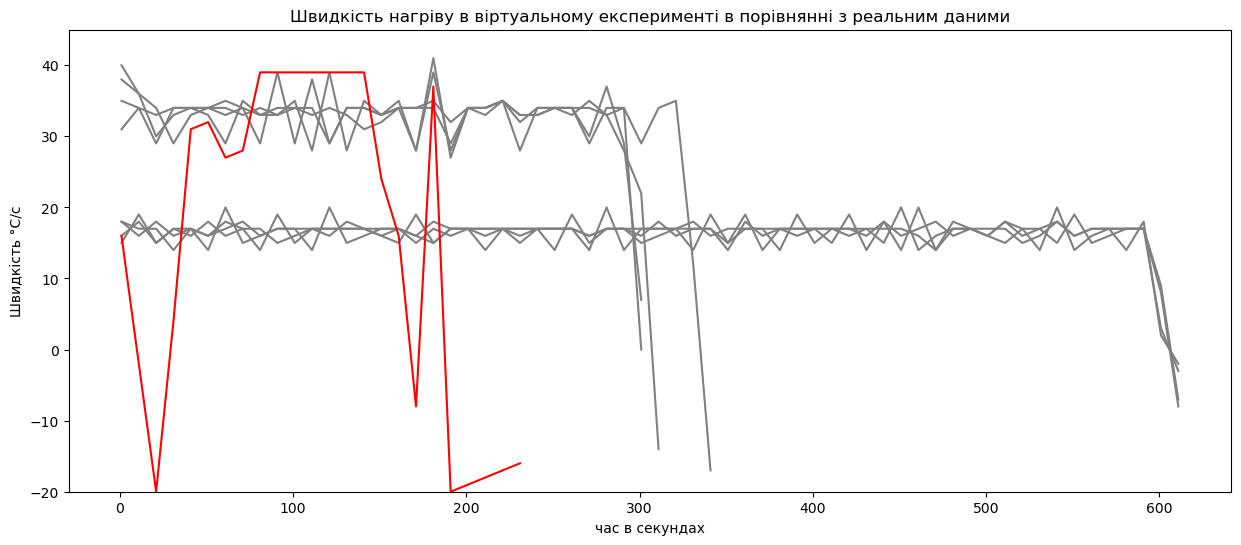

In [36]:
plt.figure(figsize=(15, 6))
fig, ax1 = plt.subplots( figsize=(15, 6))
#heating rate

for key in data.keys():
    ax1.plot(data[key]['seconds'], data[key]['PyrometerShifted'] - data[key]['Pyrometer'], color='gray')
sc = ax1.plot(newRegime['seconds'], newRegime['PyrometerShifted'] - newRegime['Pyrometer'], color='red') 
ax1.set_title('Швидкість нагріву в віртуальному експерименті в порівнянні з реальним даними')
ax1.set_xlabel('час в секундах')
ax1.set_ylabel('Швидкість °C/c')
ax1.set_ylim(-20, 45 )


Text(0, 0.5, 'TravelDelta μm/s')

<Figure size 1500x600 with 0 Axes>

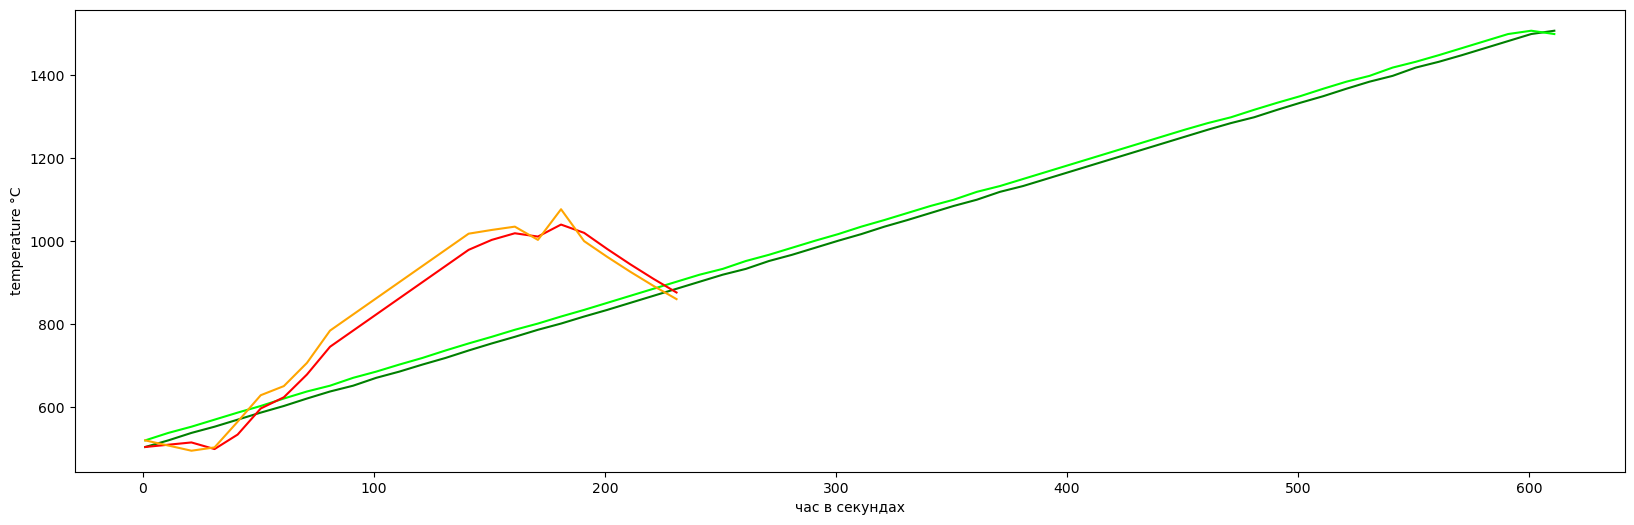

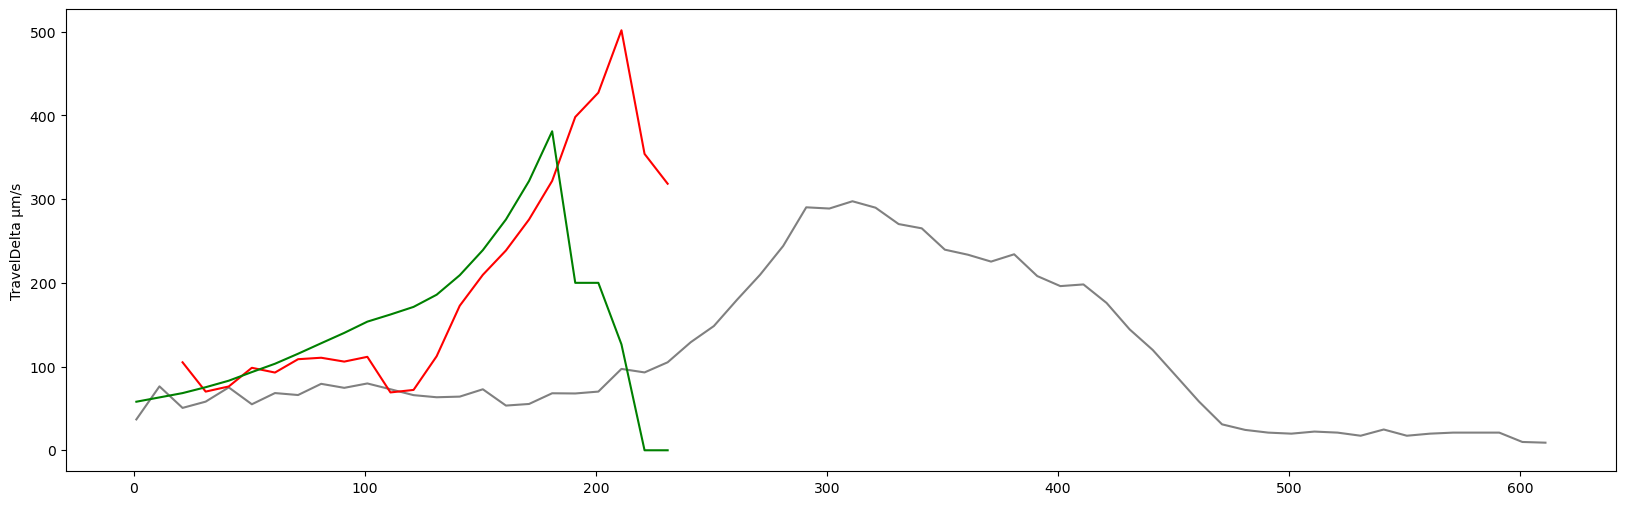

In [41]:
plt.figure(figsize=(15, 6))
fig, ax1 = plt.subplots( figsize=(20, 6))
fig, ax2 = plt.subplots( figsize=(20, 6))
#heating rate

ax1.plot(data['100_1500_50']['seconds'], data['100_1500_50']['Pyrometer'], color='green') 
ax1.plot(data['100_1500_50']['seconds'], data['100_1500_50']['PyrometerShifted'] , color='lime') 
ax1.plot(newRegime['seconds'], newRegime['Pyrometer'], color='red') 
ax1.plot(newRegime['seconds'], newRegime['PyrometerShifted'] , color='orange') 


ax2.plot(data['100_1500_50']['seconds'], data['100_1500_50']['TravelDelta'], color='gray')
ax2.plot( newRegime['seconds'], newRegime['TravelRelativeTempCorrected'] - newRegime['TravelRelativeTempCorrected'].shift(1), color='red')
ax2.plot( newRegime['seconds'], calculate_TargetDensificationRate(calculate_densityForVirtualExperiment(newRegime['TravelRelativeTempCorrected'], 6.5, 48)), color='green')
#ax1.set_title('Швидкість нагріву в віртуальному експерименті в порівнянні з реальним даними')
ax1.set_xlabel('час в секундах')
ax1.set_ylabel('temperature °C')
ax2.set_ylabel('TravelDelta μm/s')
#ax1.set_ylim(-20, 45 )


<Figure size 1500x600 with 0 Axes>

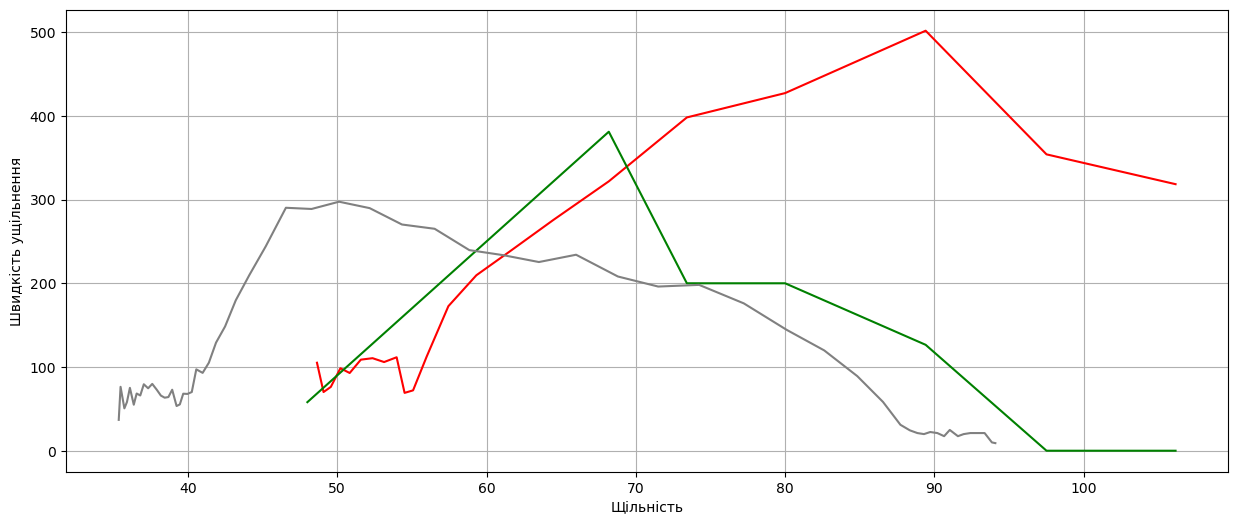

In [42]:
plt.figure(figsize=(15, 6))
fig, ax1 = plt.subplots( figsize=(15, 6))

#densification rate
sc = ax1.plot( calculate_densityForVirtualExperiment(newRegime['TravelRelativeTempCorrected'], 6.5, 48), newRegime['TravelRelativeTempCorrected'] - newRegime['TravelRelativeTempCorrected'].shift(1), color='red')
sc = ax1.plot( calculate_densityForVirtualExperiment(newRegime['TravelRelativeTempCorrected'], 6.5, 48), calculate_TargetDensificationRate(calculate_densityForVirtualExperiment(newRegime['TravelRelativeTempCorrected'], 6.5, 48)), color='green')
sc = ax1.plot(data['100_1500_50']['Density'], data['100_1500_50']['TravelDelta'], color='grey')

#sc = ax1.plot(calulate_densityForVirtualExperiment(newRegime['TravelRelativeTempCorrected'], 6.5, 48), newRegime['STD'], color='blue') 

#ax1.set_title('title')
ax1.set_xlabel('Щільність')
ax1.set_ylabel('Швидкість ущільнення')
ax1.grid(True)
plt.show()


<Figure size 1500x600 with 0 Axes>

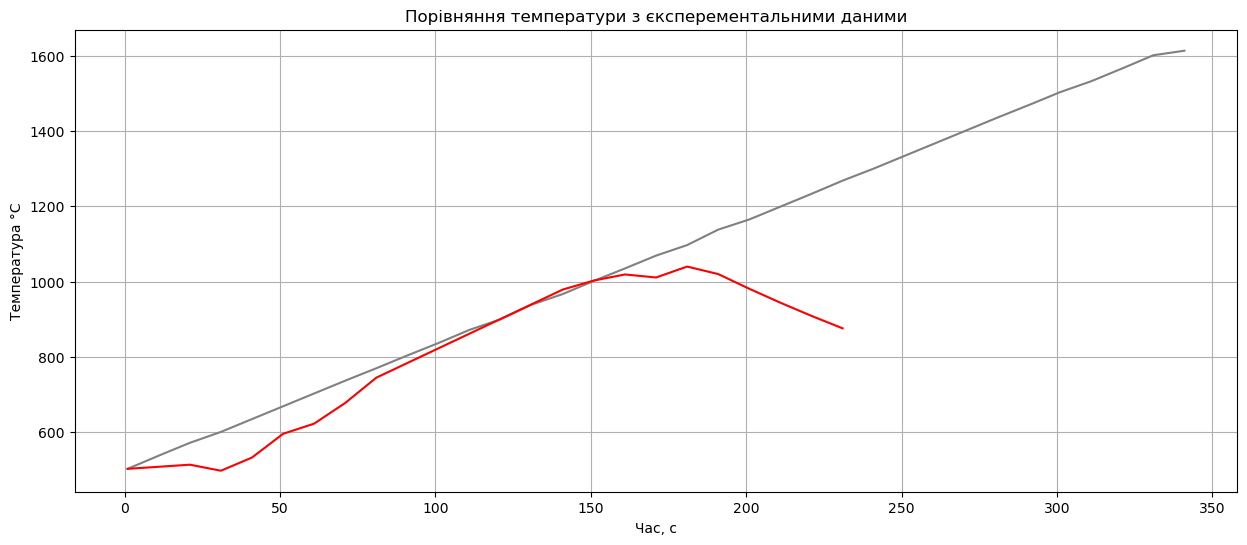

In [43]:
plt.figure(figsize=(15, 6))
fig, ax1 = plt.subplots( figsize=(15, 6))

#Temperature
sc = ax1.plot(data['200_1600_50']['seconds'], data['200_1600_50']['Pyrometer'], color='grey')
sc = ax1.plot(newRegime['seconds'], newRegime['Pyrometer'], color='red')

ax1.set_title('Порівняння температури з єксперементальними даними')
ax1.set_xlabel('Час, с')
ax1.set_ylabel('Температура °C')
ax1.grid(True)
plt.show()

<Figure size 1500x600 with 0 Axes>

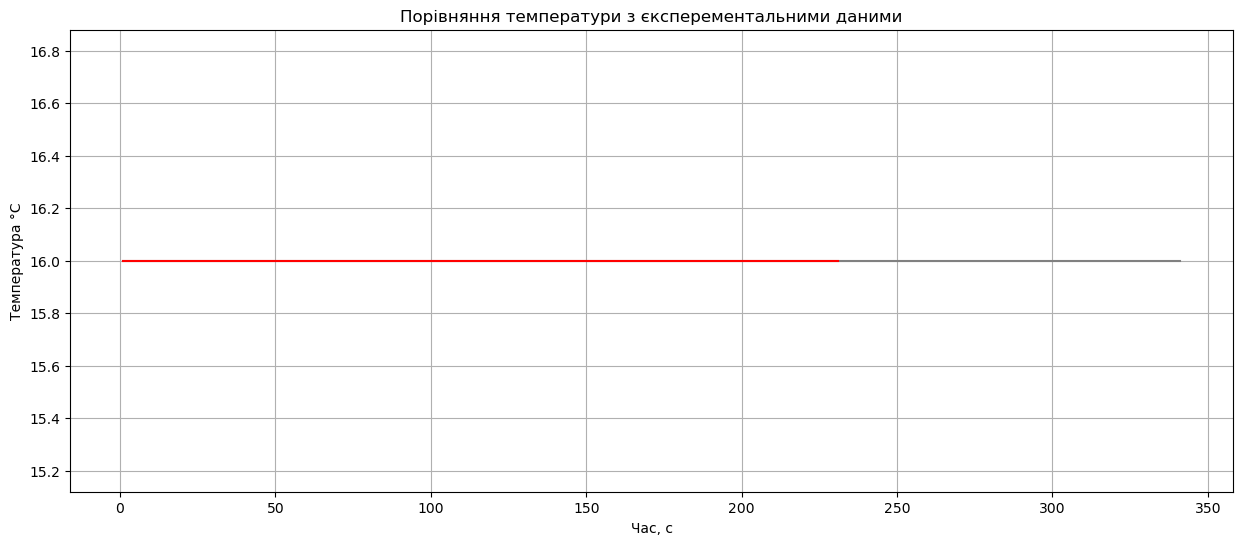

In [44]:
plt.figure(figsize=(15, 6))
fig, ax1 = plt.subplots( figsize=(15, 6))

#Temperature
sc = ax1.plot(data['200_1600_50']['seconds'], data['200_1600_50']['Force'], color='grey')
sc = ax1.plot(newRegime['seconds'], newRegime['Force'], color='red')

ax1.set_title('Порівняння температури з єксперементальними даними')
ax1.set_xlabel('Час, с')
ax1.set_ylabel('Температура °C')
ax1.grid(True)
plt.show()

<Figure size 1500x600 with 0 Axes>

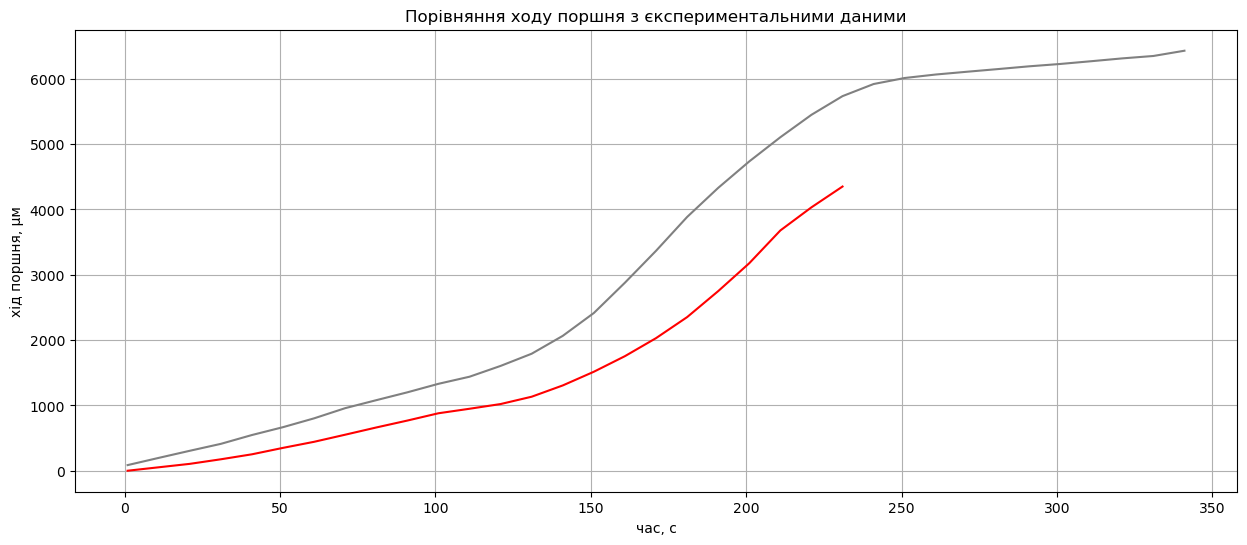

In [45]:
plt.figure(figsize=(15, 6))
fig, ax1 = plt.subplots( figsize=(15, 6))

sc = ax1.plot(data['200_1600_50']['seconds'], data['200_1600_50']['TravelRelativeTempCorrectedShifted'], color='grey') 
sc = ax1.plot(newRegime['seconds'], newRegime['TravelRelativeTempCorrected'], color='red') 
 
ax1.set_title('Порівняння ходу поршня з єкспериментальними даними')
ax1.set_xlabel('час, с')
ax1.set_ylabel('хід поршня, μм')
ax1.grid(True)
plt.show()

<Figure size 4000x600 with 0 Axes>

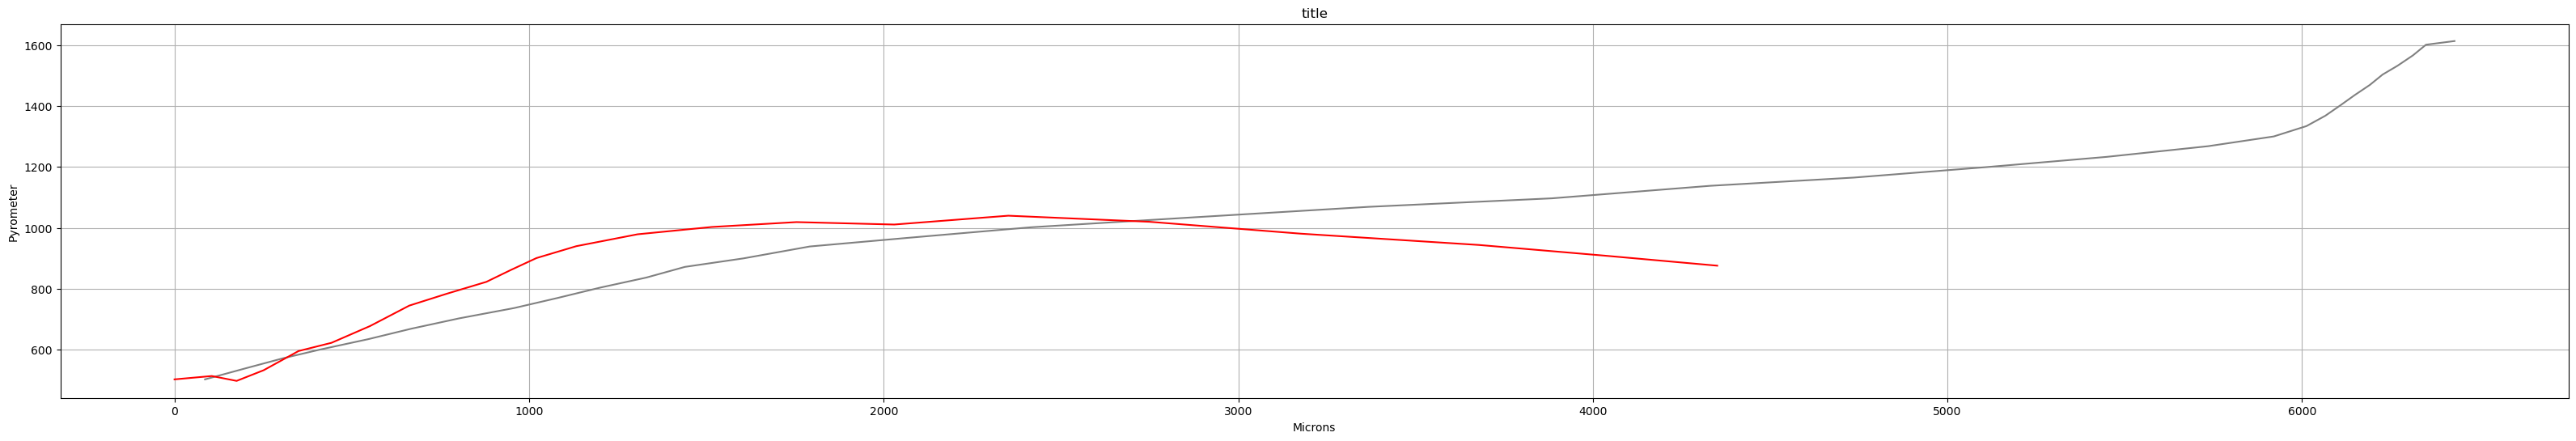

In [46]:
plt.figure(figsize=(40, 6))
fig, ax1 = plt.subplots( figsize=(40, 6))

sc = ax1.plot(data['200_1600_50']['TravelRelativeTempCorrectedShifted'], data['200_1600_50']['Pyrometer'], color='grey') 
sc = ax1.plot(newRegime['TravelRelativeTempCorrected'], newRegime['Pyrometer'], color='red') 
 

ax1.set_title('title')
ax1.set_xlabel('Microns')
ax1.set_ylabel('Pyrometer')
ax1.grid(True)
plt.show()

<Figure size 4000x600 with 0 Axes>

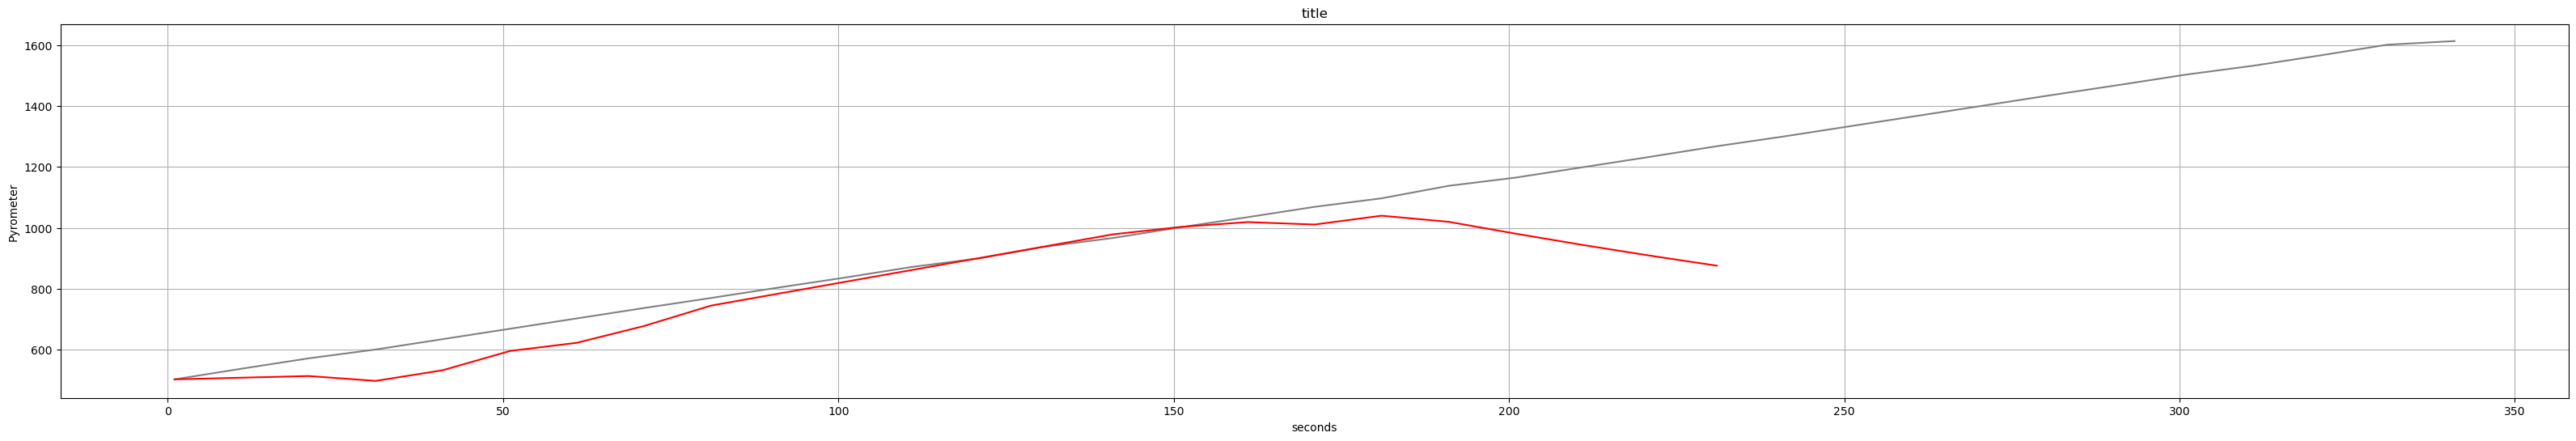

In [47]:
plt.figure(figsize=(40, 6))
fig, ax1 = plt.subplots( figsize=(40, 6))

sc = ax1.plot(data['200_1600_50']['seconds'], data['200_1600_50']['Pyrometer'], color='grey') 
#sc = ax1.plot(dataN1100['seconds'], dataN1100['Pyrometer'], color='grey') 
sc = ax1.plot(newRegime['seconds'], newRegime['Pyrometer'], color='red') 
 

ax1.set_title('title')
ax1.set_xlabel('seconds')
ax1.set_ylabel('Pyrometer')
ax1.grid(True)
plt.show()